In [2]:
import csv
import os

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error

2024-11-09 05:59:44.046275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-09 05:59:44.350666: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 05:59:45.438887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/usr/include/opencv4
2024-11-09 05:59:45.439004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvi

In [36]:
class PredictionCallback(Callback):
    def __init__(self, val_data):
        super(PredictionCallback, self).__init__()
        self.val_data = val_data

    def on_train_end(self, logs=None):

        # model testing
        val_pred_all = []
        val_true_all = []

        # Loop through the entire validation dataset
        for batch in self.val_data:
            inputs, y_true = batch
            y_pred = self.model.predict(inputs)
            for i in range(y_true.shape[0]):
                distance, _ = self.find_largest_diag(y_pred[i])
                val_pred_all.append(distance)
                distance, _ = self.find_largest_diag(y_true[i])
                val_true_all.append(distance)

        # Display final predictions for the first 30 samples
        print("\nFinal predictions after training:")
        print("Predicted:", val_pred_all[:30])
        print("True:", val_true_all[:30])

        # f1 score, accuracy, mae
        f1 = f1_score(val_true_all, val_pred_all, average='micro')
        acc = accuracy_score(val_true_all, val_pred_all)
        mae = mean_absolute_error(val_true_all, val_pred_all)

        print(f"accuracy in total: {acc}")
        print(f"f1 score: {f1}")
        print(f"mean absolute error: {mae}")

        # Take the first batch of validation samples at the end of training
        for batch in self.val_data.take(1):
            inputs, y_true = batch
            y_pred = self.model.predict(inputs)

            # Print final predictions and corresponding true values after training
            print("\nheatmap visualization:")
            distance, heatmap = self.find_largest_diag(y_pred[0])

            # Plot the heatmap
            plt.figure(figsize=(21, 21))
            sns.heatmap(y_pred[0], annot=True, cmap="coolwarm")
            plt.title(f'predition: {distance}')
            plt.show()

            plt.figure(figsize=(21, 21))
            sns.heatmap(heatmap, annot=True, cmap="coolwarm")
            plt.title('predition heatmap (row and column maxima)')
            plt.show()

            plt.figure(figsize=(21, 21))
            sns.heatmap(y_true[0], annot=True, cmap="coolwarm")
            plt.title('True Labels Heatmap')
            plt.show()

    def find_largest_diag(self, similarity_matrix):
        # Get matrix dimensions
        n = similarity_matrix.shape[0]

        # Convert to TensorFlow tensor
        sim_matrix = tf.constant(similarity_matrix, dtype=tf.float32)

        # Find the position of the maximum value in each row
        row_max_indices = []
        for i in range(n):
            row_idx = tf.argmax(sim_matrix[i, :])
            row_max_indices.append(tf.round(row_idx))  # Round the softargmax result to integer index
        row_max_indices = tf.stack(row_max_indices)
        # print("Row max indices (rounded):", row_max_indices)

        # Find the position of the maximum value in each column
        col_max_indices = []
        for i in range(n):
            col_idx = tf.argmax(sim_matrix[:, i])
            col_max_indices.append(tf.round(col_idx))  # Similarly, round each column result
        col_max_indices = tf.stack(col_max_indices)
        # print("Column max indices (rounded):", col_max_indices)

        # Create a heatmap to mark the maximum values
        heatmap = np.zeros_like(similarity_matrix)
        for i in range(n):
            row_idx = int(row_max_indices[i].numpy())
            col_idx = int(col_max_indices[i].numpy())

            # Ensure indices are within matrix dimensions
            if 0 <= row_idx < n:
                heatmap[i, row_idx] += 1  # Mark the maximum value in each row
            if 0 <= col_idx < n:
                heatmap[col_idx, i] += 1  # Mark the maximum value in each column

        # Find the diagonal with the most marks
        max_diag_marks = -1
        max_diag_idx = 0
        for diag_idx in range(-n + 1, n):
            diag_marks = np.sum(np.diag(heatmap, k=diag_idx))
            if diag_marks > max_diag_marks:
                max_diag_marks = diag_marks
                max_diag_idx = diag_idx

        # Calculate the distance of the optimal diagonal from the center diagonal
        distance = max_diag_idx

        # Return the distance and the heatmap
        return distance, heatmap

In [37]:
def get_positional_encoding(seq_len, embed_dim):
    """
    Generates the positional encoding matrix for the input sequence.
    Args:
        seq_len (int): The length of the input sequence.
        embed_dim (int): The embedding dimension.
    Returns:
        tf.Tensor: A tensor containing positional encodings.
    """
    position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]  # Shape (seq_len, 1)
    div_term = tf.exp(
        tf.range(0, embed_dim, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / embed_dim))  # Shape (embed_dim//2,)

    pos_enc = tf.zeros((seq_len, embed_dim))

    # Apply sin to even indices
    pos_enc = pos_enc + tf.concat([tf.sin(position * div_term), tf.cos(position * div_term)], axis=-1)

    return pos_enc

class EncoderLayer(tf.keras.layers.Layer):
        def __init__(self, d_model, nhead):
            super(EncoderLayer, self).__init__()

            self.nhead = nhead

            self.q_proj = layers.Dense(d_model, use_bias=False)
            self.k_proj = layers.Dense(d_model, use_bias=False)
            self.v_proj = layers.Dense(d_model, use_bias=False)
            self.attention = layers.MultiHeadAttention(num_heads=self.nhead, key_dim=d_model)
            self.merge = layers.Dense(d_model, use_bias=False)

            # feed-forward network
            self.mlp = tf.keras.Sequential([
                layers.Dense(d_model * 2, use_bias=False),
                layers.ReLU(),
                layers.Dropout(0.1),
                layers.Dense(d_model, use_bias=False),
                layers.Dropout(0.1),
            ])

            # norm layers
            self.norm1 = layers.LayerNormalization()
            self.norm2 = layers.LayerNormalization()

        def call(self, x, source):
            # multi-head attention
            query = self.q_proj(x)
            key = self.k_proj(source)
            value = self.v_proj(source)

            message = self.attention(query=query, key=key, value=value)
            message = self.merge(message)
            message = self.norm1(message)

            # feed-forward network
            message = self.mlp(tf.concat([x, message], axis=-1))   # x --> query
#             message = self.mlp(tf.concat([query, message], axis=-1))  # x --> query
            message = self.norm2(message)

            return x + message  # x --> query
#             return query + message  # x --> query

In [38]:
class TransformerModel(tf.keras.Model):
    def __init__(self, num_heads=4, embed_dim=48, num_layers=2,sequence_length=20):
        super(TransformerModel, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.sequence_length = sequence_length
        
        self.mask_token = self.add_weight("class_token", shape=[1, 1, embed_dim], initializer="random_normal")
#         self.mask_token = self.add_weight("class_token", shape=[1, 1, embed_dim], initializer="zeros", trainable=False)
        # self.mask_token = self.add_weight("class_token", shape=[1, 1, embed_dim], initializer="zeros", trainable=True)

        # Transformer Encoder layers (Now using cross-attention)
        self.encoder_layers = [
            EncoderLayer(d_model=embed_dim, nhead=num_heads)
#             EncoderLayer(d_model=128, nhead=num_heads)
            for _ in range(num_layers * 2)
        ]

        self.multiHeadattention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=self.embed_dim)

    def call(self, inputs, training=True):
        query = inputs['query']
        context = inputs['context']
        batch_size = tf.shape(query)[0]
        seq_len = tf.shape(query)[1]
        
        mask_token = tf.broadcast_to(self.mask_token, [batch_size, 1, 48])
        
        query = tf.concat([query,mask_token], axis=1)
        context = tf.concat([context,mask_token], axis=1)
        
        seq_len = seq_len + 1
        
        # Incorporate positional encoding
        self.positional_encoding = get_positional_encoding(seq_len, self.embed_dim)
        
        # Add positional encoding to query and context after concatenating the class token
        query += self.positional_encoding[:seq_len, :]  # Adding positional encoding for sequence
        context += self.positional_encoding[:seq_len, :]

        # Pass through transformer encoder layers using cross-attention
        for i, encoder_layer in enumerate(self.encoder_layers):
            if i % 2 == 0:
                # self-attention
                query = encoder_layer(query, query)
                context = encoder_layer(context, context)

            else:
                # cross-attention
                query = encoder_layer(query, context)
                context = encoder_layer(context, query)

        _, attention_scores = self.multiHeadattention(query=query, key=context, value=context,
                                                      return_attention_scores=True)

        similarity_matrix = tf.reduce_mean(attention_scores, axis=1)

        return similarity_matrix

    def find_largest_diag(self, similarity_matrix):
        # Get matrix dimensions
        n = similarity_matrix.shape[0]

        # Convert to TensorFlow tensor
        sim_matrix = tf.constant(similarity_matrix, dtype=tf.float32)

        # Find the position of the maximum value in each row
        row_max_indices = []
        for i in range(n):
            row_idx = tf.argmax(sim_matrix[i, :])
            row_max_indices.append(tf.round(row_idx))  # Round the softargmax result to integer index
        row_max_indices = tf.stack(row_max_indices)
        # print("Row max indices (rounded):", row_max_indices)

        # Find the position of the maximum value in each column
        col_max_indices = []
        for i in range(n):
            col_idx = tf.argmax(sim_matrix[:, i])
            col_max_indices.append(tf.round(col_idx))  # Similarly, round each column result
        col_max_indices = tf.stack(col_max_indices)
        # print("Column max indices (rounded):", col_max_indices)

        # Create a heatmap to mark the maximum values
        heatmap = np.zeros_like(similarity_matrix)
        for i in range(n):
            row_idx = int(row_max_indices[i].numpy())
            col_idx = int(col_max_indices[i].numpy())

            # Ensure indices are within matrix dimensions
            if 0 <= row_idx < n:
                heatmap[i, row_idx] += 1  # Mark the maximum value in each row
            if 0 <= col_idx < n:
                heatmap[col_idx, i] += 1  # Mark the maximum value in each column

        # Find the diagonal with the most marks
        max_diag_marks = -1
        max_diag_idx = 0
        for diag_idx in range(-n + 1, n):
            diag_marks = np.sum(np.diag(heatmap, k=diag_idx))
            if diag_marks > max_diag_marks:
                max_diag_marks = diag_marks
                max_diag_idx = diag_idx

        # Calculate the distance of the optimal diagonal from the center diagonal
        distance = max_diag_idx

        # Return the distance and the heatmap
        return distance, heatmap

    def create_diag_matrix(self, y):
        # Create a matrix of shape (sequence_length + 1, sequence_length + 1)
        matrix = np.zeros((self.sequence_length + 1, self.sequence_length + 1), dtype=np.float32)

        diag_offset = int(y)
        if -self.sequence_length < diag_offset < self.sequence_length:
            effective_length = max(0, self.sequence_length - abs(diag_offset))
            if effective_length > 0:
                np.fill_diagonal(matrix[max(0, -diag_offset):self.sequence_length, 
                                        max(0, diag_offset):self.sequence_length], 1)

        # Add the last row and last column as the "dustbin"
        for i in range(self.sequence_length):
            # If the row contains a 1, mark the last column as 0; otherwise, mark as 1
            matrix[i, -1] = 0 if np.any(matrix[i, :self.sequence_length] == 1) else 1
        for j in range(self.sequence_length):
            # If the column contains a 1, mark the last row as 0; otherwise, mark as 1
            matrix[-1, j] = 0 if np.any(matrix[:self.sequence_length, j] == 1) else 1

        return matrix

    def map_fn(self, features, y_label):
        # Use py_function to call create_diag_matrix and convert it to a TensorFlow tensor
        diag_matrix = tf.py_function(func=self.create_diag_matrix, inp=[y_label], Tout=tf.float32)
        # Ensure the diag_matrix shape is set to (sequence_length + 1, sequence_length + 1)
        diag_matrix.set_shape((self.sequence_length + 1, self.sequence_length + 1))
        return features, diag_matrix

    def train(self, pathSimilarityVectorsArray: str, batch_size=256, epochs=100, learning_rate=1e-3, weight_name=""):
        """
        Args:
            train_dataset (tf.data.Dataset): Training dataset.
            val_dataset (tf.data.Dataset): Validation dataset.
            epochs (int): Number of epochs to train for.
            learning_rate (float): Learning rate for the optimizer.
            train_steps_per_epoch (int): Number of training steps per epoch.
            val_steps_per_epoch (int): Number of validation steps per epoch.
        """

        trainDS = np.load(fr"{pathSimilarityVectorsArray}", allow_pickle=True)

        # Extracting the features and labels from the training dataset
        left_features = trainDS[:, 0].tolist()
        right_features = trainDS[:, 1].tolist()
        y = trainDS[:, 4].tolist()

        # Convert lists to numpy arrays and then to tensors
        left_features = np.array(left_features)
        right_features = np.array(right_features)
        y = np.array(y).astype(np.float32)

        left_features = tf.convert_to_tensor(left_features, dtype=tf.float32)
        right_features = tf.convert_to_tensor(right_features, dtype=tf.float32)

        # Split the dataset into training and validation sets
        size = int(len(y) * 0.8)  # Use 80% of the data for training
        left_features_train, left_features_val = left_features[:size], left_features[size:]
        right_features_train, right_features_val = right_features[:size], right_features[size:]
        y_train, y_val = y[:size], y[size:]

        # Creating TensorFlow datasets without preprocessing labels in advance
        train_dataset = tf.data.Dataset.from_tensor_slices(
            ({'query': left_features_train, 'context': right_features_train}, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=1024)

        # Use a map function to convert y to diagonal matrices
        train_dataset = train_dataset.map(self.map_fn).batch(batch_size, drop_remainder=True).repeat()

        # Construct the validation dataset
        val_dataset = tf.data.Dataset.from_tensor_slices(
            ({'query': left_features_val, 'context': right_features_val}, y_val))
        val_dataset = val_dataset.map(self.map_fn).batch(32, drop_remainder=True)

        # Calculate the number of training and validation steps per epoch
        train_steps_per_epoch = len(left_features_train) // batch_size
        val_steps_per_epoch = len(left_features_val) // 32

        # Add ModelCheckpoint to save only the weights of the best model
        checkpoint_callback = ModelCheckpoint(
            filepath = weight_name,  # Save only the model weights
            monitor='val_accuracy',  # Monitor validation accuracy
            save_best_only=True,  # Save only if the validation accuracy improves
            mode='max',  # We want to maximize the validation accuracy
            save_weights_only=True,  # Save only the weights, not the entire model
            verbose=1
        )

        # Compile the model using the custom loss function
        optimizer = Adam(learning_rate=learning_rate)
        self.compile(optimizer=optimizer, loss=self.rows_cols_crossentropyLoss,metrics=['accuracy'])

        # Train the model with the specified datasets, number of epochs, and callbacks
        self.fit(
            train_dataset,
            epochs=epochs,
            steps_per_epoch=train_steps_per_epoch,
            validation_data=val_dataset,
            validation_steps=val_steps_per_epoch,
            callbacks=[checkpoint_callback, PredictionCallback(val_dataset)]
        )

        # Load the best model weights at the end of training
        self.load_weights(weight_name)

    def rows_cols_crossentropyLoss(self, y_true, y_pred):
        # Row-wise softmax
        y_pred_row_softmax = tf.nn.softmax(y_pred, axis=-1)  # Softmax along rows (axis=-1)
        # Column-wise softmax
        y_pred_col_softmax = tf.nn.softmax(y_pred, axis=-2)  # Softmax along columns (axis=-2)

        # Row-wise cross-entropy loss (batch-wise operation)
        row_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred_row_softmax)

        # Transpose y_true and y_pred for column-wise loss (only last two dimensions)
        y_true_transposed = tf.transpose(y_true, perm=[0, 2, 1])  # Swap last two dimensions for batched input
        y_pred_col_softmax_transposed = tf.transpose(y_pred_col_softmax, perm=[0, 2, 1])

        # Column-wise cross-entropy loss
        col_loss = tf.keras.losses.categorical_crossentropy(y_true_transposed, y_pred_col_softmax_transposed)

        # Final loss is the average of row and column losses (only summing valid rows and columns)
        total_loss = (tf.reduce_mean(row_loss) + tf.reduce_mean(col_loss)) 

        return total_loss

    def pred(self, pathSimilarityVectorsArray: str, weight_name="",video_pair = "" , output_path = ""):

        DS = np.load(fr"{pathSimilarityVectorsArray}", allow_pickle=True)

        # Extracting the features and labels from the training dataset
        left_features = DS[:, 0].tolist()
        right_features = DS[:, 1].tolist()
        y = DS[:, 4].tolist()

        # Convert lists to numpy arrays and then to tensors
        left_features = np.array(left_features)
        right_features = np.array(right_features)
        y = np.array(y).astype(np.float32)

        left_features = tf.convert_to_tensor(left_features, dtype=tf.float32)
        right_features = tf.convert_to_tensor(right_features, dtype=tf.float3ed2)

        # Construct the validation dataset
        dataset = tf.data.Dataset.from_tensor_slices(
            ({'query': left_features, 'context': right_features}, y))
        dataset = dataset.map(self.map_fn).batch(512, drop_remainder=True)

        print("Model initialized. Starting predictions...")

        # Perform one forward pass to initialize model variables
        for batch in dataset.take(1):
            inputs, _ = batch
            _ = self(inputs, training=False)  # This will initialize the model's variables

        # Load the best model weights
        self.load_weights(weight_name)

        print("weights loaded:", weight_name)

        # Initialize variables for storing predictions and true values
        val_pred_all = []
        val_true_all = []
        loss_all = []

        # Loop through the dataset and make predictions
        for batch in dataset:
            inputs, y_true = batch
            y_pred = self(inputs, training=False)
            
            # Calculate rows_cols_crossentropyLoss for this batch
            batch_loss = self.rows_cols_crossentropyLoss(y_true, y_pred)
            loss_all.append(batch_loss.numpy())  # Store the loss value

            for i in range(y_true.shape[0]):
                distance_pred, _ = self.find_largest_diag(y_pred[i])
                val_pred_all.append(distance_pred)
                distance_true, _ = self.find_largest_diag(y_true[i])
                val_true_all.append(distance_true)
        
        # Calculate and display the average loss
        avg_loss = np.mean(loss_all)
        print(f"Average rows_cols_crossentropyLoss: {avg_loss}")

        # Display final predictions for the first 30 samples
        print("\nFinal predictions after training:")
        print("Predicted:", val_pred_all[:30])
        print("True:", val_true_all[:30])

        # f1 score, accuracy, mae
        f1 = f1_score(val_true_all, val_pred_all, average='micro')
        acc = accuracy_score(val_true_all, val_pred_all)
        mae = mean_absolute_error(val_true_all, val_pred_all)

        print(f"Accuracy in total: {acc}")
        print(f"F1 score: {f1}")
        print(f"Mean Absolute Error: {mae}")

        # Ensure the directory exists
        directory = os.path.dirname(output_path)
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Save the predictions to a csv file
        csv_file = f"{output_path}.csv"
        file_exists = os.path.isfile(csv_file)

        with open(csv_file, 'a', newline='') as csvfile:
            fieldnames = ['video_pair', 'accuracy', 'f1_score', 'mean_absolute_error',
                          'output_samples', 'label_samples']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            if not file_exists:
                writer.writeheader()

            writer.writerow({
                'video_pair': video_pair,
                'accuracy': acc,
                'f1_score': f1,
                'mean_absolute_error': mae,
                'output_samples': val_pred_all[:30],
                'label_samples': val_true_all[:30]
            })

        # Take the first batch for heatmap visualization
        for batch in dataset.take(1):
            inputs, y_true = batch
            y_pred = self(inputs)

            # Visualize heatmaps
            print("\nHeatmap visualization for first prediction:")
            distance, heatmap = self.find_largest_diag(y_pred[0])

            # Plot predicted heatmap
            plt.figure(figsize=(20, 20))
            sns.heatmap(y_pred[0], annot=True, cmap="coolwarm")
            plt.title(f'Prediction: {distance}')
            plt.show()

            # Plot heatmap for maxima
            plt.figure(figsize=(20, 20))
            sns.heatmap(heatmap, annot=True, cmap="coolwarm")
            plt.title('Prediction heatmap (row and column maxima)')
            plt.show()

            # Plot true heatmap
            plt.figure(figsize=(20, 20))
            sns.heatmap(y_true[0], annot=True, cmap="coolwarm")
            plt.title('True Labels Heatmap')
            plt.show()
            
            # Visualize heatmaps
            print("\nHeatmap visualization for first prediction:")
            distance, heatmap = self.find_largest_diag(y_pred[1])

            # Plot predicted heatmap
            plt.figure(figsize=(20, 20))
            sns.heatmap(y_pred[1], annot=True, cmap="coolwarm")
            plt.title(f'Prediction: {distance}')
            plt.show()

            # Plot heatmap for maxima
            plt.figure(figsize=(20, 20))
            sns.heatmap(heatmap, annot=True, cmap="coolwarm")
            plt.title('Prediction heatmap (row and column maxima)')
            plt.show()

            # Plot true heatmap
            plt.figure(figsize=(20, 20))
            sns.heatmap(y_true[1], annot=True, cmap="coolwarm")
            plt.title('True Labels Heatmap')
            plt.show()

###  good trained model train and test on video pairs(12_02, 12_03), shown below.
###  but this is one-time-only situation...  which is weird
###  1. the same model could not be good trained on other sample data from video pairs(12_02, 12_03).
###  2. the same model perform bad on other video pairs while training.

In [3]:
# Instantiate the model
num_heads = 4 # 8,4,1
embed_dim = 48  # 768  48
num_layers = 1 # 4,2,1
lr = 1e-3
len_video = 20
# weight_name = f'weights_swin1_{num_heads}_{num_layers}.h5'
weight_name = 'weights_v4_1_4_1_best.h5'

print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}", sep="\n")
print(f"Learning rate: {lr}", f"Weight name: {weight_name}", sep="\n")
print(f"Video length:{len_video}")

# extracted feature
feature_loc = f"/home/jireh/MT/video_sync_v1/trash/featureData_len20_2.npy"
trainDS = np.load(feature_loc,allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
df.head()

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 1
Learning rate: 0.001
Weight name: weights_v4_1_4_1_best.h5
Video length:20
(20, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 2.309638, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 2.1115987, 0.0, 0.0, 0.0, 0.0...",3302,3315,13
1,"[[0.0, 0.0, 0.0, 2.300419, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 2.0745728, 0.0, 0.0, 0.0, 0.0...",7195,7208,13
2,"[[0.0, 0.0, 0.0, 2.0994868, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.4934905, 0.0, 0.0, 0.0, 0.0...",2604,2608,4
3,"[[0.0, 0.0, 0.0, 2.3748496, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.2557695, 0.0, 0.0, 0.0, 0.0...",5923,5927,4
4,"[[0.0, 0.0, 0.0, 2.7255192, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.173066, 0.0, 0.0, 0.0, 0.23...",6433,6448,15


Model initialized. Starting predictions...
weights loaded: weights_v4_1_4_1_best.h5

Final predictions after training:
Predicted: [13, 13, 4, 4, 15, -12, 7, 10, -12, 16, 17, -9, 4, -16, -8, 14, 2, -5, -10, 5, -7, 4, 18, -14, -8, -11, -1, -8, 13, 7]
True: [13, 13, 4, 4, 15, -12, 7, 10, -12, 16, 17, -9, 4, -16, -8, 14, 2, -5, -10, 5, -7, 4, 18, -14, -8, -11, -1, -8, 13, 7]
Accuracy in total: 0.9391500538793104
F1 score: 0.9391500538793104
Mean Absolute Error: 1.1692820581896552

Heatmap visualization for first prediction:


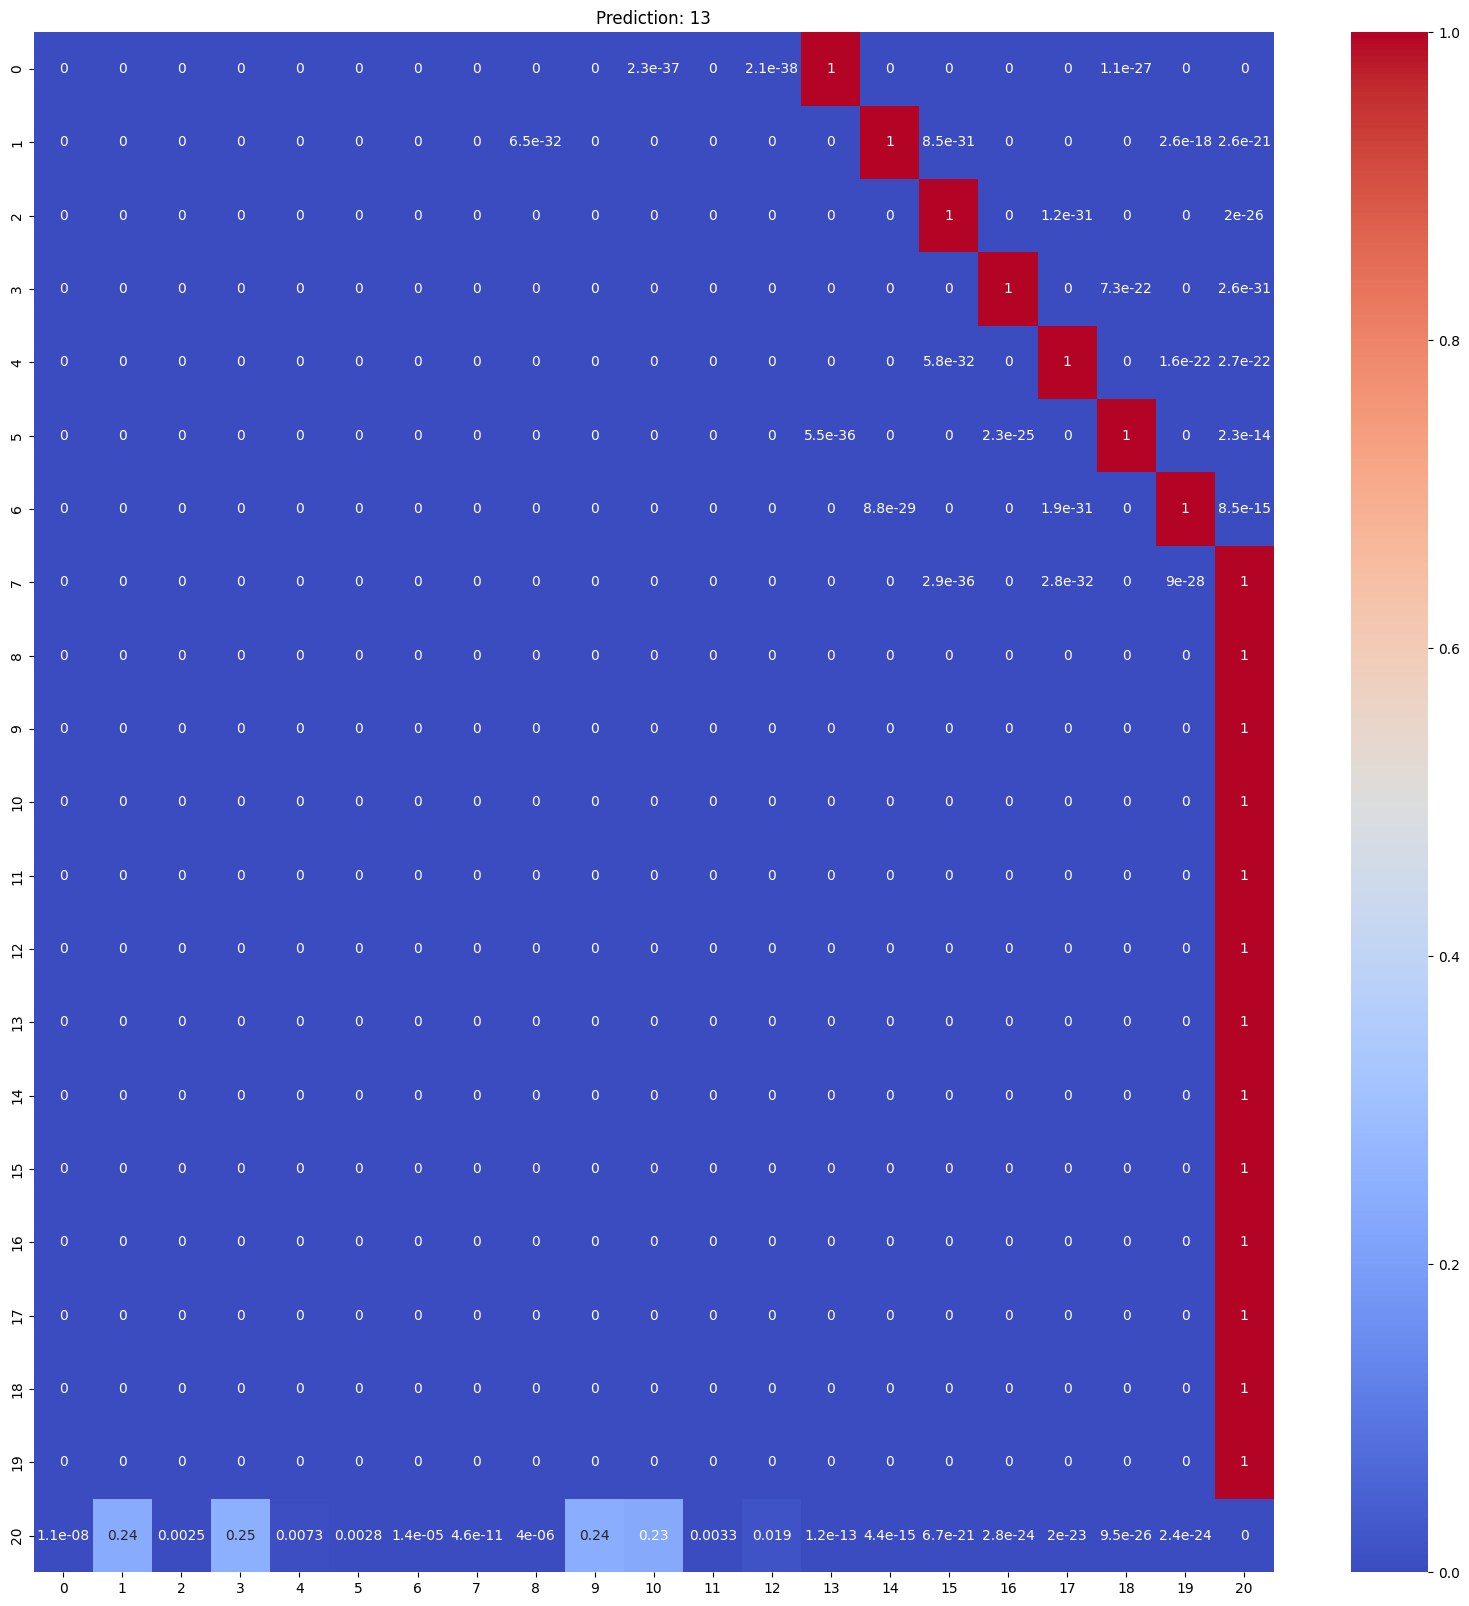

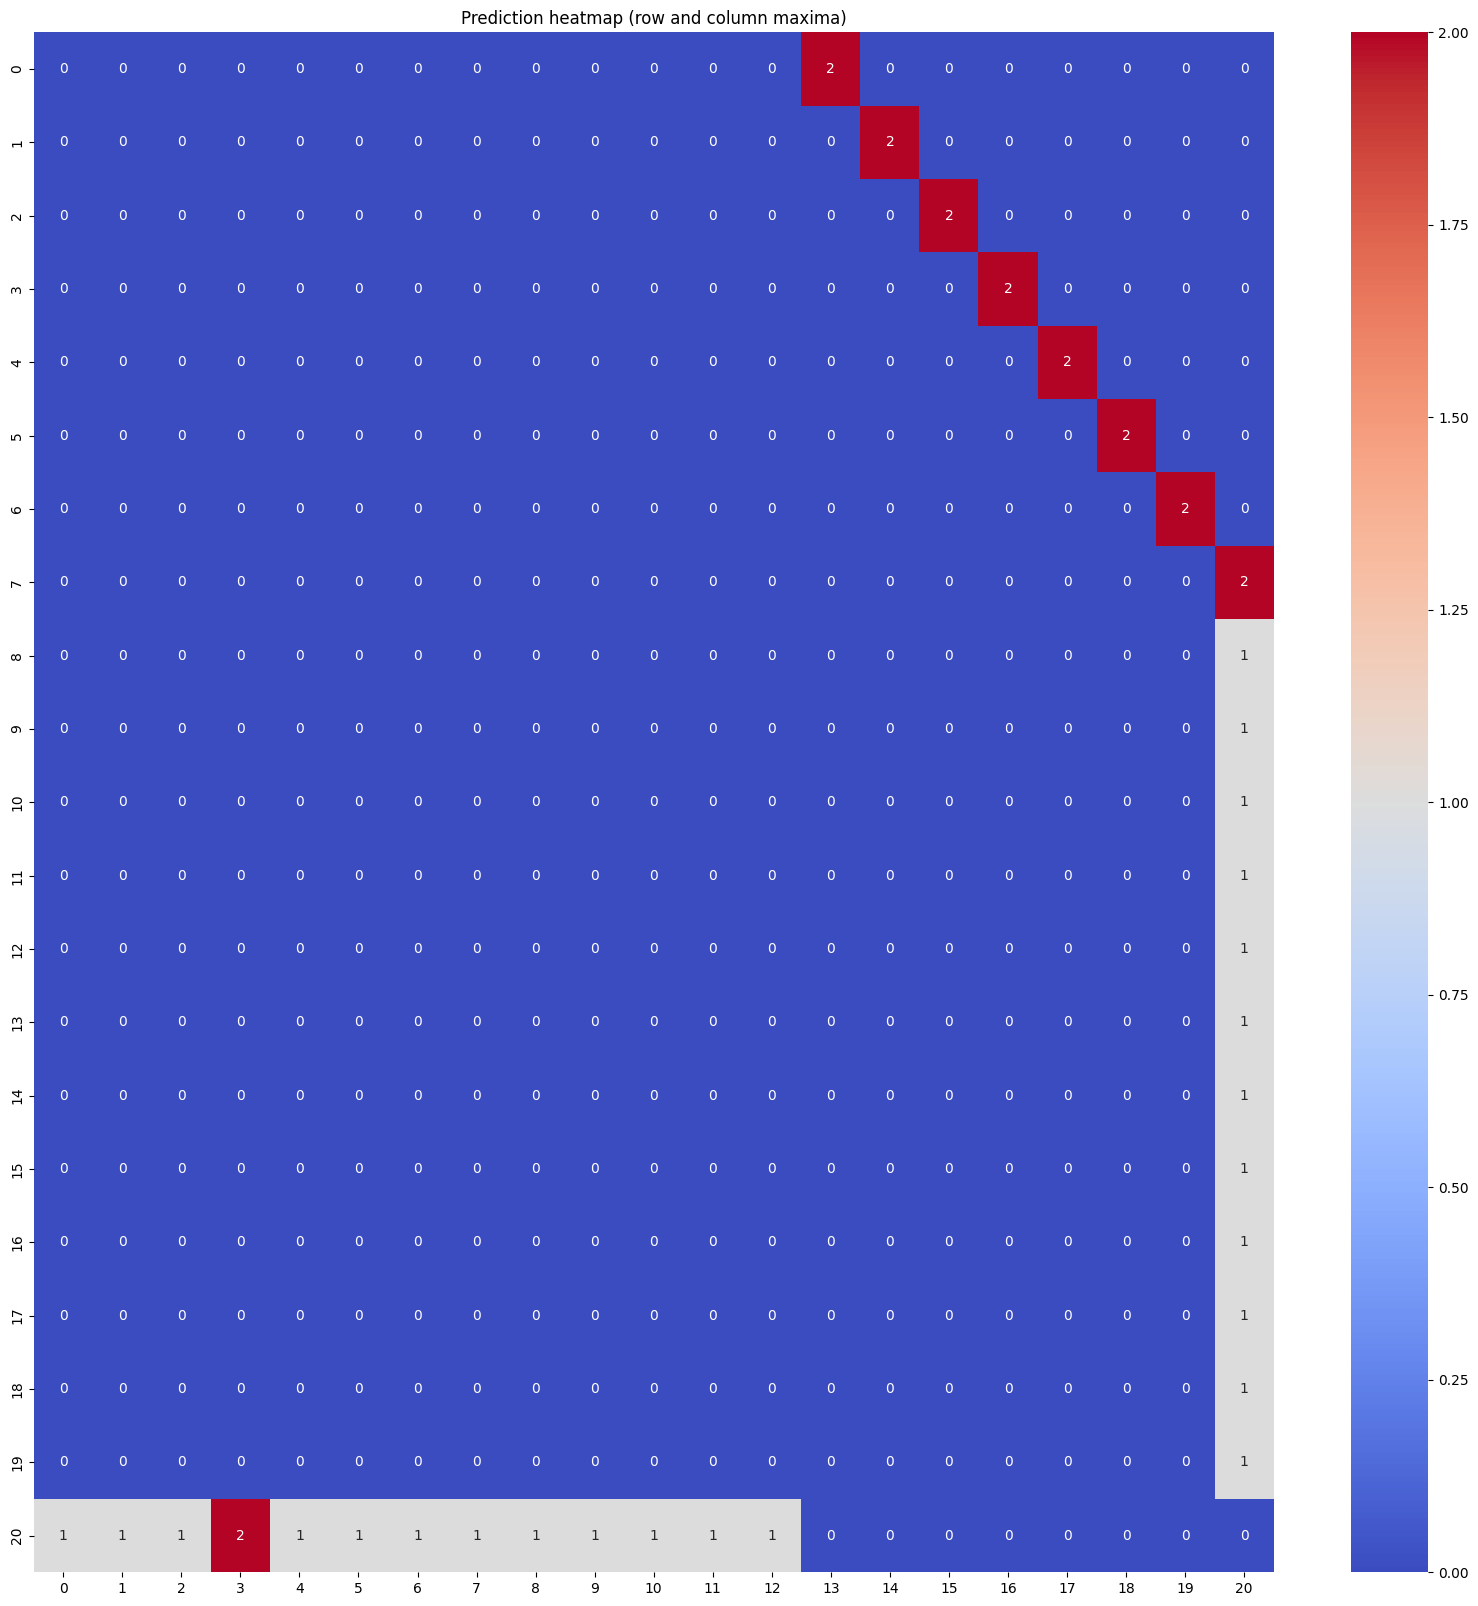

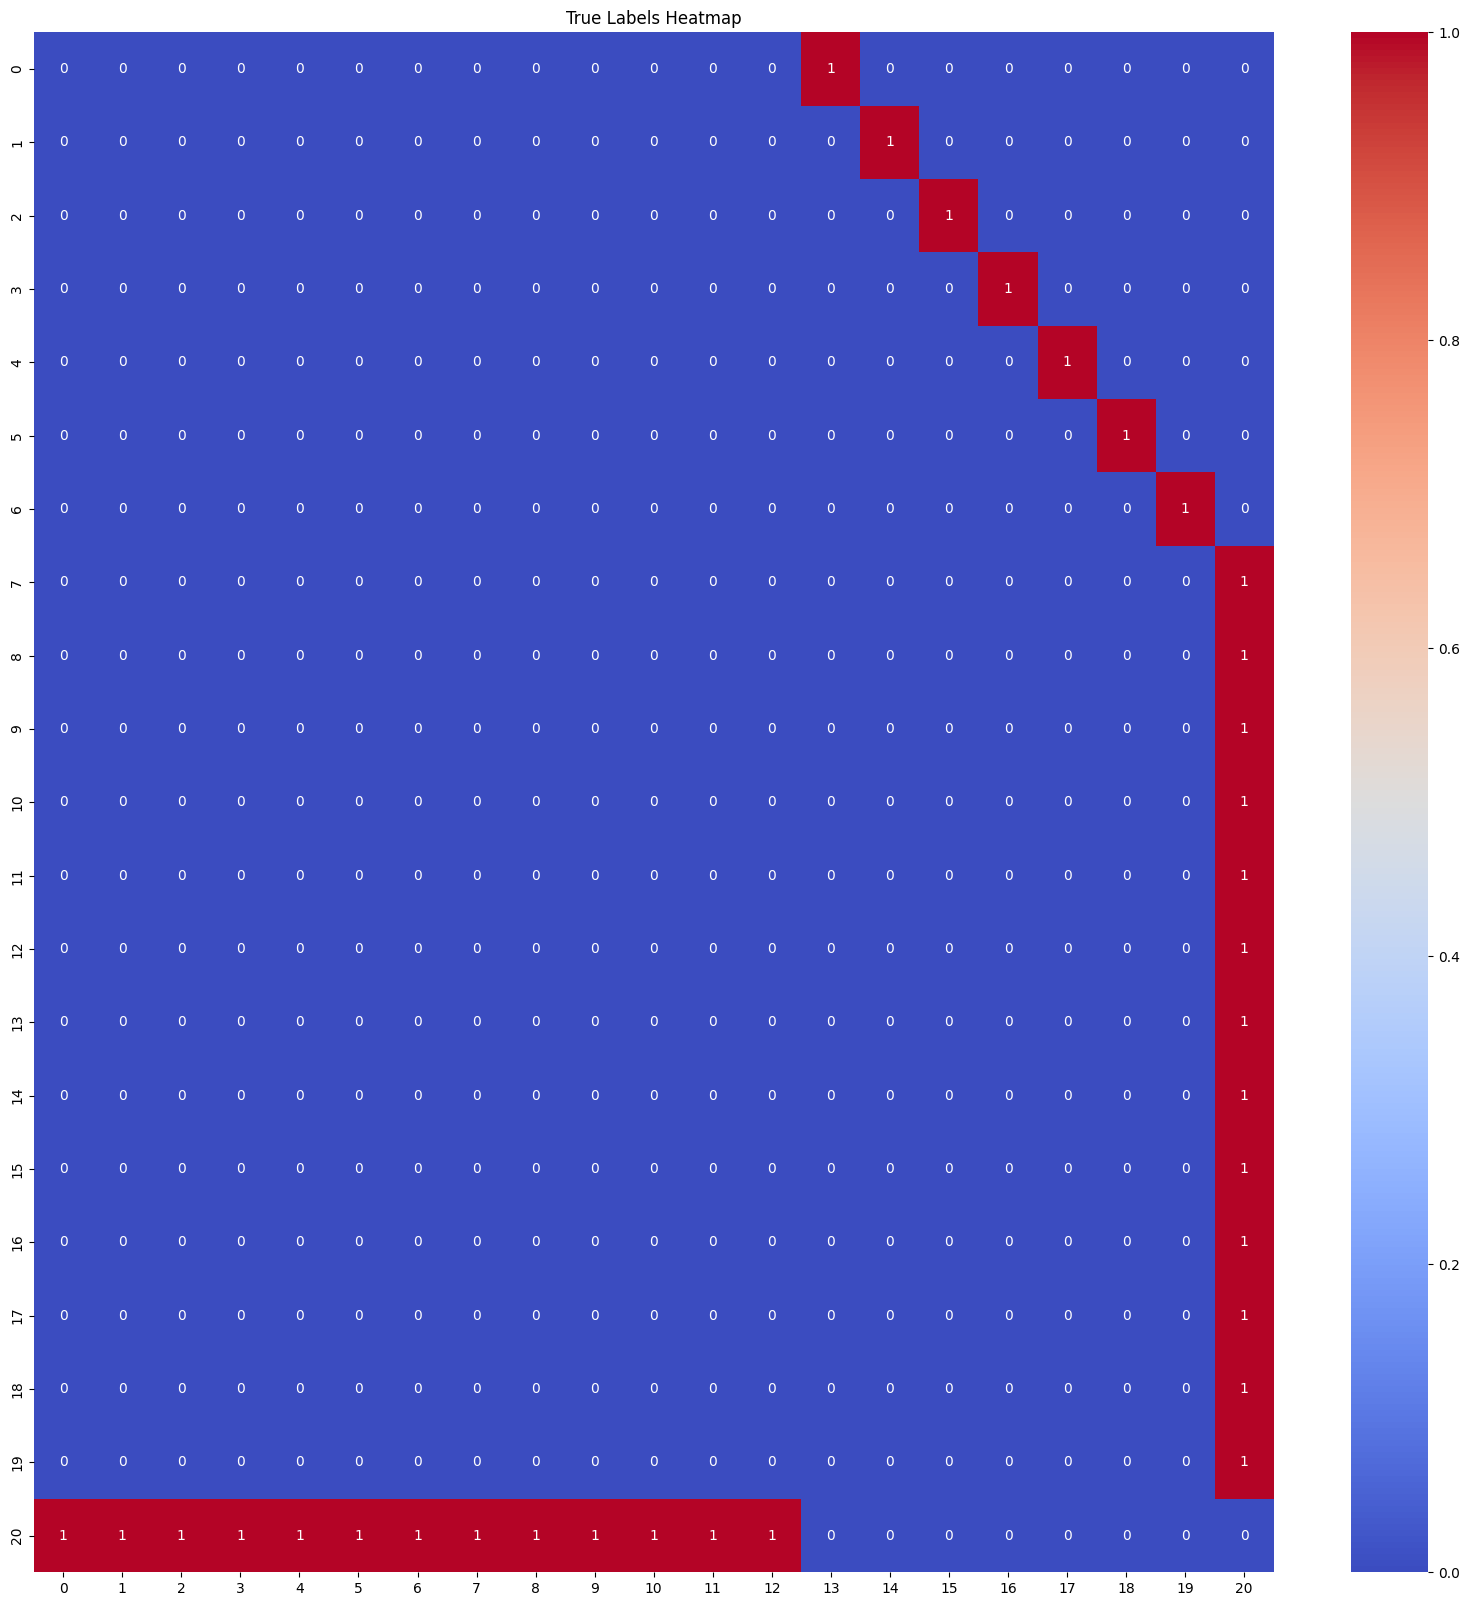


Heatmap visualization for first prediction:


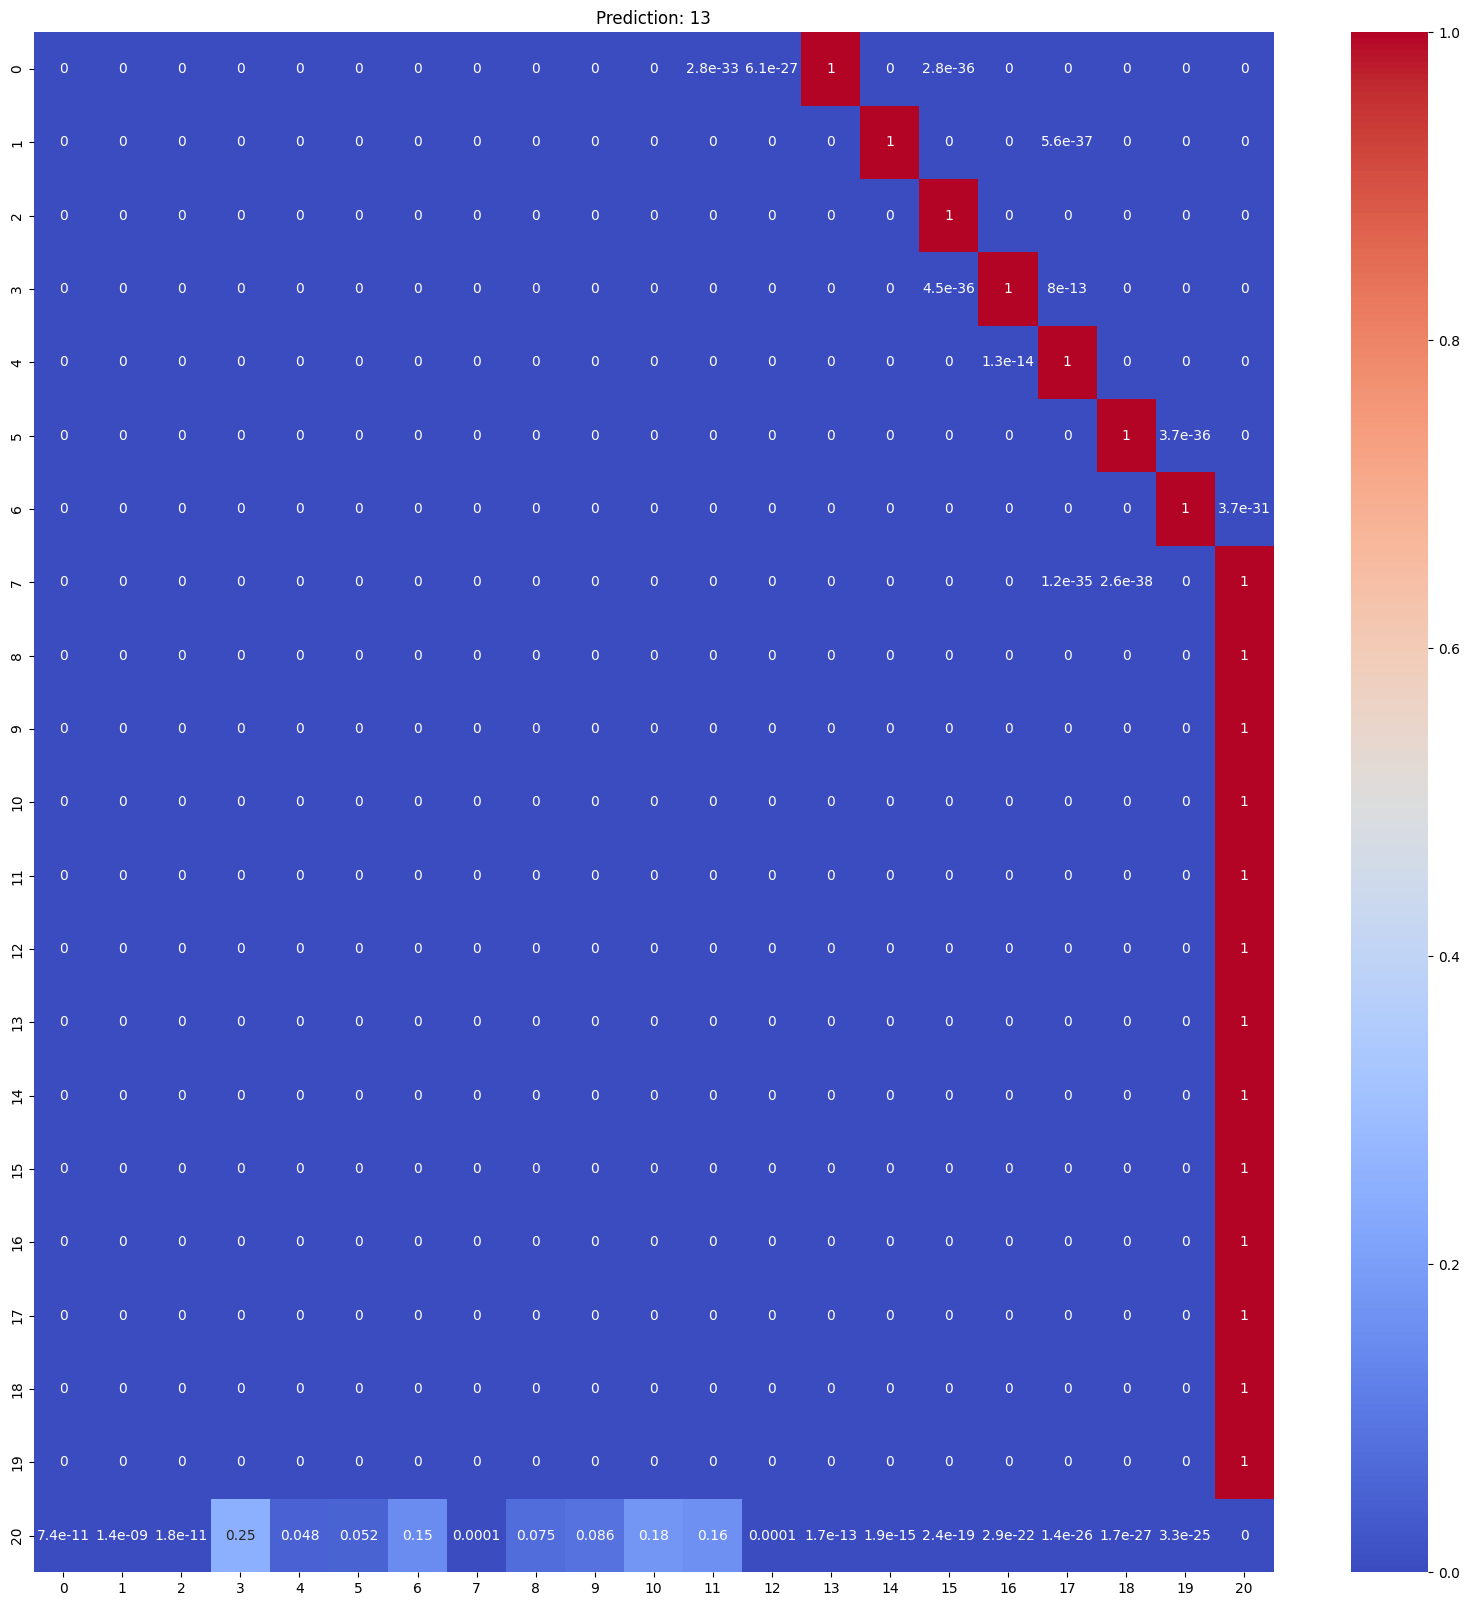

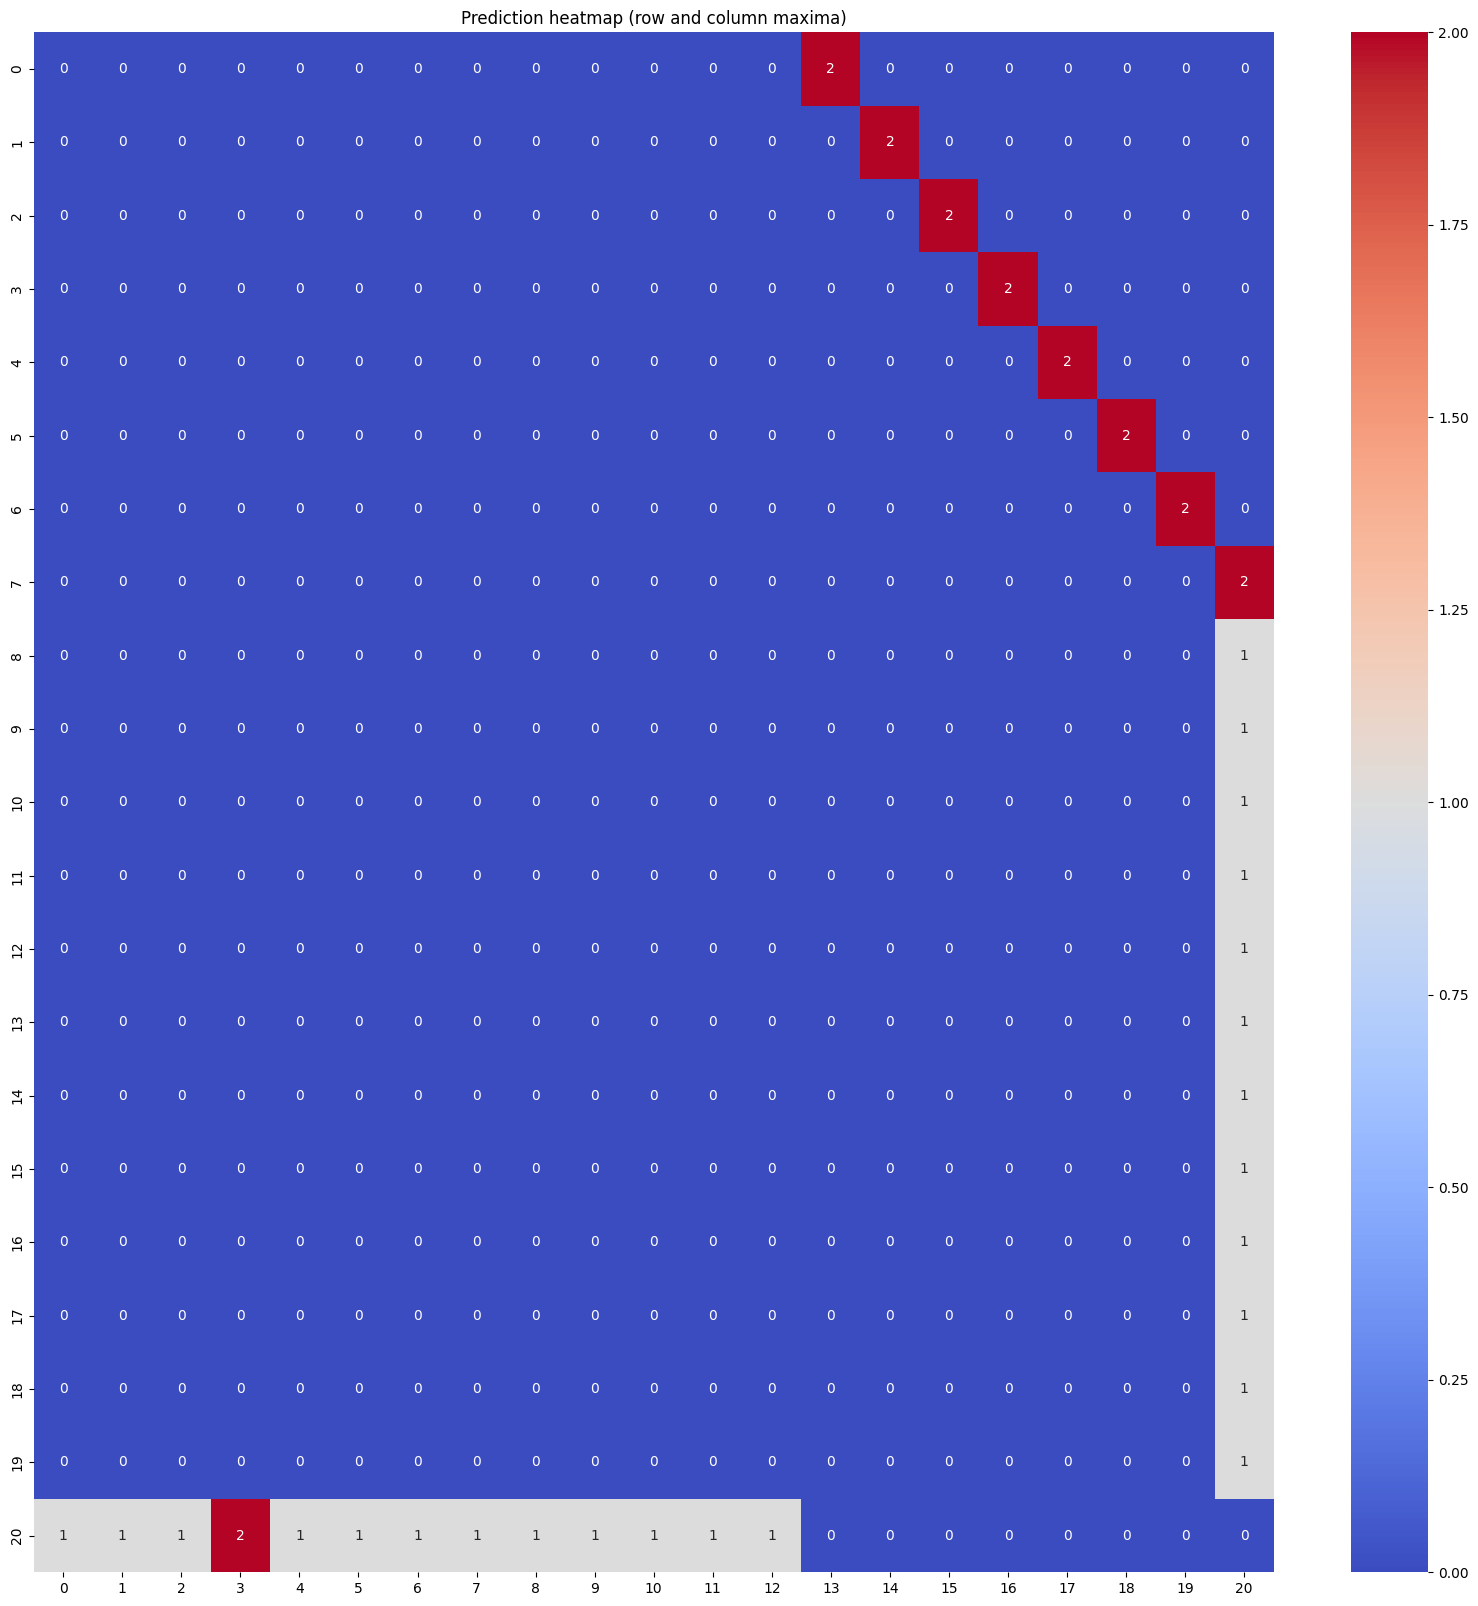

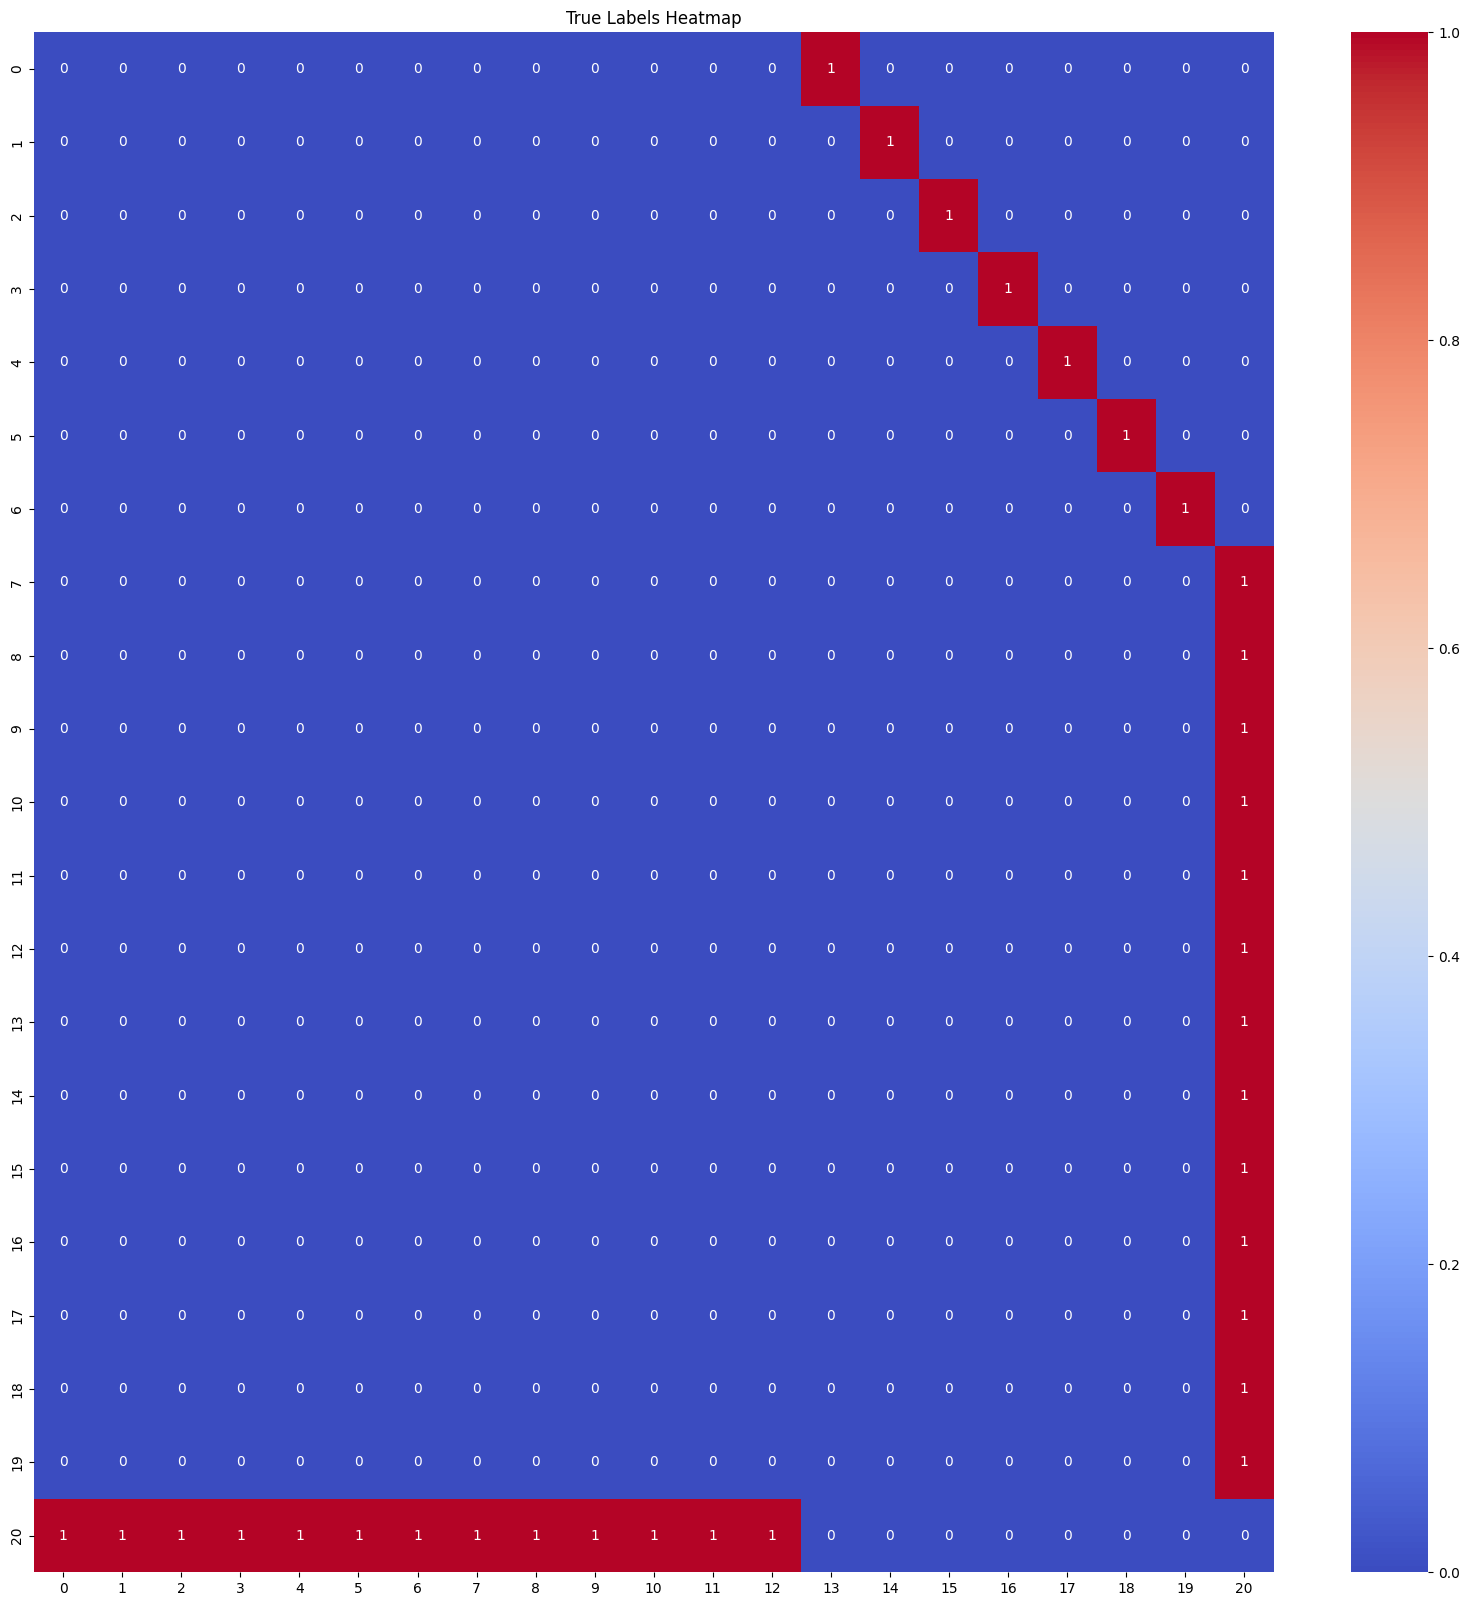

In [17]:
model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

model.predict(
    feature_loc,
    weight_name= weight_name,
    video_pair= "12_02, 12_03",
    output_path= f"/home/jireh/MT/video_sync_v1/trash/output_test")


In [4]:
# Instantiate the model
num_heads = 4 # 8,4,1
embed_dim = 48  # 768  48
num_layers = 1 # 4,2,1
lr = 1e-3
len_video = 20
# weight_name = f'weights_swin1_{num_heads}_{num_layers}.h5'
weight_name = 'weights_v4_1_4_1_best.h5'

print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}", sep="\n")
print(f"Learning rate: {lr}", f"Weight name: {weight_name}", sep="\n")
print(f"Video length:{len_video}")

# extracted feature
feature_loc = f"/home/jireh/MT/video_sync_v1/trash/featureData_len20_3.npy"
trainDS = np.load(feature_loc,allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
df.head()

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 1
Learning rate: 0.001
Weight name: weights_v4_1_4_1_best.h5
Video length:20
(20, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 2.178669, 0.0, 0.0, 0.0, 0.74...","[[0.0, 0.0, 0.0, 1.6267416, 0.0, 0.0, 0.0, 1.2...",533,539,6
1,"[[0.0, 0.0, 0.0, 1.6839604, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.4445367, 0.0, 0.0, 0.0, 0.0...",7331,7327,-4
2,"[[0.0, 0.0, 0.0, 2.3283625, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.179996, 0.0, 0.0, 0.0, 0.0,...",4825,4827,2
3,"[[0.0, 0.0, 0.0, 2.606518, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.8846723, 0.0, 0.0, 0.0, 0.1...",3127,3109,-18
4,"[[0.0, 0.0, 0.0, 1.8806056, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.5946232, 0.0, 0.0, 0.0, 0.0...",5374,5371,-3


Model initialized. Starting predictions...
weights loaded: weights_v4_1_4_1_best.h5

Final predictions after training:
Predicted: [6, -4, 2, -18, -3, 19, 0, 9, 16, 0, 0, -11, -6, 4, -6, -6, 16, 7, -16, 6, 4, 13, 5, -12, -7, 9, 8, 0, -5, 17]
True: [6, -4, 2, -18, -3, 19, 0, 9, 16, 0, 0, -11, -6, 4, -6, -6, -18, 7, -16, 6, 4, 13, 5, -12, -7, 9, 8, 0, -5, 17]
Accuracy in total: 0.943359375
F1 score: 0.943359375
Mean Absolute Error: 1.075262661637931

Heatmap visualization for first prediction:


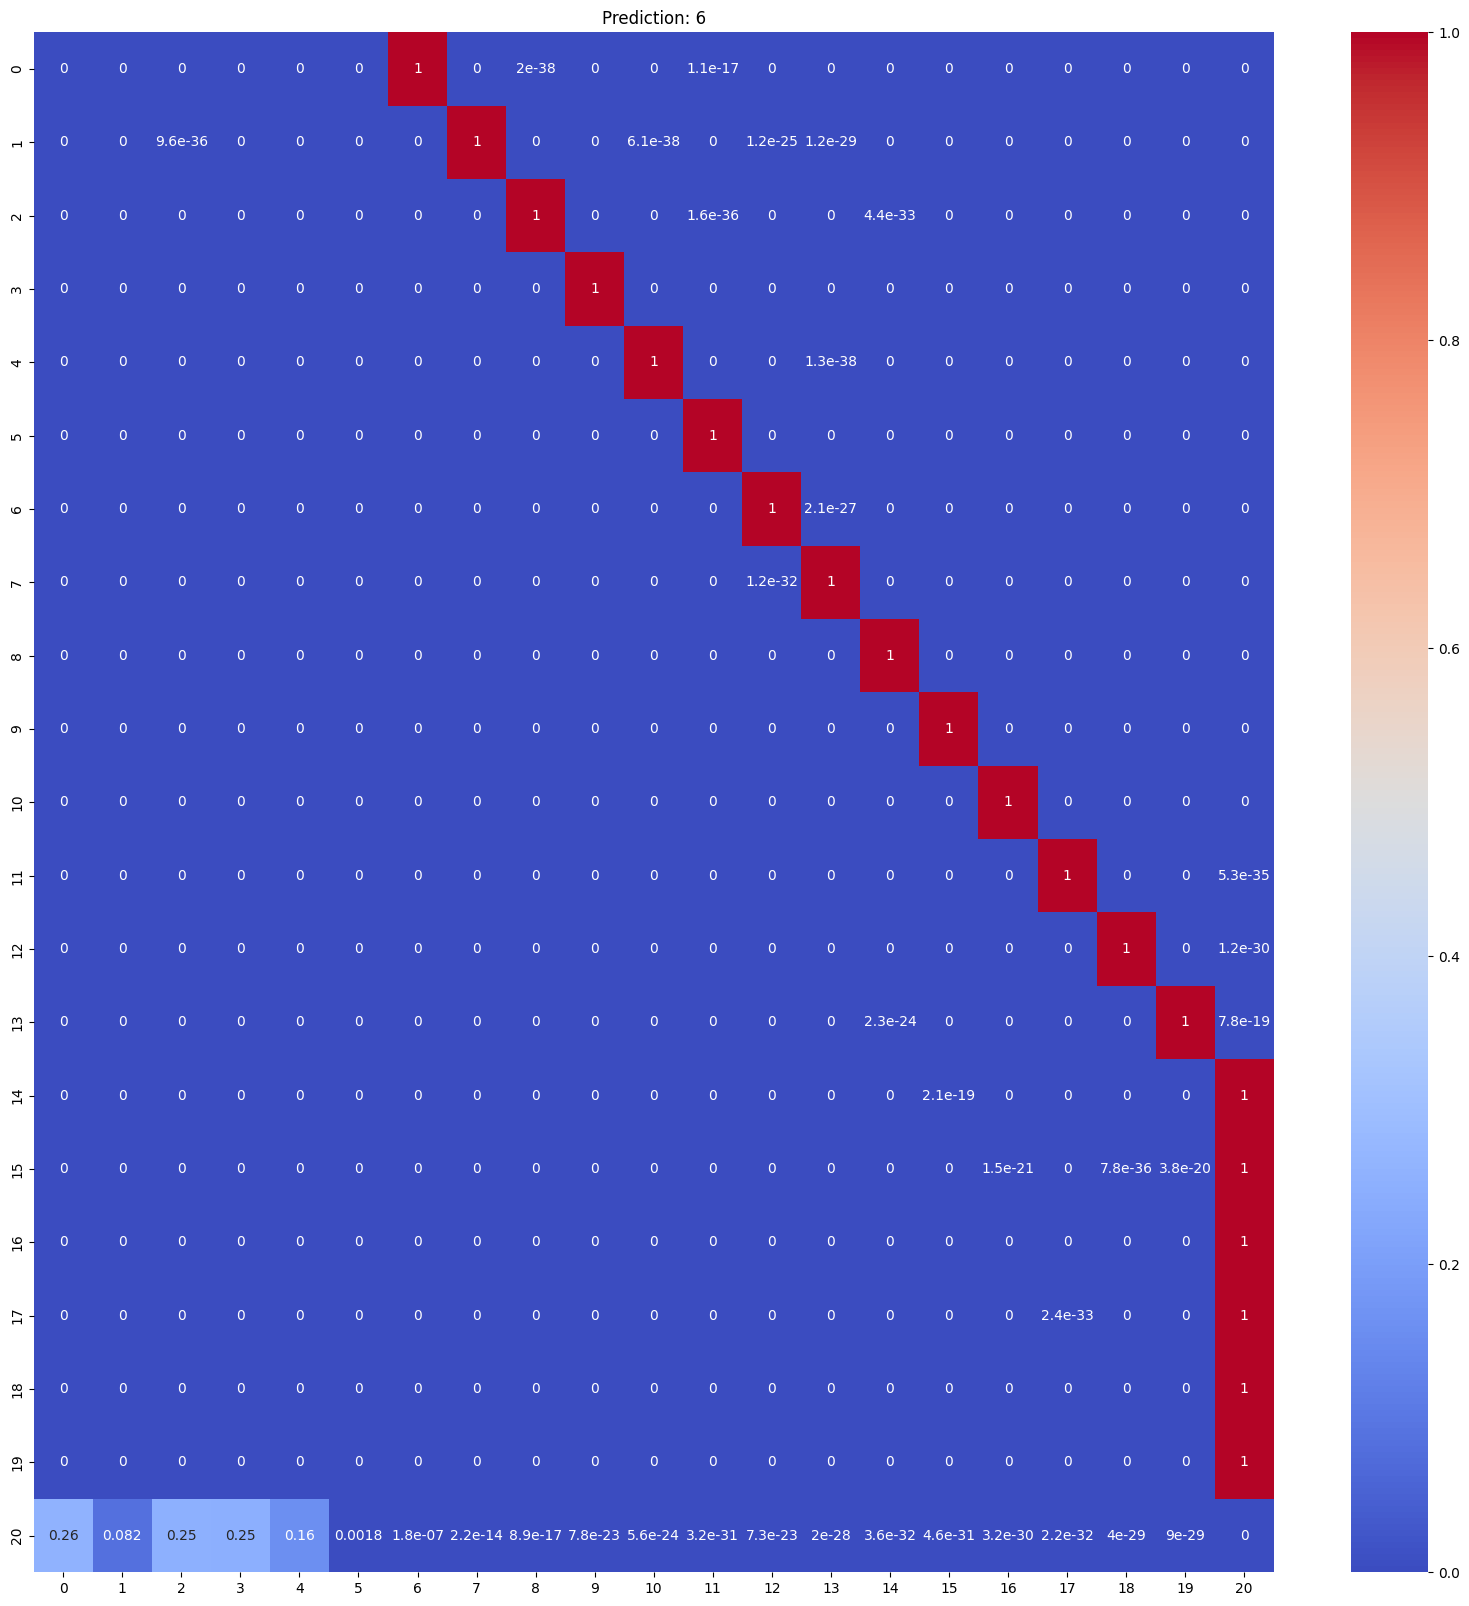

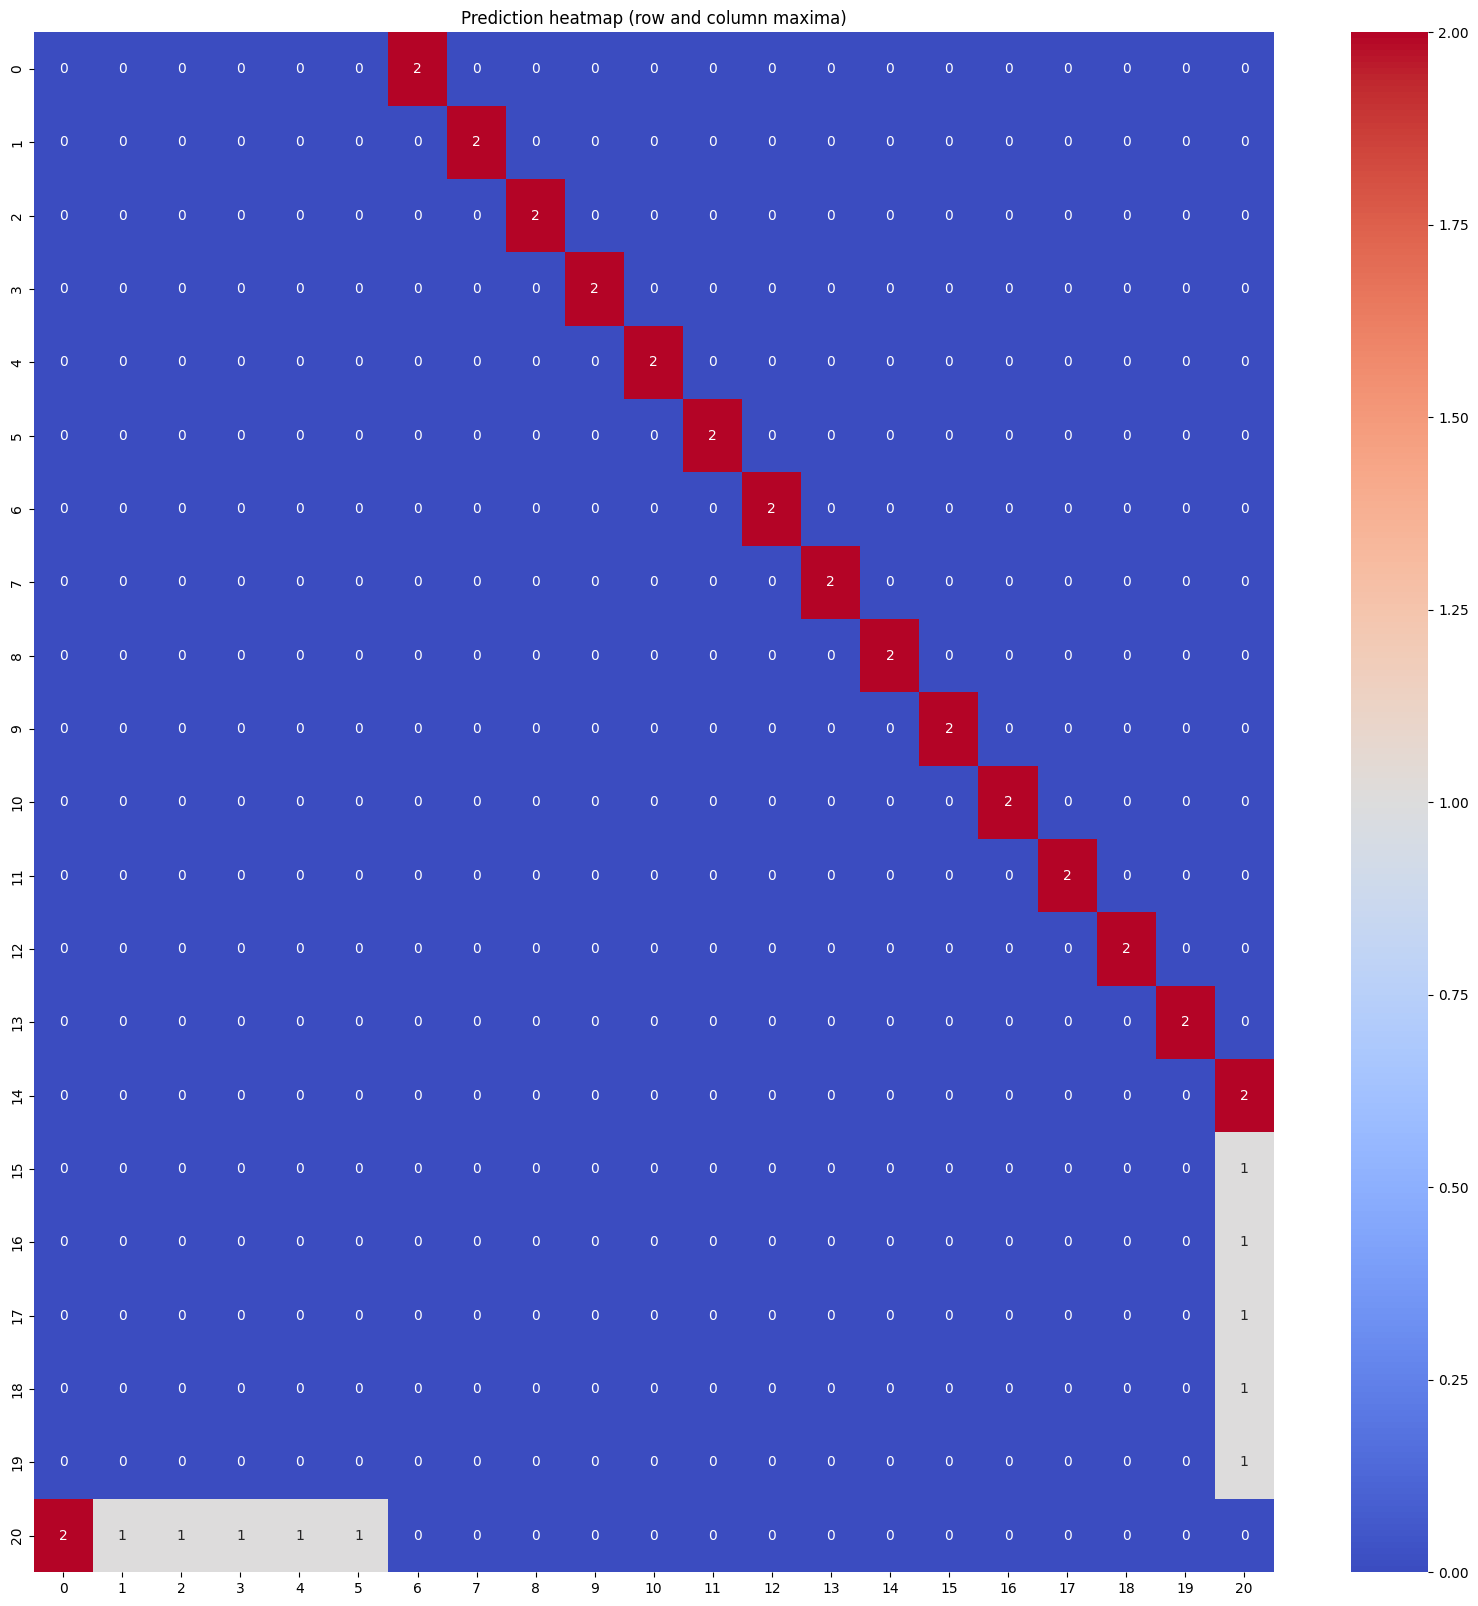

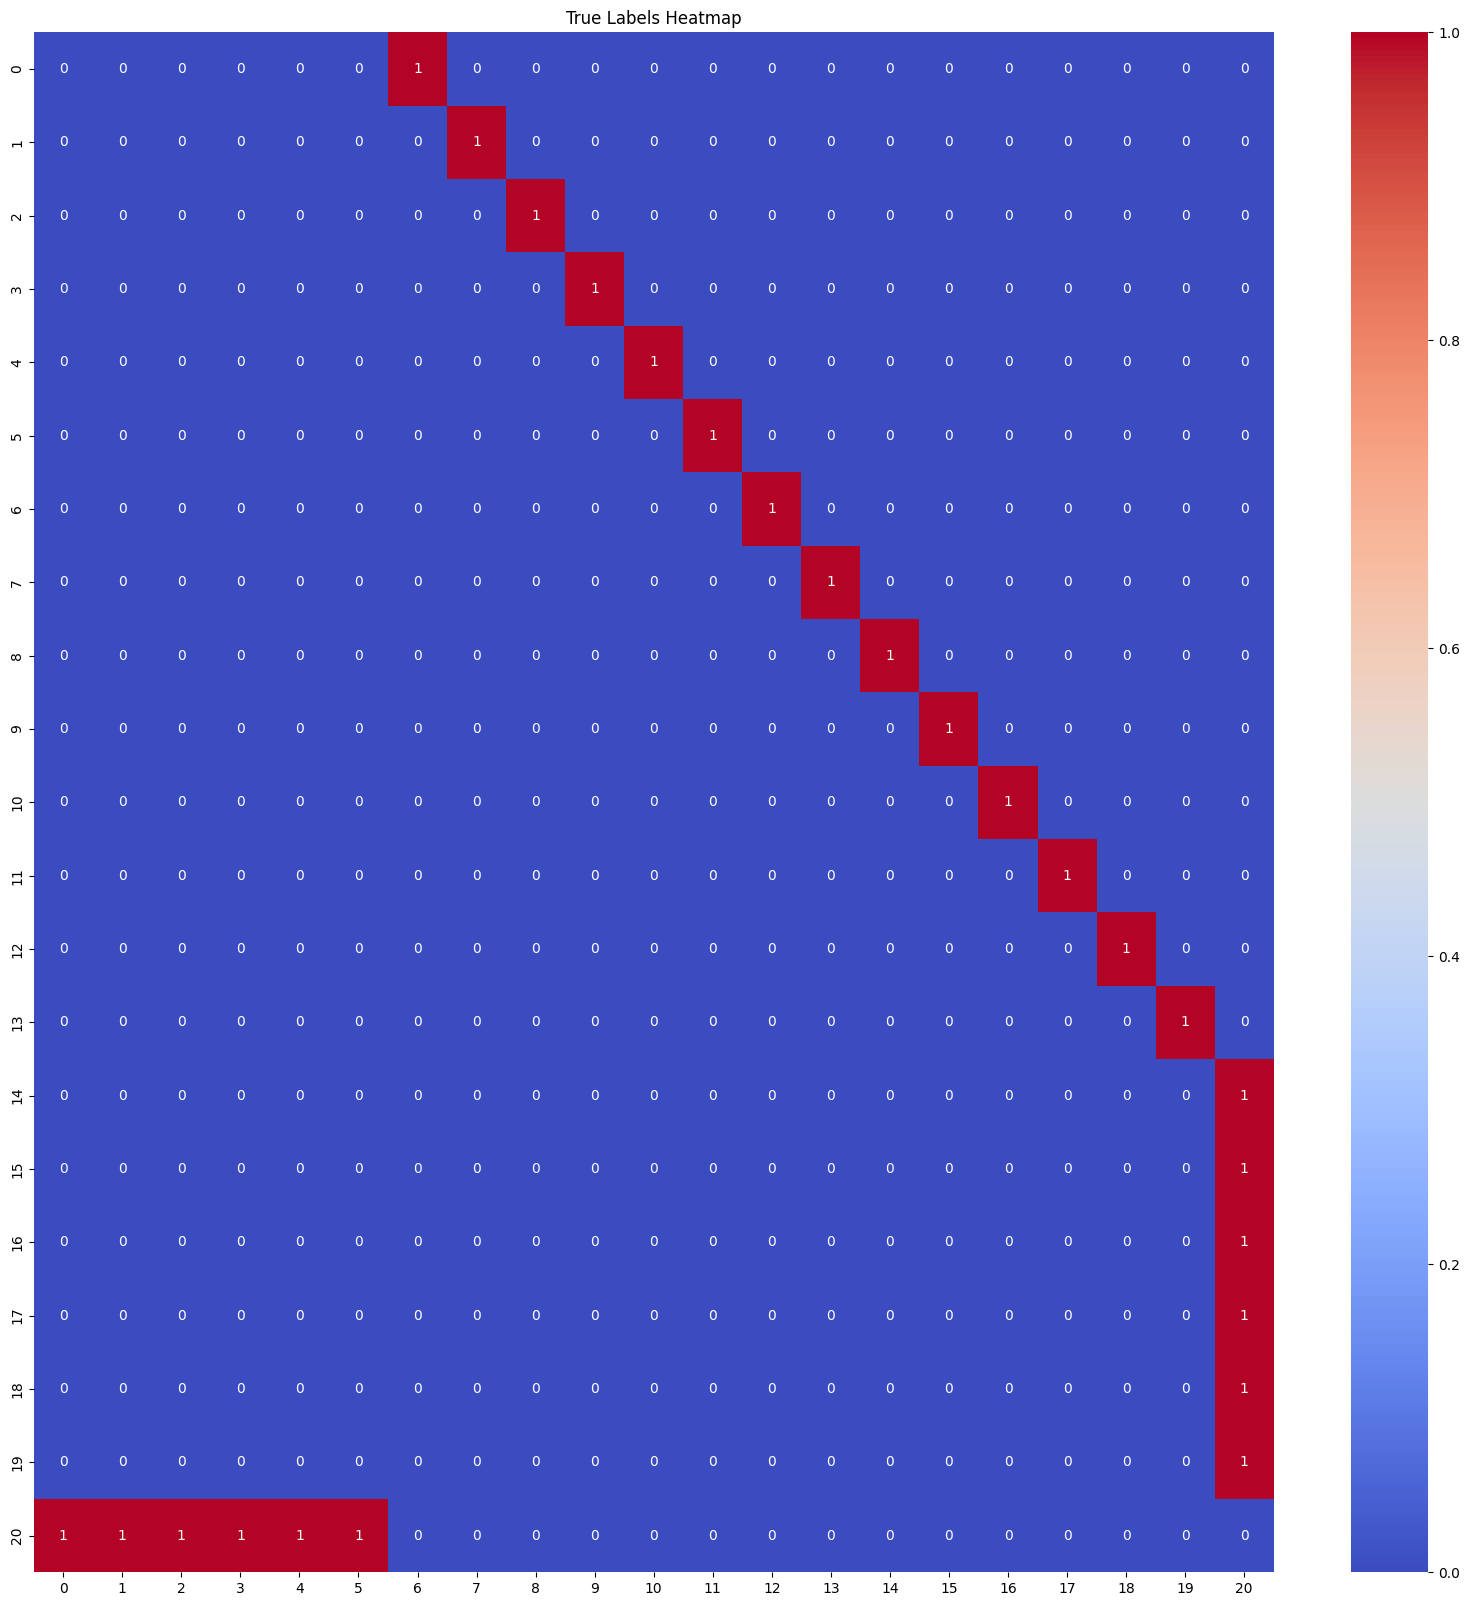


Heatmap visualization for first prediction:


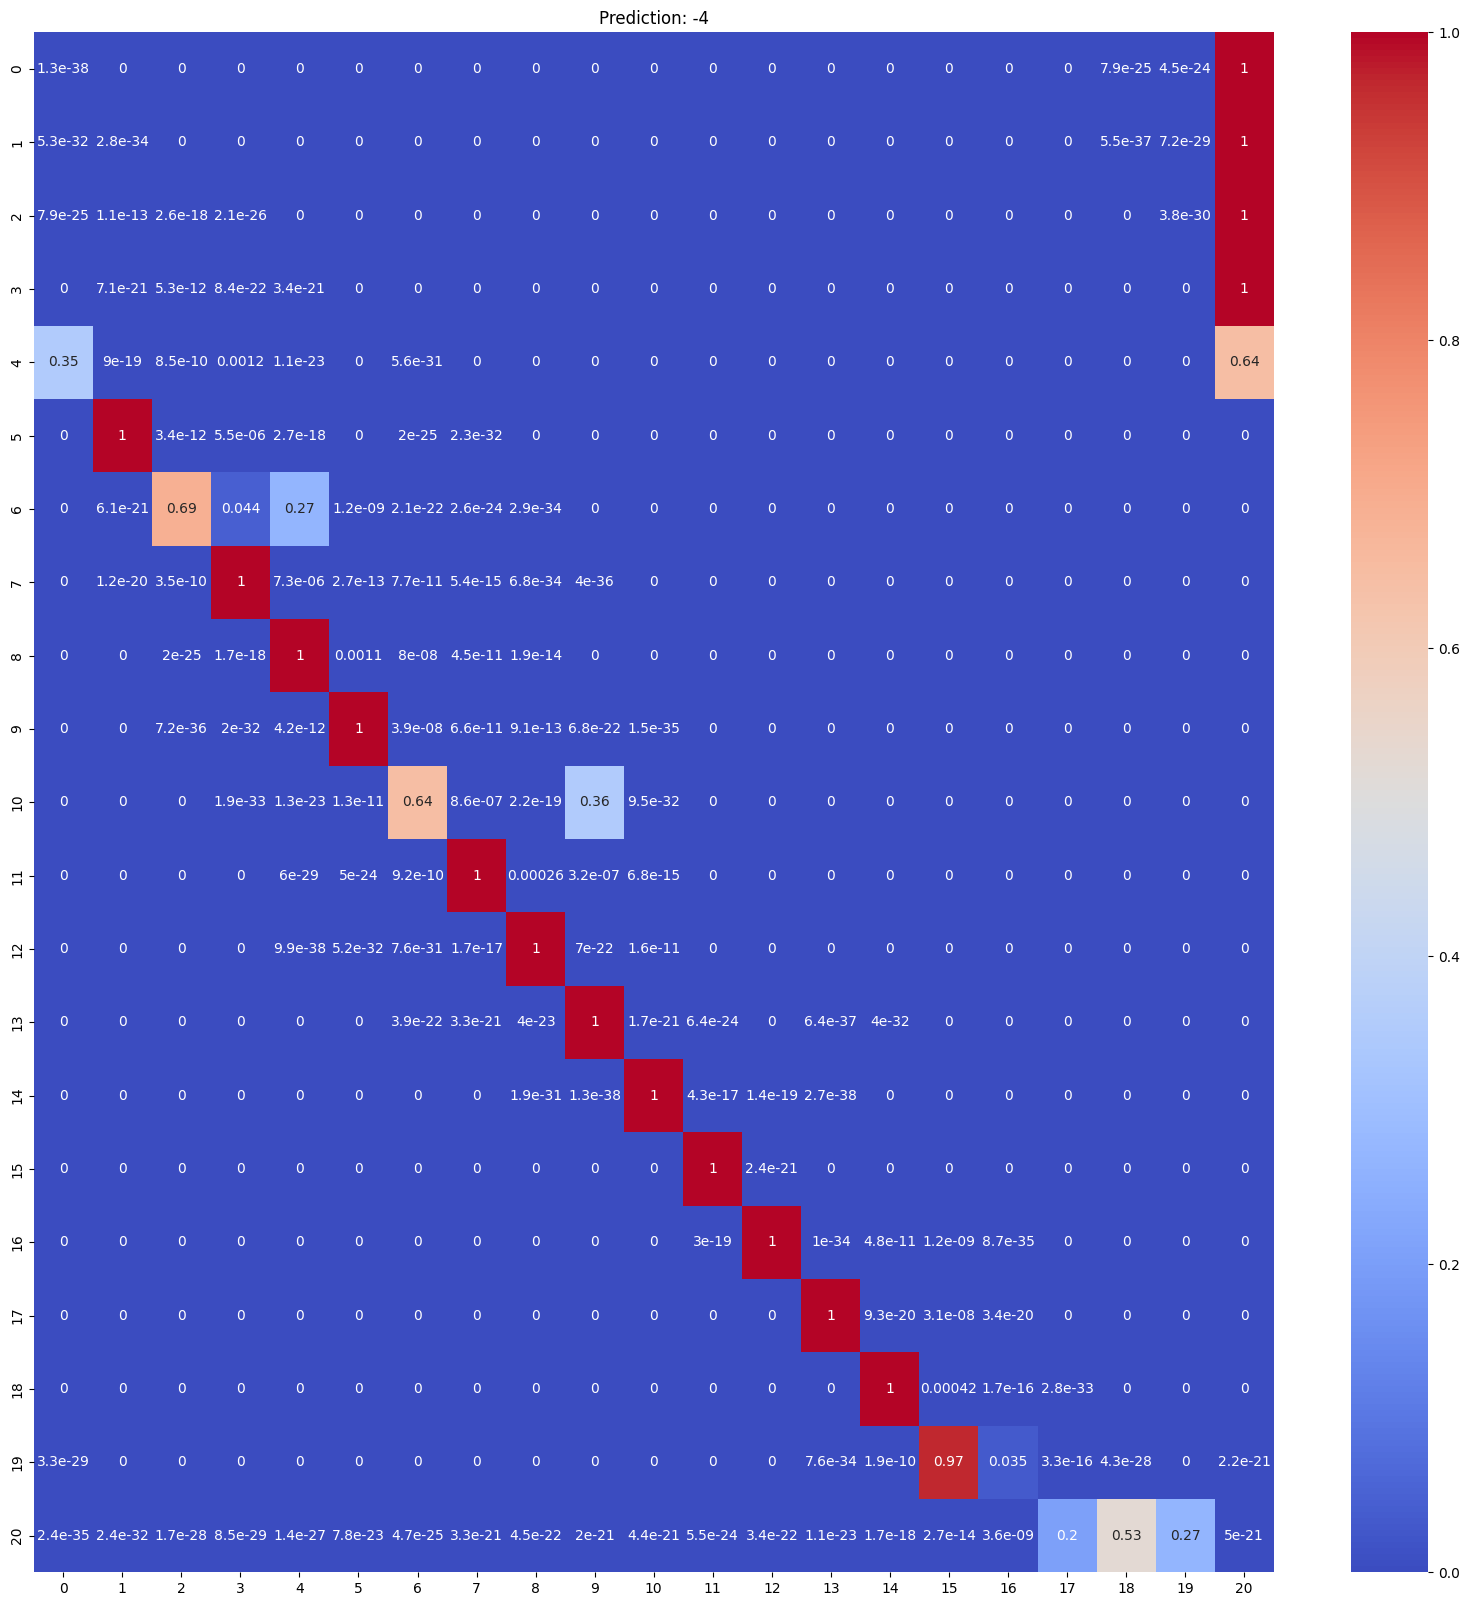

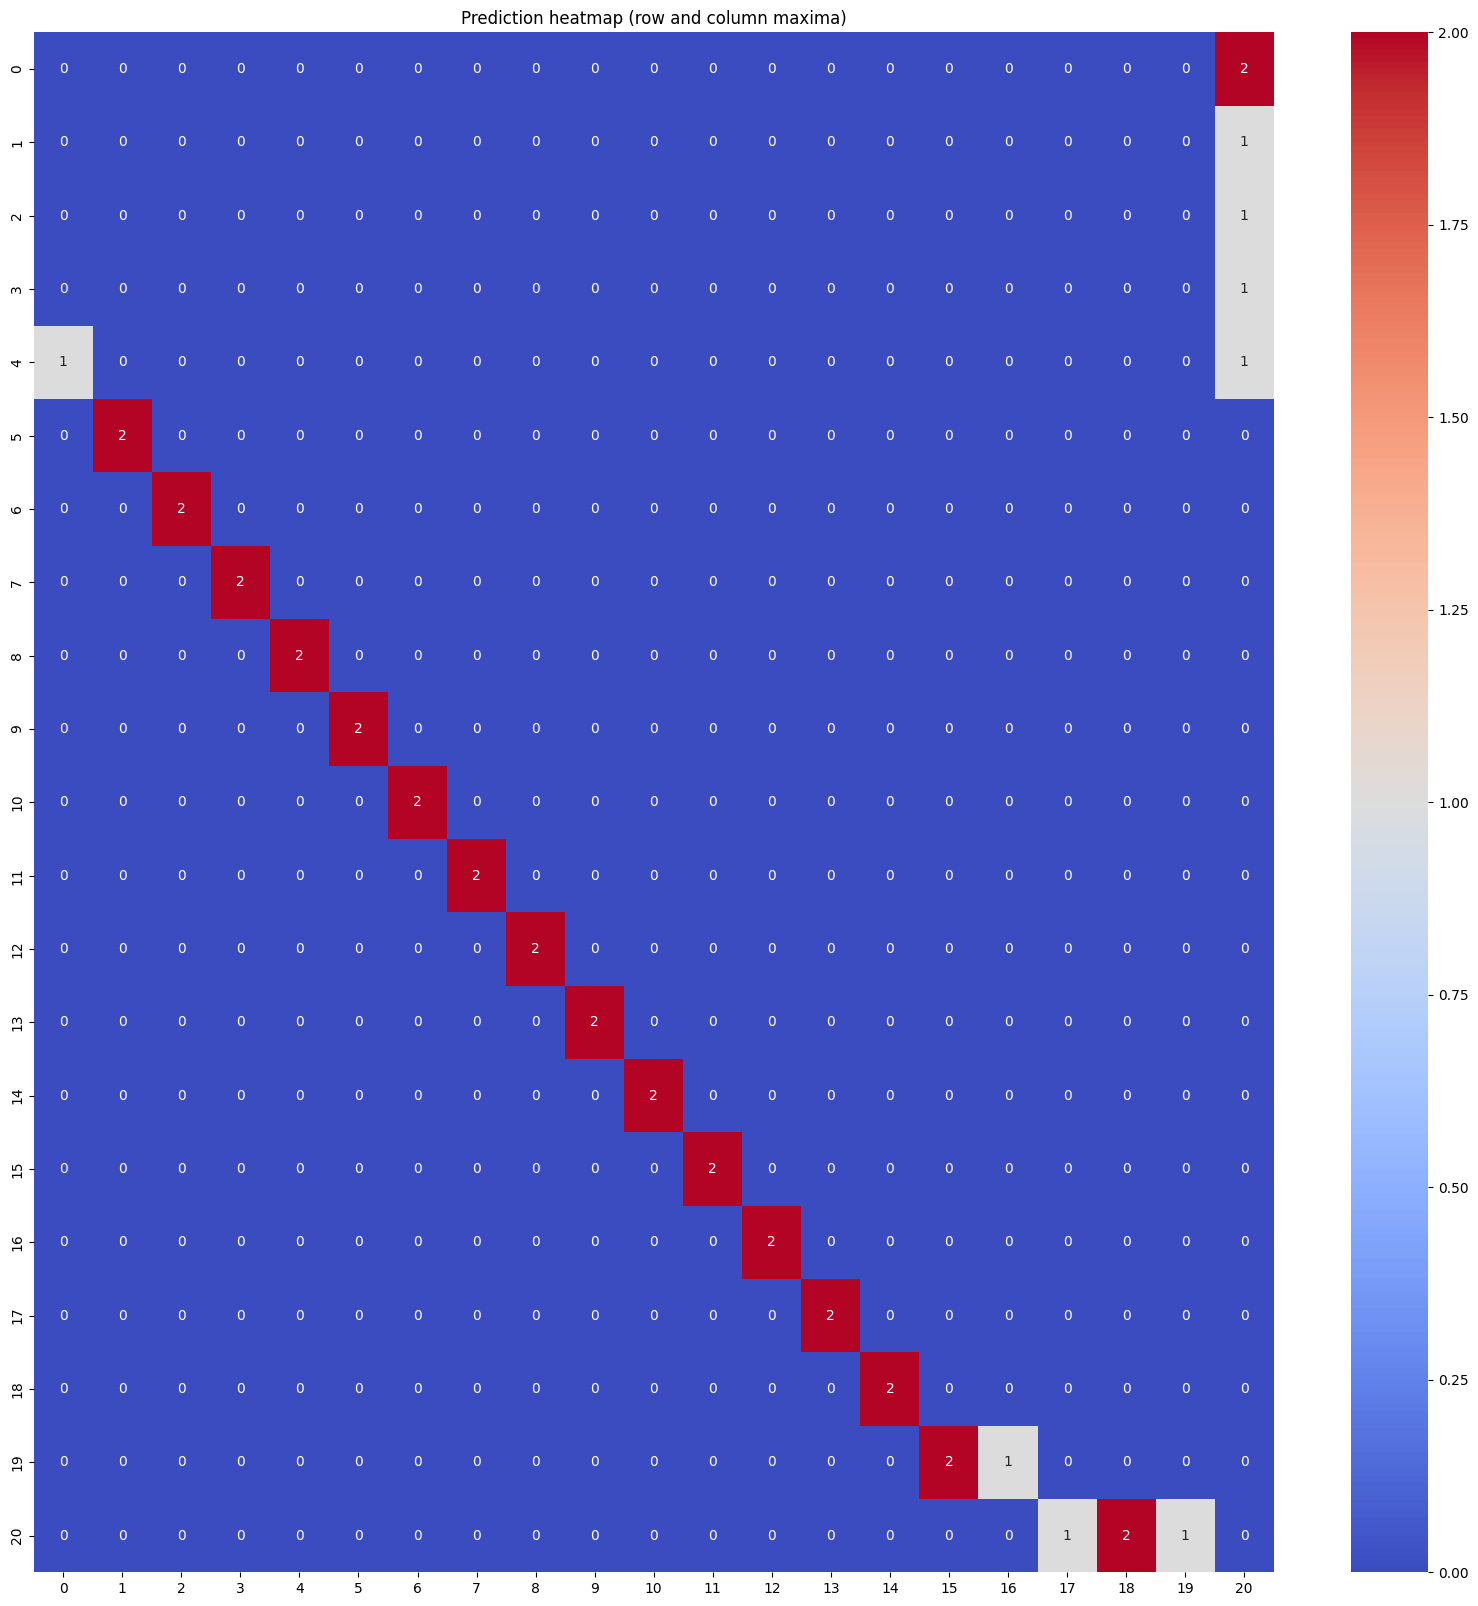

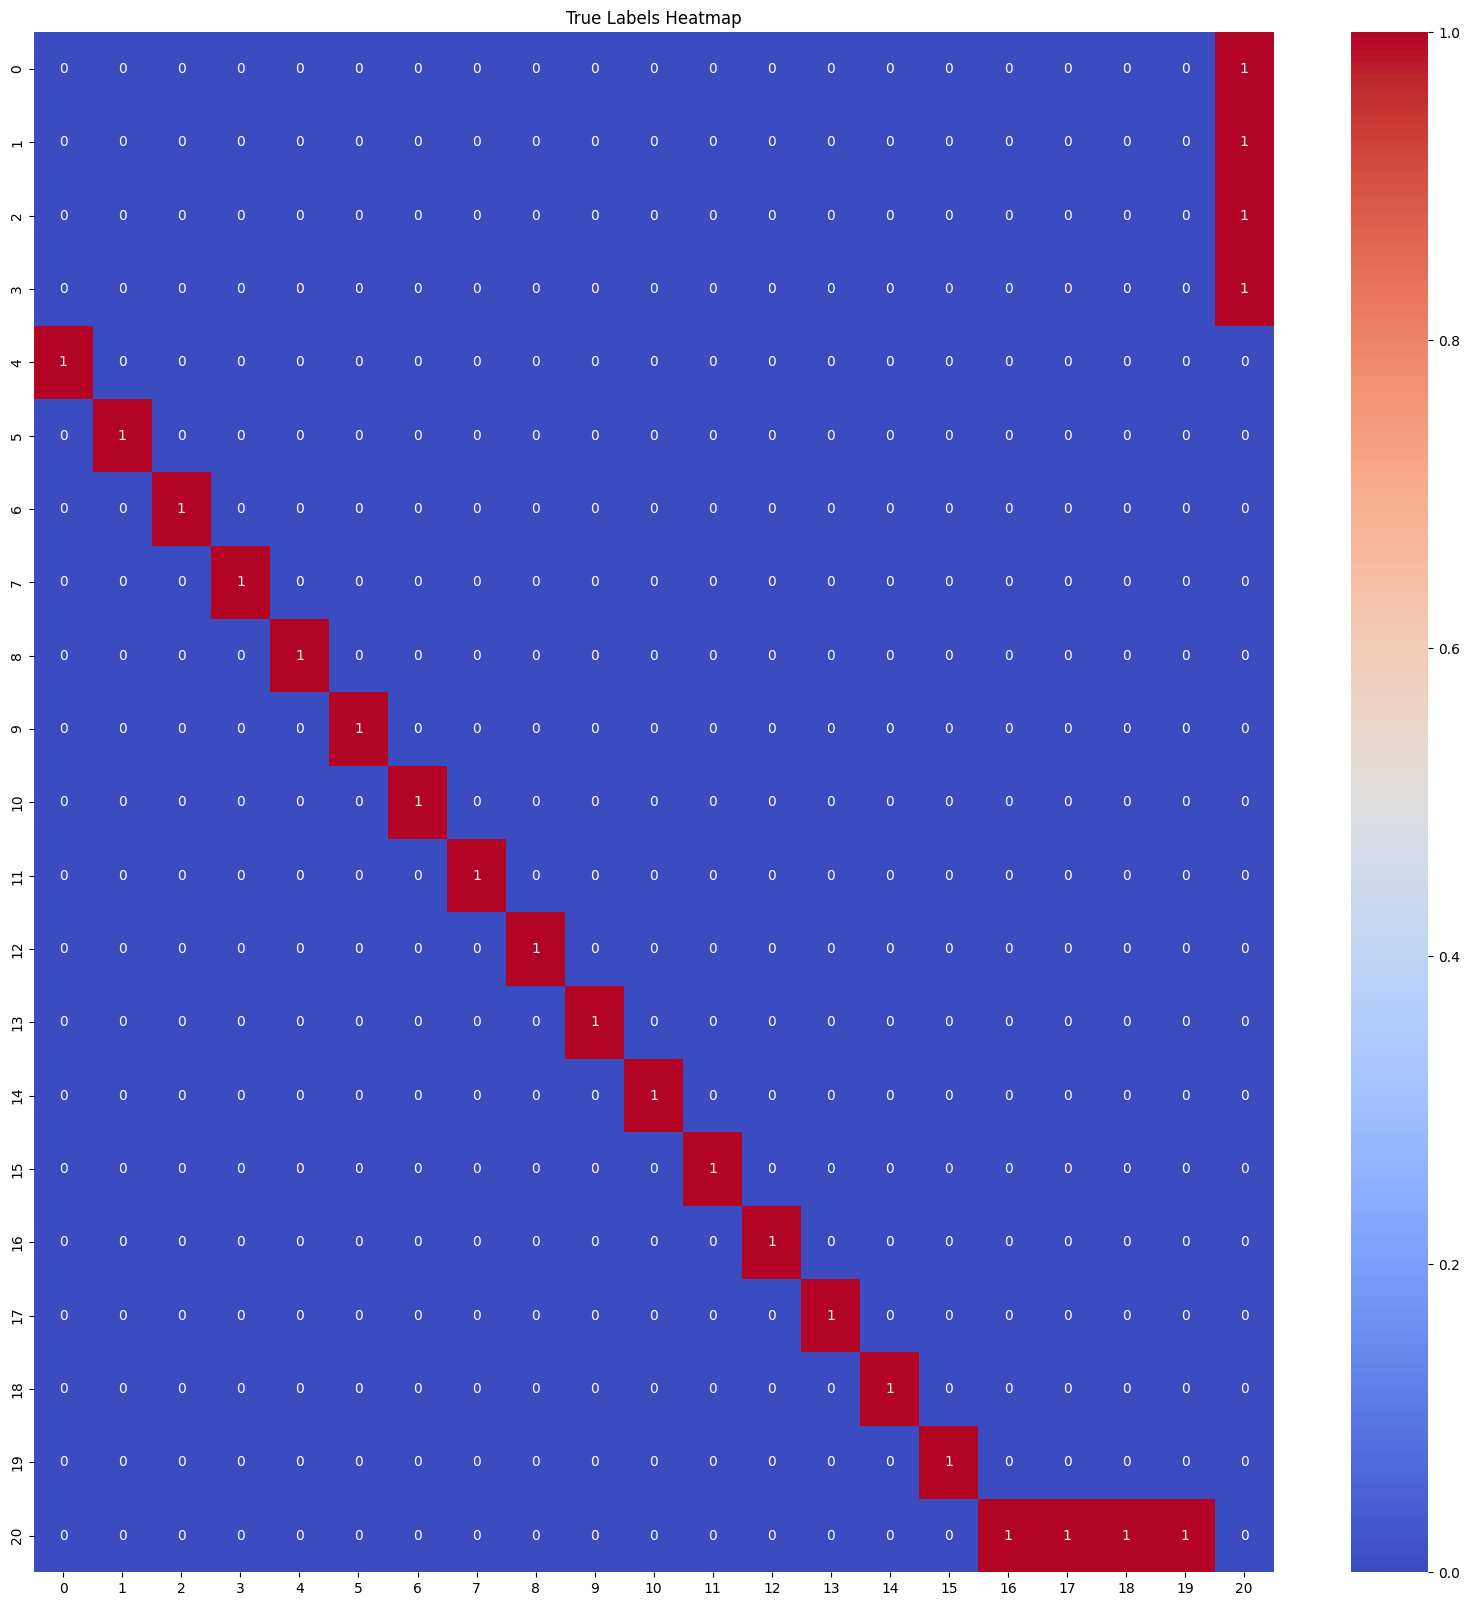

In [19]:
model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

model.predict(
    feature_loc,
    weight_name= weight_name,
    video_pair= "12_02, 12_03",
    output_path= f"/home/jireh/MT/video_sync_v1/trash/output_test")


In [5]:
# Instantiate the model
num_heads = 4 # 8,4,1
embed_dim = 48  # 768  48
num_layers = 1 # 4,2,1
lr = 1e-3
len_video = 20
# weight_name = f'weights_swin1_{num_heads}_{num_layers}.h5'
weight_name = 'weights_v4_1_4_1_best.h5'

print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}", sep="\n")
print(f"Learning rate: {lr}", f"Weight name: {weight_name}", sep="\n")
print(f"Video length:{len_video}")

# extracted feature
feature_loc = f"/home/jireh/MT/video_sync_v1/trash/featureData_len20_4.npy"
trainDS = np.load(feature_loc,allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
df.head()

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 1
Learning rate: 0.001
Weight name: weights_v4_1_4_1_best.h5
Video length:20
(20, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 1.303575, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.6073904, 0.0, 0.0, 0.0, 0.0...",7595,7595,0
1,"[[0.0, 0.0, 0.0, 1.928269, 0.0, 0.0, 0.0, 0.03...","[[0.0, 0.0, 0.0, 0.822452, 0.0, 0.0, 0.0, 0.47...",3694,3713,19
2,"[[0.0, 0.0, 0.0, 1.5181829, 0.0, 0.0, 0.0, 0.2...","[[0.0, 0.0, 0.0, 2.3139734, 0.0, 0.0, 0.0, 0.0...",2542,2538,-4
3,"[[0.0, 0.0, 0.0, 1.3733754, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.6181996, 0.0, 0.0, 0.0, 0.4...",8900,8886,-14
4,"[[0.0, 0.0, 0.0, 1.8404247, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.3677328, 0.0, 0.0, 0.0, 0.2...",5167,5166,-1


Model initialized. Starting predictions...
weights loaded: weights_v4_1_4_1_best.h5

Final predictions after training:
Predicted: [0, 13, -4, -14, -1, -17, 8, -2, -16, -15, 4, -8, -11, -2, 17, 0, -4, -2, 17, -16, 7, 4, 13, -14, 7, -6, 15, 18, 8, 2]
True: [0, 19, -4, -14, -1, -17, 8, -2, -16, -15, 4, -8, -11, -2, 19, 0, -4, -2, -20, -16, 7, 4, 13, -14, 7, -6, 15, 18, 8, 2]
Accuracy in total: 0.9377693965517241
F1 score: 0.9377693965517241
Mean Absolute Error: 1.1645339439655173

Heatmap visualization for first prediction:


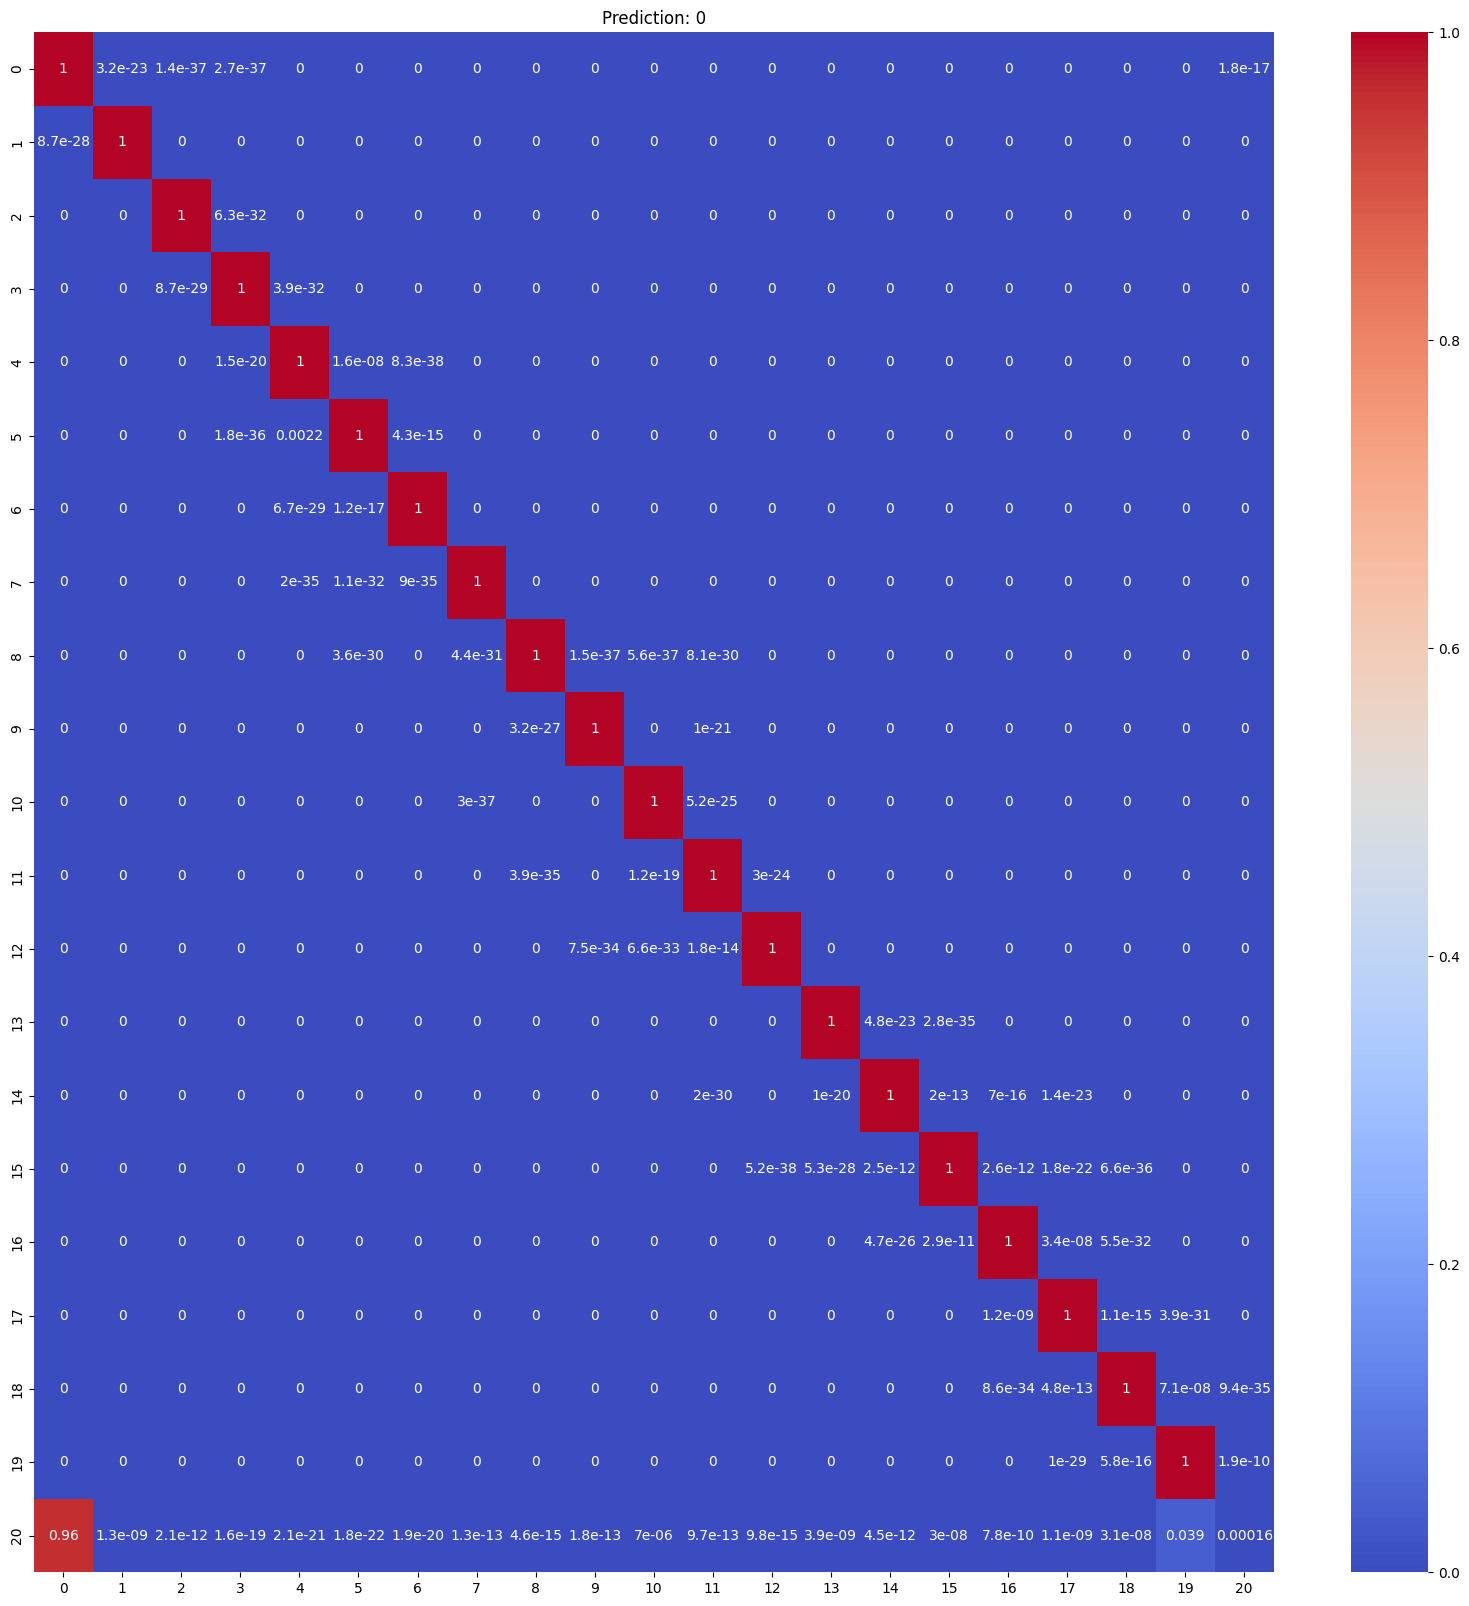

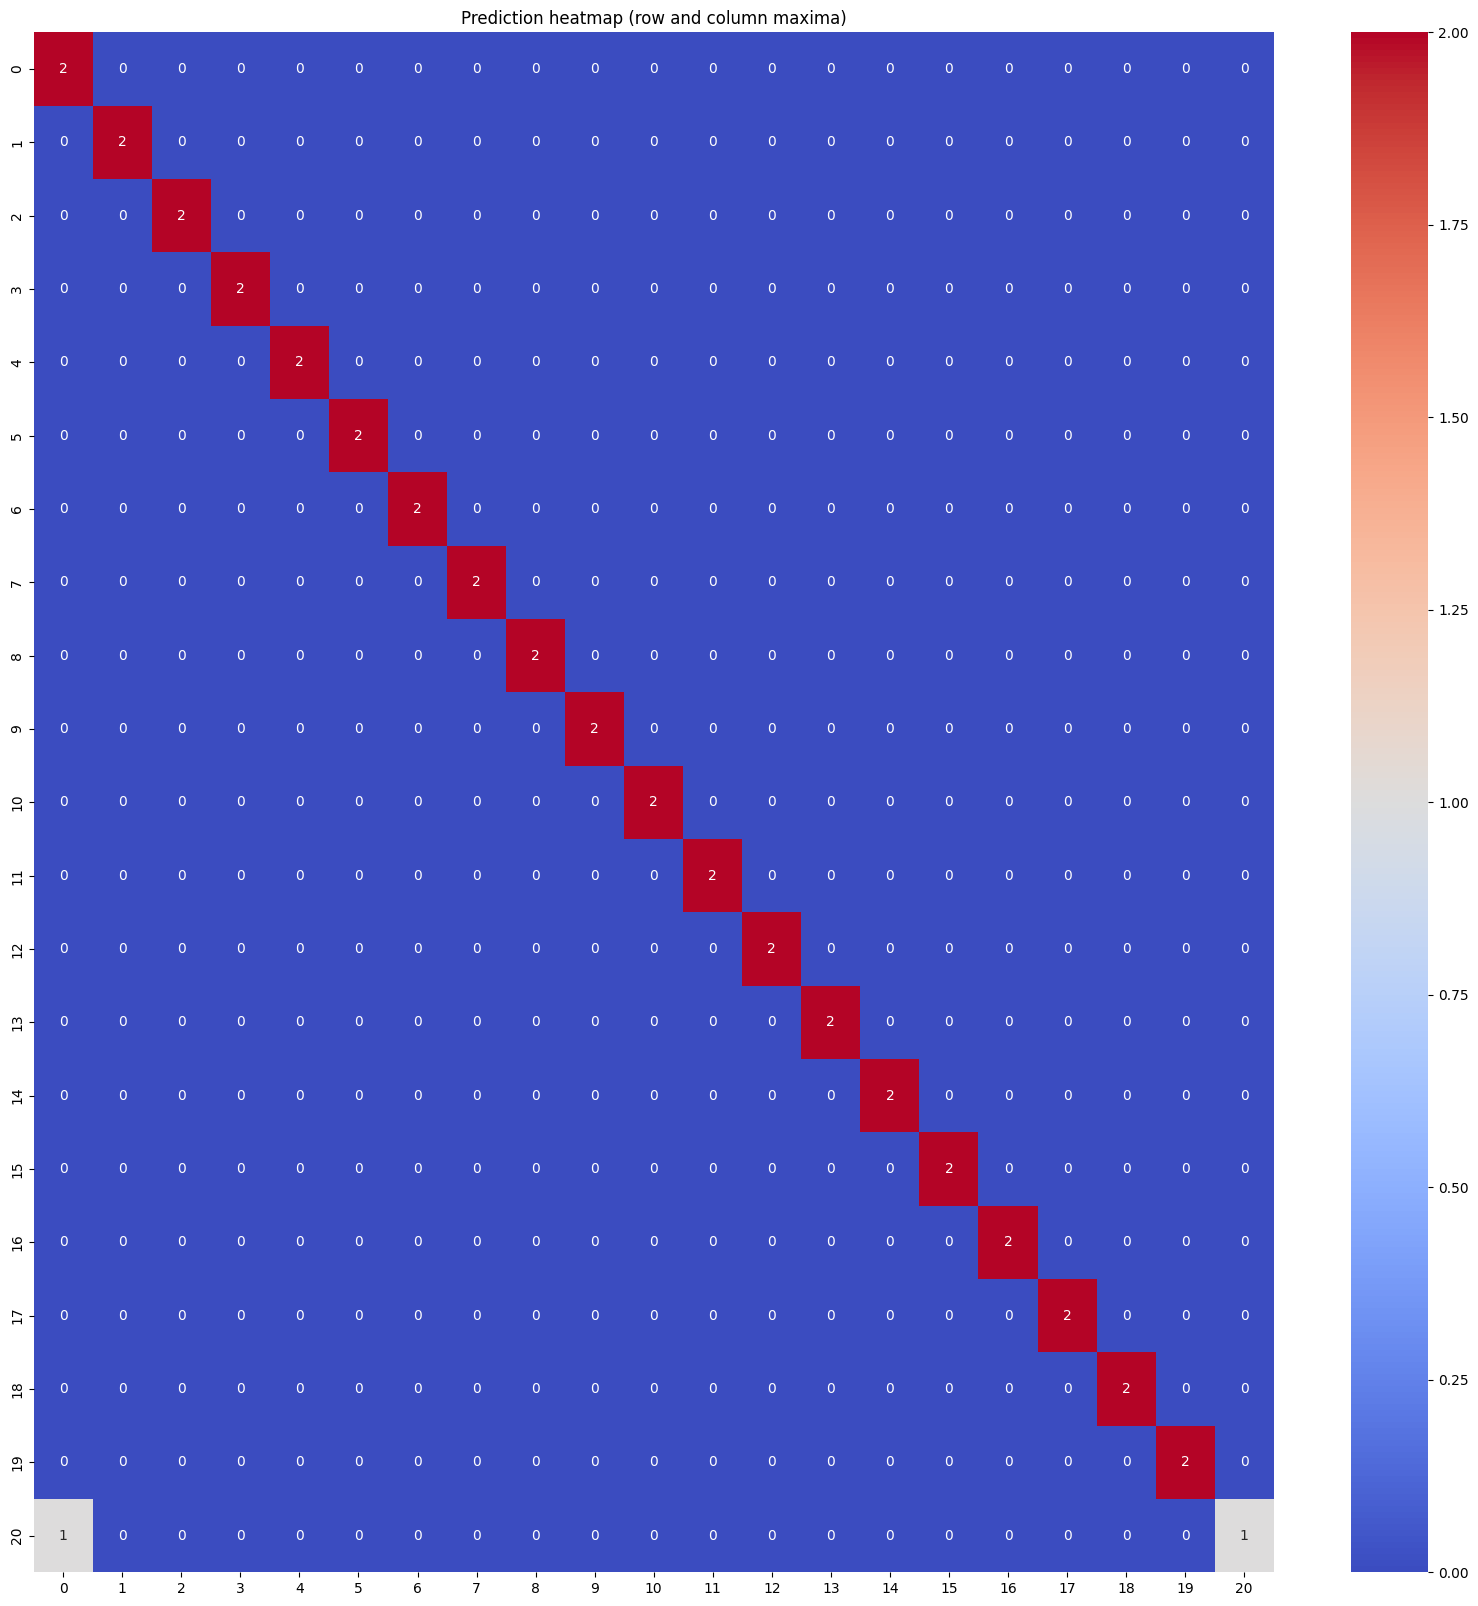

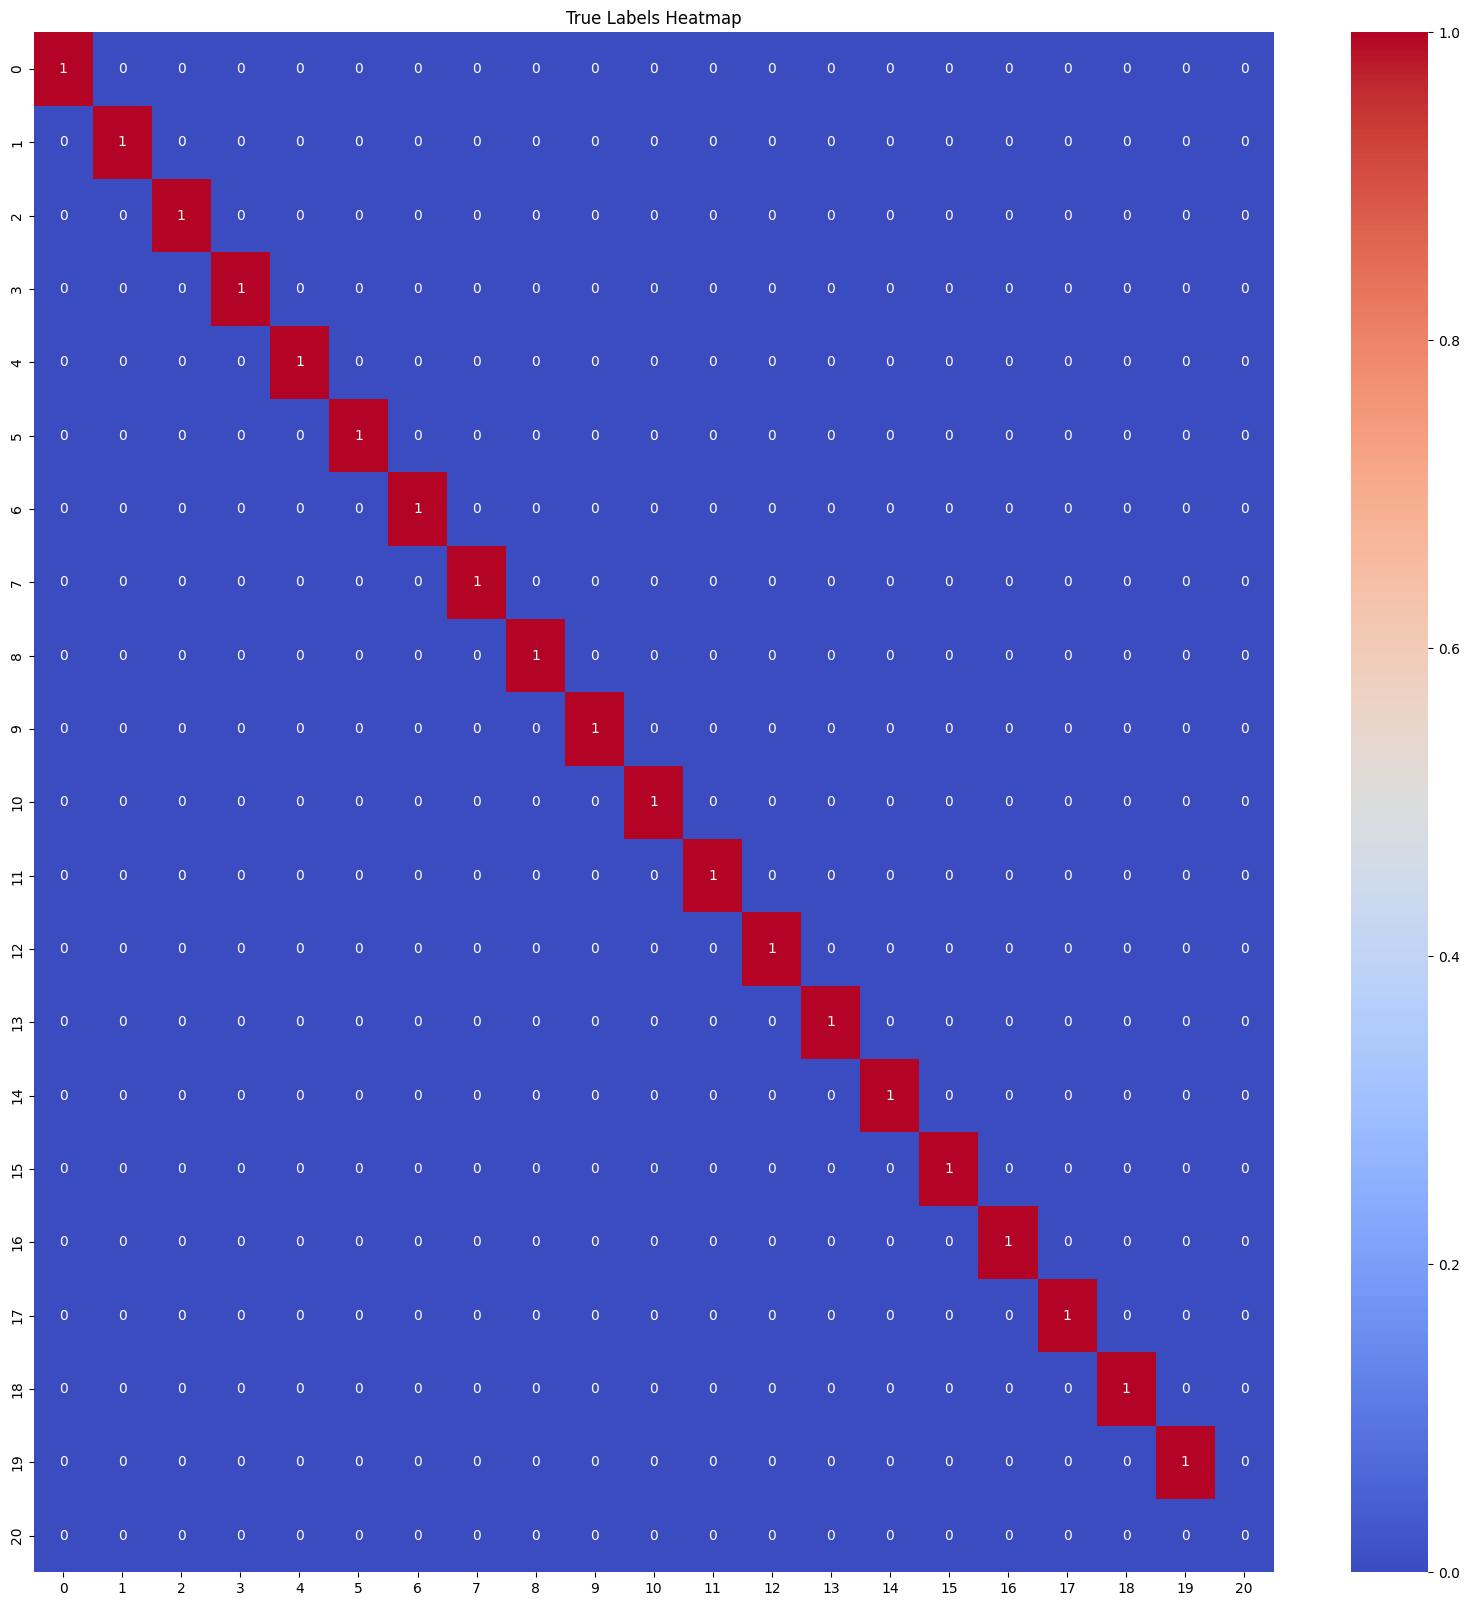


Heatmap visualization for first prediction:


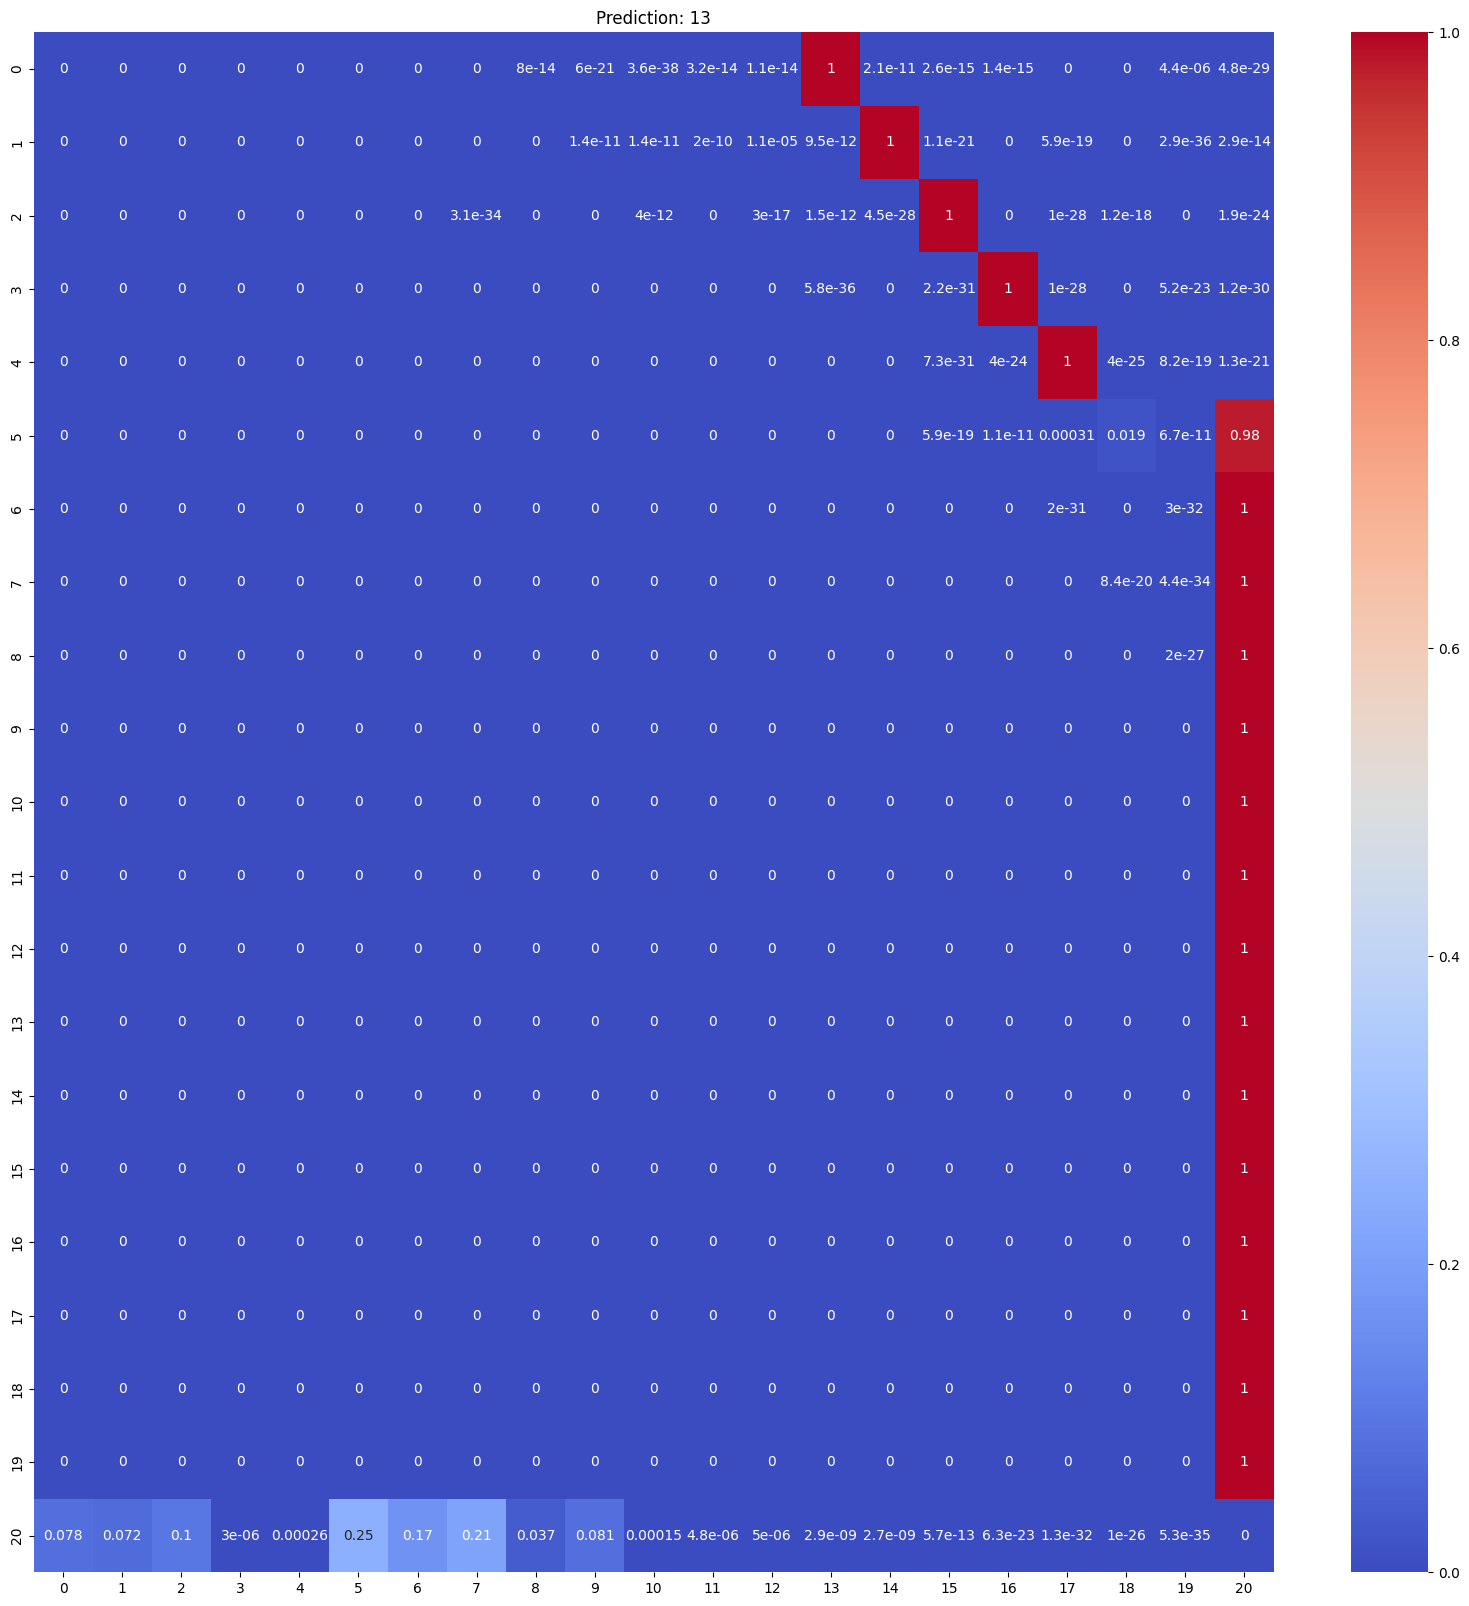

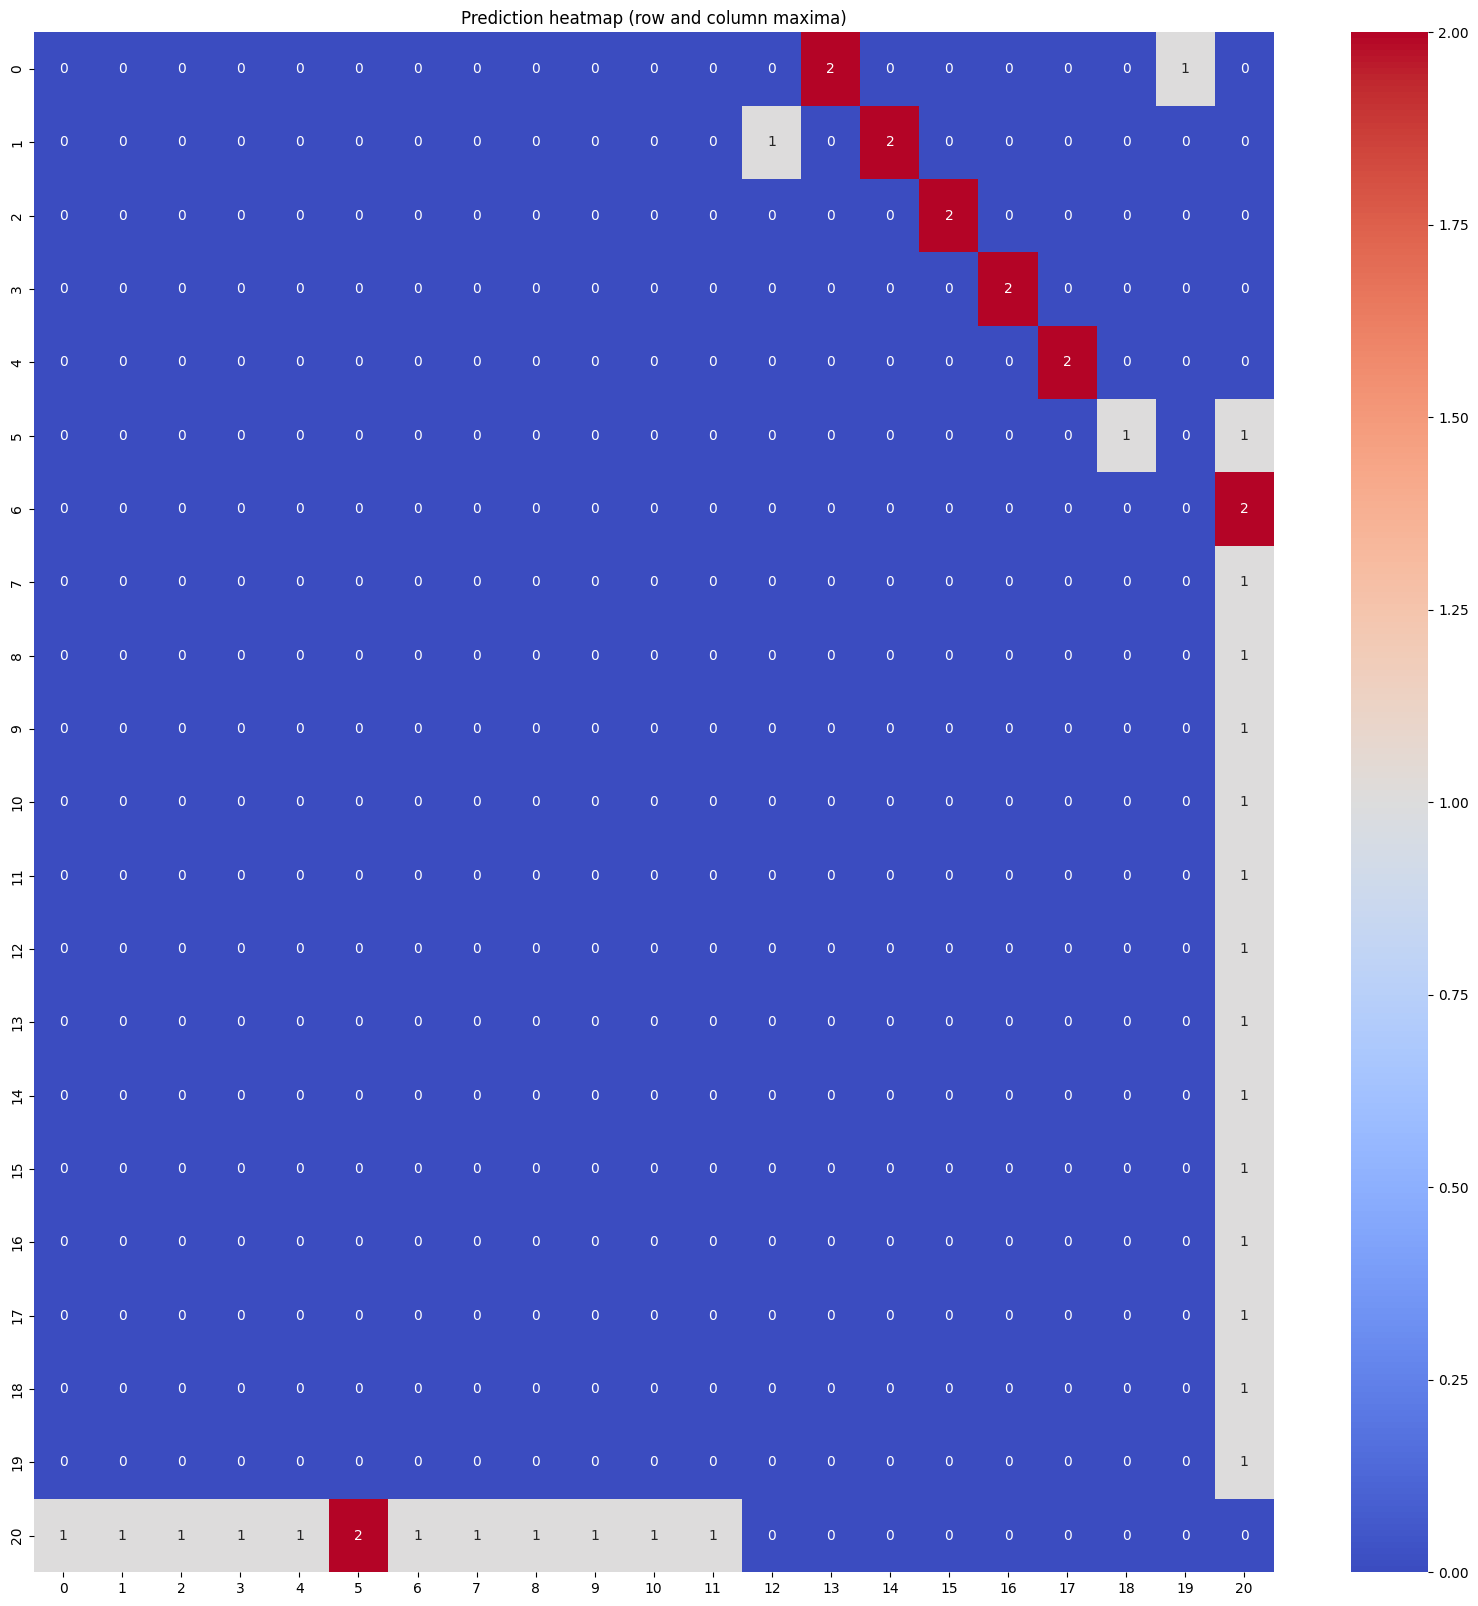

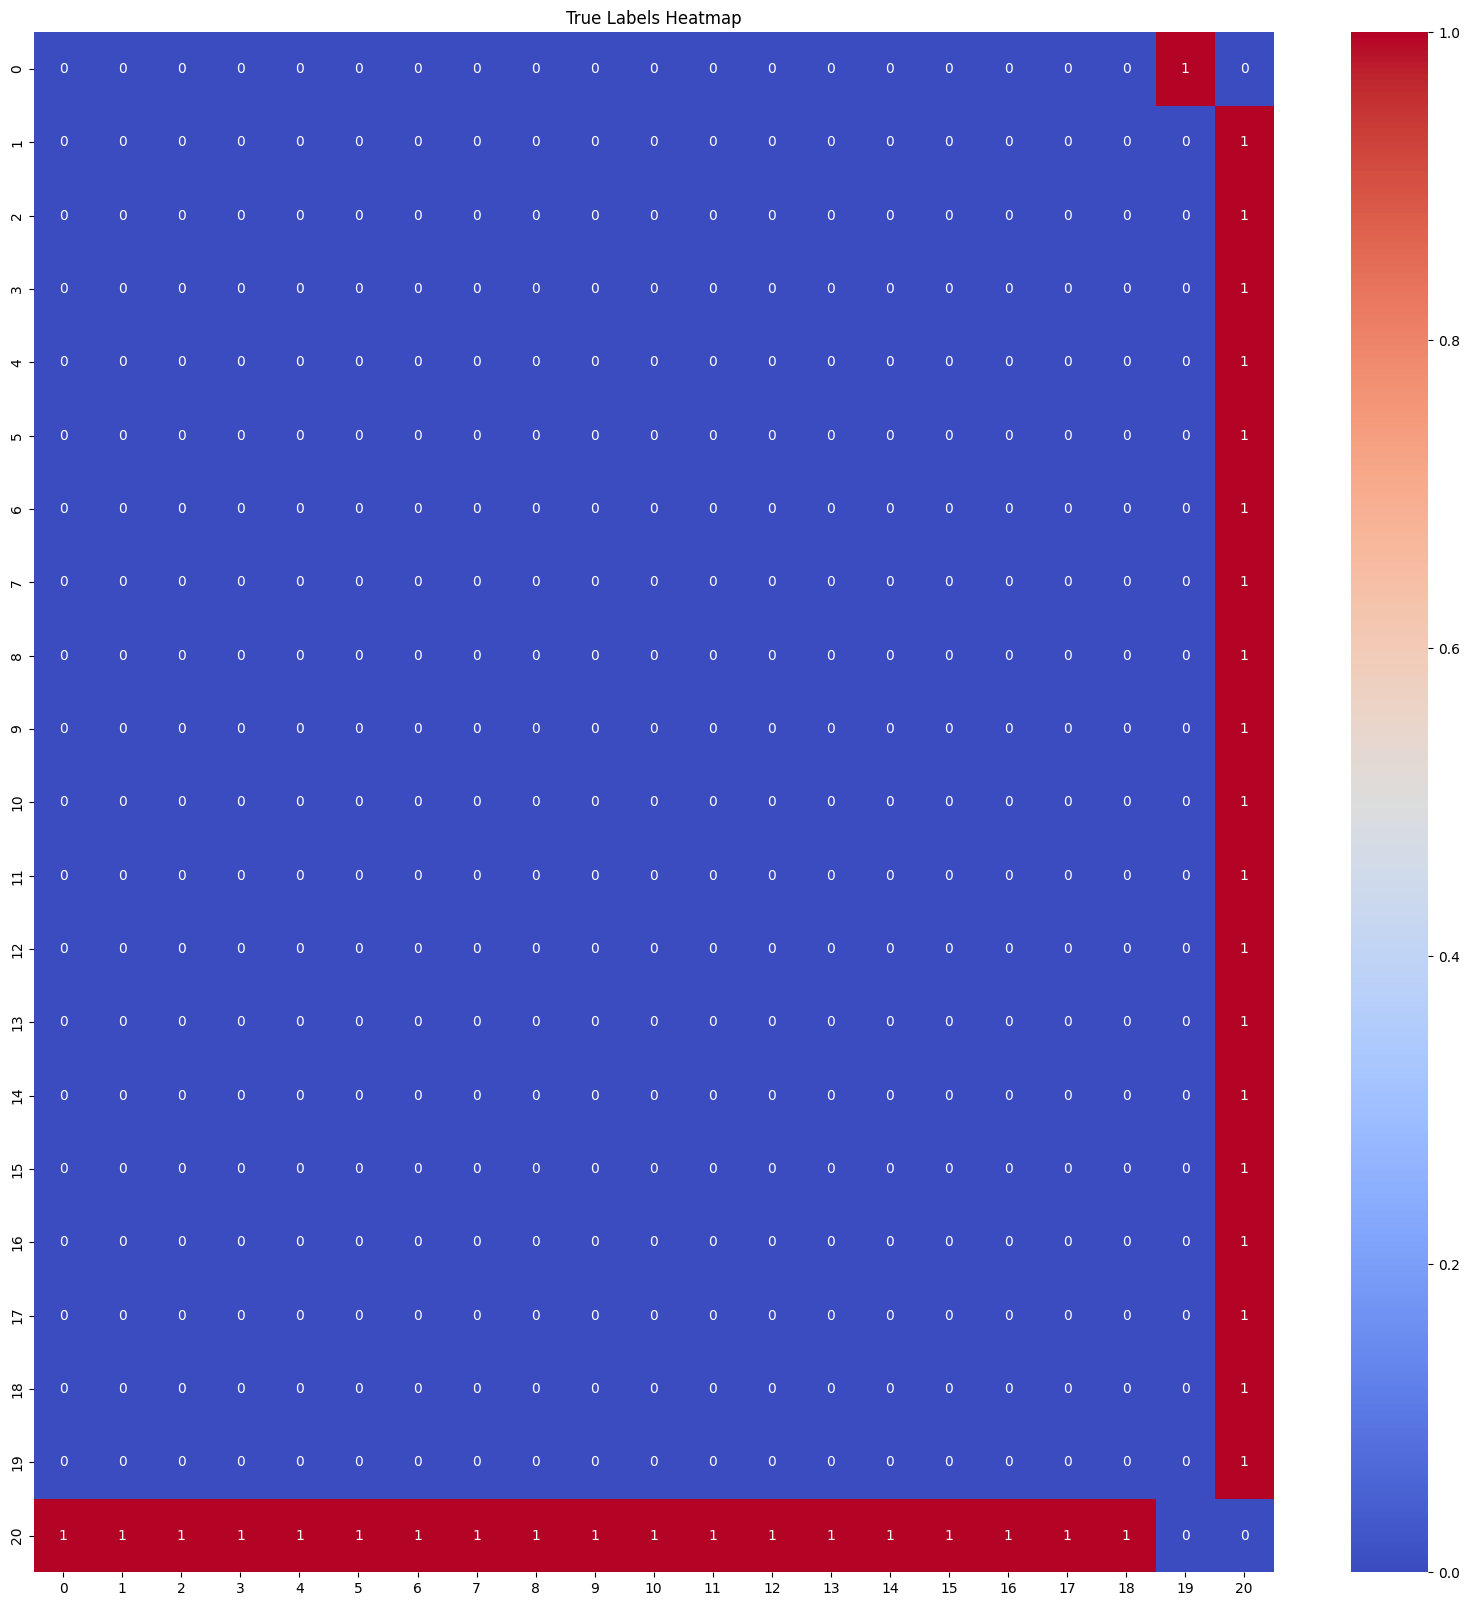

In [21]:
model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

model.predict(
    feature_loc,
    weight_name= weight_name,
    video_pair= "12_02, 12_03",
    output_path= f"/home/jireh/MT/video_sync_v1/trash/output_test")


## Draft below

In [41]:
# Instantiate the model
num_heads = 4 # 8,4,1
embed_dim = 48  # 768  48
num_layers = 1 # 4,2,1
lr = 1e-3
len_video = 20
# weight_name = f'weights_swin1_{num_heads}_{num_layers}.h5'
weight_name = 'weights_test.h5'

print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}", sep="\n")
print(f"Learning rate: {lr}", f"Weight name: {weight_name}", sep="\n")
print(f"Video length:{len_video}")

# extracted feature
feature_loc = f"/home/jireh/MT/video_sync_v1/trash/featureData_len20_2.npy"
trainDS = np.load(feature_loc,allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
df.head()

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 1
Learning rate: 0.001
Weight name: weights_test.h5
Video length:20
(20, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 2.309638, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 2.1115987, 0.0, 0.0, 0.0, 0.0...",3302,3315,13
1,"[[0.0, 0.0, 0.0, 2.300419, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 2.0745728, 0.0, 0.0, 0.0, 0.0...",7195,7208,13
2,"[[0.0, 0.0, 0.0, 2.0994868, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.4934905, 0.0, 0.0, 0.0, 0.0...",2604,2608,4
3,"[[0.0, 0.0, 0.0, 2.3748496, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.2557695, 0.0, 0.0, 0.0, 0.0...",5923,5927,4
4,"[[0.0, 0.0, 0.0, 2.7255192, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.173066, 0.0, 0.0, 0.0, 0.23...",6433,6448,15


In [ ]:
model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

# model.predict(
#     feature_loc,
#     weight_name= weight_name,
#     video_pair= "12_02, 12_03",
#     output_path= f"/home/jireh/MT/video_sync_v1/trash/output_{num_heads}_{num_layers}_tr20_te{len_video}"

# Train the model
model.train(
    feature_loc,
    batch_size=1024,
    epochs=700,
    learning_rate=lr,
    weight_name= weight_name
)

Epoch 1/700
23/23 [==============================] - ETA: 0s - loss: 8.3747 - accuracy: 0.4589
Epoch 1: val_accuracy improved from -inf to 0.48142, saving model to weights_test.h5
23/23 [==============================] - 27s 1s/step - loss: 8.3747 - accuracy: 0.4589 - val_loss: 8.2777 - val_accuracy: 0.4814
Epoch 2/700
23/23 [==============================] - ETA: 0s - loss: 8.2648 - accuracy: 0.4792
Epoch 2: val_accuracy improved from 0.48142 to 0.48160, saving model to weights_test.h5
23/23 [==============================] - 26s 1s/step - loss: 8.2648 - accuracy: 0.4792 - val_loss: 8.2778 - val_accuracy: 0.4816
Epoch 3/700
23/23 [==============================] - ETA: 0s - loss: 8.2635 - accuracy: 0.4790
Epoch 3: val_accuracy improved from 0.48160 to 0.48173, saving model to weights_test.h5
23/23 [==============================] - 25s 1s/step - loss: 8.2635 - accuracy: 0.4790 - val_loss: 8.2778 - val_accuracy: 0.4817
Epoch 4/700
23/23 [==============================] - ETA: 0s - loss

Epoch 26/700
23/23 [==============================] - ETA: 0s - loss: 8.2426 - accuracy: 0.4877
Epoch 26: val_accuracy did not improve from 0.49730
23/23 [==============================] - 26s 1s/step - loss: 8.2426 - accuracy: 0.4877 - val_loss: 8.2583 - val_accuracy: 0.4907
Epoch 27/700
23/23 [==============================] - ETA: 0s - loss: 8.2419 - accuracy: 0.4876
Epoch 27: val_accuracy did not improve from 0.49730
23/23 [==============================] - 24s 1s/step - loss: 8.2419 - accuracy: 0.4876 - val_loss: 8.2582 - val_accuracy: 0.4906
Epoch 28/700
23/23 [==============================] - ETA: 0s - loss: 8.2422 - accuracy: 0.4877
Epoch 28: val_accuracy did not improve from 0.49730
23/23 [==============================] - 26s 1s/step - loss: 8.2422 - accuracy: 0.4877 - val_loss: 8.2567 - val_accuracy: 0.4896
Epoch 29/700
23/23 [==============================] - ETA: 0s - loss: 8.2396 - accuracy: 0.4872
Epoch 29: val_accuracy did not improve from 0.49730
23/23 [==============

Epoch 55/700
23/23 [==============================] - ETA: 0s - loss: 8.1397 - accuracy: 0.5143
Epoch 55: val_accuracy improved from 0.50886 to 0.51427, saving model to weights_test.h5
23/23 [==============================] - 27s 1s/step - loss: 8.1397 - accuracy: 0.5143 - val_loss: 8.1585 - val_accuracy: 0.5143
Epoch 56/700
23/23 [==============================] - ETA: 0s - loss: 8.1340 - accuracy: 0.5153
Epoch 56: val_accuracy did not improve from 0.51427
23/23 [==============================] - 26s 1s/step - loss: 8.1340 - accuracy: 0.5153 - val_loss: 8.1612 - val_accuracy: 0.5139
Epoch 57/700
23/23 [==============================] - ETA: 0s - loss: 8.1335 - accuracy: 0.5166
Epoch 57: val_accuracy did not improve from 0.51427
23/23 [==============================] - 27s 1s/step - loss: 8.1335 - accuracy: 0.5166 - val_loss: 8.1594 - val_accuracy: 0.5137
Epoch 58/700
23/23 [==============================] - ETA: 0s - loss: 8.1285 - accuracy: 0.5193
Epoch 58: val_accuracy did not impro

Epoch 83/700
23/23 [==============================] - ETA: 0s - loss: 8.0706 - accuracy: 0.5442
Epoch 83: val_accuracy did not improve from 0.53372
23/23 [==============================] - 26s 1s/step - loss: 8.0706 - accuracy: 0.5442 - val_loss: 8.1164 - val_accuracy: 0.5285
Epoch 84/700
23/23 [==============================] - ETA: 0s - loss: 8.0681 - accuracy: 0.5449
Epoch 84: val_accuracy did not improve from 0.53372
23/23 [==============================] - 25s 1s/step - loss: 8.0681 - accuracy: 0.5449 - val_loss: 8.1353 - val_accuracy: 0.5195
Epoch 85/700
23/23 [==============================] - ETA: 0s - loss: 8.0757 - accuracy: 0.5402
Epoch 85: val_accuracy improved from 0.53372 to 0.53384, saving model to weights_test.h5
23/23 [==============================] - 26s 1s/step - loss: 8.0757 - accuracy: 0.5402 - val_loss: 8.1118 - val_accuracy: 0.5338
Epoch 86/700
23/23 [==============================] - ETA: 0s - loss: 8.0609 - accuracy: 0.5486
Epoch 86: val_accuracy did not impro

Epoch 140/700
23/23 [==============================] - ETA: 0s - loss: 7.9987 - accuracy: 0.5770
Epoch 140: val_accuracy did not improve from 0.55715
23/23 [==============================] - 25s 1s/step - loss: 7.9987 - accuracy: 0.5770 - val_loss: 8.0820 - val_accuracy: 0.5415
Epoch 141/700
23/23 [==============================] - ETA: 0s - loss: 8.0035 - accuracy: 0.5734
Epoch 141: val_accuracy did not improve from 0.55715
23/23 [==============================] - 24s 1s/step - loss: 8.0035 - accuracy: 0.5734 - val_loss: 8.0632 - val_accuracy: 0.5551
Epoch 142/700
23/23 [==============================] - ETA: 0s - loss: 7.9943 - accuracy: 0.5784
Epoch 142: val_accuracy did not improve from 0.55715
23/23 [==============================] - 25s 1s/step - loss: 7.9943 - accuracy: 0.5784 - val_loss: 8.0622 - val_accuracy: 0.5527
Epoch 143/700
23/23 [==============================] - ETA: 0s - loss: 7.9875 - accuracy: 0.5831
Epoch 143: val_accuracy improved from 0.55715 to 0.55726, saving m

23/23 [==============================] - 26s 1s/step - loss: 7.9640 - accuracy: 0.5923 - val_loss: 8.0530 - val_accuracy: 0.5572
Epoch 169/700
23/23 [==============================] - ETA: 0s - loss: 7.9573 - accuracy: 0.5950
Epoch 169: val_accuracy did not improve from 0.56362
23/23 [==============================] - 25s 1s/step - loss: 7.9573 - accuracy: 0.5950 - val_loss: 8.0432 - val_accuracy: 0.5604
Epoch 170/700
23/23 [==============================] - ETA: 0s - loss: 7.9590 - accuracy: 0.5959
Epoch 170: val_accuracy did not improve from 0.56362
23/23 [==============================] - 26s 1s/step - loss: 7.9590 - accuracy: 0.5959 - val_loss: 8.0435 - val_accuracy: 0.5631
Epoch 171/700
23/23 [==============================] - ETA: 0s - loss: 7.9529 - accuracy: 0.5975
Epoch 171: val_accuracy did not improve from 0.56362
23/23 [==============================] - 25s 1s/step - loss: 7.9529 - accuracy: 0.5975 - val_loss: 8.0434 - val_accuracy: 0.5575
Epoch 172/700
23/23 [=============

23/23 [==============================] - 26s 1s/step - loss: 7.9400 - accuracy: 0.6036 - val_loss: 8.0250 - val_accuracy: 0.5680
Epoch 198/700
23/23 [==============================] - ETA: 0s - loss: 7.9384 - accuracy: 0.6045
Epoch 198: val_accuracy did not improve from 0.56964
23/23 [==============================] - 25s 1s/step - loss: 7.9384 - accuracy: 0.6045 - val_loss: 8.0321 - val_accuracy: 0.5666
Epoch 199/700
23/23 [==============================] - ETA: 0s - loss: 7.9368 - accuracy: 0.6072
Epoch 199: val_accuracy did not improve from 0.56964
23/23 [==============================] - 26s 1s/step - loss: 7.9368 - accuracy: 0.6072 - val_loss: 8.0620 - val_accuracy: 0.5500
Epoch 200/700
23/23 [==============================] - ETA: 0s - loss: 7.9433 - accuracy: 0.6002
Epoch 200: val_accuracy did not improve from 0.56964
23/23 [==============================] - 25s 1s/step - loss: 7.9433 - accuracy: 0.6002 - val_loss: 8.0293 - val_accuracy: 0.5692
Epoch 201/700
23/23 [=============

Epoch 255/700
23/23 [==============================] - ETA: 0s - loss: 7.8845 - accuracy: 0.6304
Epoch 255: val_accuracy did not improve from 0.58177
23/23 [==============================] - 26s 1s/step - loss: 7.8845 - accuracy: 0.6304 - val_loss: 8.0056 - val_accuracy: 0.5796
Epoch 256/700
23/23 [==============================] - ETA: 0s - loss: 7.9016 - accuracy: 0.6227
Epoch 256: val_accuracy did not improve from 0.58177
23/23 [==============================] - 25s 1s/step - loss: 7.9016 - accuracy: 0.6227 - val_loss: 8.0094 - val_accuracy: 0.5777
Epoch 257/700
23/23 [==============================] - ETA: 0s - loss: 7.9026 - accuracy: 0.6236
Epoch 257: val_accuracy did not improve from 0.58177
23/23 [==============================] - 25s 1s/step - loss: 7.9026 - accuracy: 0.6236 - val_loss: 8.0084 - val_accuracy: 0.5771
Epoch 258/700
23/23 [==============================] - ETA: 0s - loss: 7.9097 - accuracy: 0.6191
Epoch 258: val_accuracy did not improve from 0.58177
23/23 [======

Epoch 284/700
23/23 [==============================] - ETA: 0s - loss: 7.8908 - accuracy: 0.6276
Epoch 284: val_accuracy did not improve from 0.58482
23/23 [==============================] - 24s 1s/step - loss: 7.8908 - accuracy: 0.6276 - val_loss: 8.0267 - val_accuracy: 0.5662
Epoch 285/700
23/23 [==============================] - ETA: 0s - loss: 7.9033 - accuracy: 0.6211
Epoch 285: val_accuracy did not improve from 0.58482
23/23 [==============================] - 25s 1s/step - loss: 7.9033 - accuracy: 0.6211 - val_loss: 8.0020 - val_accuracy: 0.5815
Epoch 286/700
23/23 [==============================] - ETA: 0s - loss: 7.8981 - accuracy: 0.6245
Epoch 286: val_accuracy improved from 0.58482 to 0.58764, saving model to weights_test.h5
23/23 [==============================] - 25s 1s/step - loss: 7.8981 - accuracy: 0.6245 - val_loss: 7.9918 - val_accuracy: 0.5876
Epoch 287/700
23/23 [==============================] - ETA: 0s - loss: 7.8852 - accuracy: 0.6308
Epoch 287: val_accuracy did n

Epoch 313/700
23/23 [==============================] - ETA: 0s - loss: 7.8782 - accuracy: 0.6332
Epoch 313: val_accuracy did not improve from 0.59274
23/23 [==============================] - 25s 1s/step - loss: 7.8782 - accuracy: 0.6332 - val_loss: 7.9893 - val_accuracy: 0.5857
Epoch 314/700
23/23 [==============================] - ETA: 0s - loss: 7.8661 - accuracy: 0.6389
Epoch 314: val_accuracy did not improve from 0.59274
23/23 [==============================] - 25s 1s/step - loss: 7.8661 - accuracy: 0.6389 - val_loss: 7.9899 - val_accuracy: 0.5870
Epoch 315/700
23/23 [==============================] - ETA: 0s - loss: 7.8748 - accuracy: 0.6353
Epoch 315: val_accuracy did not improve from 0.59274
23/23 [==============================] - 27s 1s/step - loss: 7.8748 - accuracy: 0.6353 - val_loss: 7.9869 - val_accuracy: 0.5869
Epoch 316/700
23/23 [==============================] - ETA: 0s - loss: 7.8704 - accuracy: 0.6374
Epoch 316: val_accuracy did not improve from 0.59274
23/23 [======

23/23 [==============================] - 26s 1s/step - loss: 7.8666 - accuracy: 0.6377 - val_loss: 7.9831 - val_accuracy: 0.5861
Epoch 372/700
23/23 [==============================] - ETA: 0s - loss: 7.8503 - accuracy: 0.6465
Epoch 372: val_accuracy did not improve from 0.59365
23/23 [==============================] - 25s 1s/step - loss: 7.8503 - accuracy: 0.6465 - val_loss: 7.9712 - val_accuracy: 0.5925
Epoch 373/700
23/23 [==============================] - ETA: 0s - loss: 7.8498 - accuracy: 0.6463
Epoch 373: val_accuracy did not improve from 0.59365
23/23 [==============================] - 25s 1s/step - loss: 7.8498 - accuracy: 0.6463 - val_loss: 7.9916 - val_accuracy: 0.5841
Epoch 374/700
23/23 [==============================] - ETA: 0s - loss: 7.8504 - accuracy: 0.6472
Epoch 374: val_accuracy did not improve from 0.59365
23/23 [==============================] - 25s 1s/step - loss: 7.8504 - accuracy: 0.6472 - val_loss: 7.9866 - val_accuracy: 0.5849
Epoch 375/700
23/23 [=============

Epoch 401/700
23/23 [==============================] - ETA: 0s - loss: 7.8385 - accuracy: 0.6519
Epoch 401: val_accuracy did not improve from 0.59831
23/23 [==============================] - 26s 1s/step - loss: 7.8385 - accuracy: 0.6519 - val_loss: 7.9791 - val_accuracy: 0.5888
Epoch 402/700
23/23 [==============================] - ETA: 0s - loss: 7.8399 - accuracy: 0.6509
Epoch 402: val_accuracy did not improve from 0.59831
23/23 [==============================] - 25s 1s/step - loss: 7.8399 - accuracy: 0.6509 - val_loss: 7.9801 - val_accuracy: 0.5876
Epoch 403/700
23/23 [==============================] - ETA: 0s - loss: 7.8388 - accuracy: 0.6517
Epoch 403: val_accuracy did not improve from 0.59831
23/23 [==============================] - 25s 1s/step - loss: 7.8388 - accuracy: 0.6517 - val_loss: 7.9686 - val_accuracy: 0.5935
Epoch 404/700
23/23 [==============================] - ETA: 0s - loss: 7.8267 - accuracy: 0.6581
Epoch 404: val_accuracy did not improve from 0.59831
23/23 [======

23/23 [==============================] - 25s 1s/step - loss: 7.8343 - accuracy: 0.6515 - val_loss: 7.9817 - val_accuracy: 0.5883
Epoch 431/700
23/23 [==============================] - ETA: 0s - loss: 7.8252 - accuracy: 0.6579
Epoch 431: val_accuracy did not improve from 0.59831
23/23 [==============================] - 25s 1s/step - loss: 7.8252 - accuracy: 0.6579 - val_loss: 7.9673 - val_accuracy: 0.5934
Epoch 432/700
23/23 [==============================] - ETA: 0s - loss: 7.8243 - accuracy: 0.6589
Epoch 432: val_accuracy did not improve from 0.59831
23/23 [==============================] - 25s 1s/step - loss: 7.8243 - accuracy: 0.6589 - val_loss: 7.9602 - val_accuracy: 0.5967
Epoch 433/700
23/23 [==============================] - ETA: 0s - loss: 7.8197 - accuracy: 0.6603
Epoch 433: val_accuracy did not improve from 0.59831
23/23 [==============================] - 25s 1s/step - loss: 7.8197 - accuracy: 0.6603 - val_loss: 7.9720 - val_accuracy: 0.5911
Epoch 434/700
23/23 [=============

Epoch 460/700
23/23 [==============================] - ETA: 0s - loss: 7.8249 - accuracy: 0.6572
Epoch 460: val_accuracy did not improve from 0.59954
23/23 [==============================] - 25s 1s/step - loss: 7.8249 - accuracy: 0.6572 - val_loss: 7.9782 - val_accuracy: 0.5898
Epoch 461/700
23/23 [==============================] - ETA: 0s - loss: 7.8415 - accuracy: 0.6498
Epoch 461: val_accuracy did not improve from 0.59954
23/23 [==============================] - 26s 1s/step - loss: 7.8415 - accuracy: 0.6498 - val_loss: 7.9817 - val_accuracy: 0.5869
Epoch 462/700
23/23 [==============================] - ETA: 0s - loss: 7.8255 - accuracy: 0.6568
Epoch 462: val_accuracy did not improve from 0.59954
23/23 [==============================] - 25s 1s/step - loss: 7.8255 - accuracy: 0.6568 - val_loss: 7.9630 - val_accuracy: 0.5986
Epoch 463/700
23/23 [==============================] - ETA: 0s - loss: 7.8232 - accuracy: 0.6590
Epoch 463: val_accuracy did not improve from 0.59954
23/23 [======

23/23 [==============================] - ETA: 0s - loss: 7.7921 - accuracy: 0.6722
Epoch 518: val_accuracy did not improve from 0.60373
23/23 [==============================] - 26s 1s/step - loss: 7.7921 - accuracy: 0.6722 - val_loss: 7.9517 - val_accuracy: 0.6001
Epoch 519/700
23/23 [==============================] - ETA: 0s - loss: 7.7916 - accuracy: 0.6725
Epoch 519: val_accuracy did not improve from 0.60373
23/23 [==============================] - 25s 1s/step - loss: 7.7916 - accuracy: 0.6725 - val_loss: 7.9533 - val_accuracy: 0.6009
Epoch 520/700
23/23 [==============================] - ETA: 0s - loss: 7.8016 - accuracy: 0.6682
Epoch 520: val_accuracy did not improve from 0.60373
23/23 [==============================] - 27s 1s/step - loss: 7.8016 - accuracy: 0.6682 - val_loss: 7.9543 - val_accuracy: 0.6010
Epoch 521/700
23/23 [==============================] - ETA: 0s - loss: 7.8076 - accuracy: 0.6651
Epoch 521: val_accuracy did not improve from 0.60373
23/23 [====================

23/23 [==============================] - ETA: 0s - loss: 7.8018 - accuracy: 0.6663
Epoch 547: val_accuracy did not improve from 0.60627
23/23 [==============================] - 25s 1s/step - loss: 7.8018 - accuracy: 0.6663 - val_loss: 7.9579 - val_accuracy: 0.5975
Epoch 548/700
23/23 [==============================] - ETA: 0s - loss: 7.8135 - accuracy: 0.6617
Epoch 548: val_accuracy did not improve from 0.60627
23/23 [==============================] - 26s 1s/step - loss: 7.8135 - accuracy: 0.6617 - val_loss: 7.9765 - val_accuracy: 0.5899
Epoch 549/700
23/23 [==============================] - ETA: 0s - loss: 7.8157 - accuracy: 0.6604
Epoch 549: val_accuracy did not improve from 0.60627
23/23 [==============================] - 25s 1s/step - loss: 7.8157 - accuracy: 0.6604 - val_loss: 7.9482 - val_accuracy: 0.6024
Epoch 550/700
23/23 [==============================] - ETA: 0s - loss: 7.7879 - accuracy: 0.6753
Epoch 550: val_accuracy improved from 0.60627 to 0.60811, saving model to weight

23/23 [==============================] - ETA: 0s - loss: 7.7726 - accuracy: 0.6818
Epoch 605: val_accuracy did not improve from 0.60960
23/23 [==============================] - 27s 1s/step - loss: 7.7726 - accuracy: 0.6818 - val_loss: 7.9422 - val_accuracy: 0.6065
Epoch 606/700
23/23 [==============================] - ETA: 0s - loss: 7.7878 - accuracy: 0.6747
Epoch 606: val_accuracy did not improve from 0.60960
23/23 [==============================] - 28s 1s/step - loss: 7.7878 - accuracy: 0.6747 - val_loss: 7.9443 - val_accuracy: 0.6032
Epoch 607/700
23/23 [==============================] - ETA: 0s - loss: 7.7764 - accuracy: 0.6809
Epoch 607: val_accuracy did not improve from 0.60960
23/23 [==============================] - 27s 1s/step - loss: 7.7764 - accuracy: 0.6809 - val_loss: 7.9383 - val_accuracy: 0.6084
Epoch 608/700
23/23 [==============================] - ETA: 0s - loss: 7.7714 - accuracy: 0.6845
Epoch 608: val_accuracy improved from 0.60960 to 0.61342, saving model to weight

In [9]:
# Instantiate the model
num_heads = 4 # 8,4,1
embed_dim = 48  # 768  48
num_layers = 1 # 4,2,1
lr = 1e-2
len_video = 20
# weight_name = f'weights_swin1_{num_heads}_{num_layers}.h5'
weight_name = f'weights_1_{num_heads}_{num_layers}.h5'

print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}", sep="\n")
print(f"Learning rate: {lr}", f"Weight name: {weight_name}", sep="\n")
print(f"Video length:{len_video}")

# extracted feature
feature_loc = f"/home/jireh/MT/video_sync_v1/trash/featureData_len{len_video}.npy"
trainDS = np.load(feature_loc,allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
df.head()

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 1
Learning rate: 0.01
Weight name: weights_1_4_1.h5
Video length:20
(20, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 1.6089702, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.8075621, 0.0, 0.0, 0.0, 0.0...",8826,8820,-6
1,"[[0.0, 0.0, 0.0, 1.8062649, 0.0, 0.0, 0.0, 0.3...","[[0.0, 0.0, 0.0, 1.6168554, 0.0, 0.0, 0.0, 1.0...",1609,1614,5
2,"[[0.0, 0.0, 0.0, 2.4083185, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.9391971, 0.0, 0.0, 0.0, 0.4...",135,119,-16
3,"[[0.0, 0.0, 0.0, 2.7848241, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.9663225, 0.0, 0.0, 0.0, 0.0...",2398,2405,7
4,"[[0.0, 0.0, 0.0, 2.719998, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 2.9480596, 0.0, 0.0, 0.0, 0.0...",2350,2368,18


Epoch 1/700
23/23 [==============================] - ETA: 0s - loss: 8.3700 - accuracy: 0.4576
Epoch 1: val_accuracy improved from -inf to 0.48050, saving model to weights_1_4_1.h5
23/23 [==============================] - 27s 1s/step - loss: 8.3700 - accuracy: 0.4576 - val_loss: 8.2738 - val_accuracy: 0.4805
Epoch 2/700
23/23 [==============================] - ETA: 0s - loss: 8.2537 - accuracy: 0.4765
Epoch 2: val_accuracy improved from 0.48050 to 0.48079, saving model to weights_1_4_1.h5
23/23 [==============================] - 24s 1s/step - loss: 8.2537 - accuracy: 0.4765 - val_loss: 8.2738 - val_accuracy: 0.4808
Epoch 3/700
23/23 [==============================] - ETA: 0s - loss: 8.2554 - accuracy: 0.4770
Epoch 3: val_accuracy improved from 0.48079 to 0.48099, saving model to weights_1_4_1.h5
23/23 [==============================] - 25s 1s/step - loss: 8.2554 - accuracy: 0.4770 - val_loss: 8.2738 - val_accuracy: 0.4810
Epoch 4/700
23/23 [==============================] - ETA: 0s - l

23/23 [==============================] - 25s 1s/step - loss: 8.2251 - accuracy: 0.4858 - val_loss: 8.2475 - val_accuracy: 0.4913
Epoch 27/700
23/23 [==============================] - ETA: 0s - loss: 8.2252 - accuracy: 0.4865
Epoch 27: val_accuracy did not improve from 0.49317
23/23 [==============================] - 25s 1s/step - loss: 8.2252 - accuracy: 0.4865 - val_loss: 8.2489 - val_accuracy: 0.4911
Epoch 28/700
23/23 [==============================] - ETA: 0s - loss: 8.2214 - accuracy: 0.4856
Epoch 28: val_accuracy did not improve from 0.49317
23/23 [==============================] - 26s 1s/step - loss: 8.2214 - accuracy: 0.4856 - val_loss: 8.2451 - val_accuracy: 0.4900
Epoch 29/700
23/23 [==============================] - ETA: 0s - loss: 8.2194 - accuracy: 0.4867
Epoch 29: val_accuracy did not improve from 0.49317
23/23 [==============================] - 25s 1s/step - loss: 8.2194 - accuracy: 0.4867 - val_loss: 8.2437 - val_accuracy: 0.4901
Epoch 30/700
23/23 [====================

Epoch 55/700
23/23 [==============================] - ETA: 0s - loss: 8.1301 - accuracy: 0.5120
Epoch 55: val_accuracy did not improve from 0.50786
23/23 [==============================] - 25s 1s/step - loss: 8.1301 - accuracy: 0.5120 - val_loss: 8.1657 - val_accuracy: 0.5073
Epoch 56/700
23/23 [==============================] - ETA: 0s - loss: 8.1289 - accuracy: 0.5135
Epoch 56: val_accuracy improved from 0.50786 to 0.51002, saving model to weights_1_4_1.h5
23/23 [==============================] - 25s 1s/step - loss: 8.1289 - accuracy: 0.5135 - val_loss: 8.1610 - val_accuracy: 0.5100
Epoch 57/700
23/23 [==============================] - ETA: 0s - loss: 8.1247 - accuracy: 0.5157
Epoch 57: val_accuracy improved from 0.51002 to 0.51093, saving model to weights_1_4_1.h5
23/23 [==============================] - 25s 1s/step - loss: 8.1247 - accuracy: 0.5157 - val_loss: 8.1647 - val_accuracy: 0.5109
Epoch 58/700
23/23 [==============================] - ETA: 0s - loss: 8.1214 - accuracy: 0.51

Epoch 112/700
23/23 [==============================] - ETA: 0s - loss: 8.0438 - accuracy: 0.5517
Epoch 112: val_accuracy did not improve from 0.53646
23/23 [==============================] - 26s 1s/step - loss: 8.0438 - accuracy: 0.5517 - val_loss: 8.1114 - val_accuracy: 0.5303
Epoch 113/700
23/23 [==============================] - ETA: 0s - loss: 8.0409 - accuracy: 0.5543
Epoch 113: val_accuracy did not improve from 0.53646
23/23 [==============================] - 26s 1s/step - loss: 8.0409 - accuracy: 0.5543 - val_loss: 8.1051 - val_accuracy: 0.5324
Epoch 114/700
23/23 [==============================] - ETA: 0s - loss: 8.0280 - accuracy: 0.5594
Epoch 114: val_accuracy improved from 0.53646 to 0.53880, saving model to weights_1_4_1.h5
23/23 [==============================] - 27s 1s/step - loss: 8.0280 - accuracy: 0.5594 - val_loss: 8.0922 - val_accuracy: 0.5388
Epoch 115/700
23/23 [==============================] - ETA: 0s - loss: 8.0252 - accuracy: 0.5603
Epoch 115: val_accuracy did 

Epoch 141/700
23/23 [==============================] - ETA: 0s - loss: 8.0076 - accuracy: 0.5685
Epoch 141: val_accuracy did not improve from 0.54564
23/23 [==============================] - 25s 1s/step - loss: 8.0076 - accuracy: 0.5685 - val_loss: 8.0810 - val_accuracy: 0.5415
Epoch 142/700
23/23 [==============================] - ETA: 0s - loss: 7.9963 - accuracy: 0.5745
Epoch 142: val_accuracy did not improve from 0.54564
23/23 [==============================] - 25s 1s/step - loss: 7.9963 - accuracy: 0.5745 - val_loss: 8.0777 - val_accuracy: 0.5421
Epoch 143/700
23/23 [==============================] - ETA: 0s - loss: 8.0114 - accuracy: 0.5669
Epoch 143: val_accuracy did not improve from 0.54564
23/23 [==============================] - 25s 1s/step - loss: 8.0114 - accuracy: 0.5669 - val_loss: 8.1018 - val_accuracy: 0.5307
Epoch 144/700
23/23 [==============================] - ETA: 0s - loss: 8.0152 - accuracy: 0.5645
Epoch 144: val_accuracy did not improve from 0.54564
23/23 [======

Epoch 170/700
23/23 [==============================] - ETA: 0s - loss: 7.9728 - accuracy: 0.5858
Epoch 170: val_accuracy did not improve from 0.55095
23/23 [==============================] - 24s 1s/step - loss: 7.9728 - accuracy: 0.5858 - val_loss: 8.0681 - val_accuracy: 0.5447
Epoch 171/700
23/23 [==============================] - ETA: 0s - loss: 7.9867 - accuracy: 0.5778
Epoch 171: val_accuracy did not improve from 0.55095
23/23 [==============================] - 25s 1s/step - loss: 7.9867 - accuracy: 0.5778 - val_loss: 8.0681 - val_accuracy: 0.5479
Epoch 172/700
23/23 [==============================] - ETA: 0s - loss: 7.9773 - accuracy: 0.5815
Epoch 172: val_accuracy did not improve from 0.55095
23/23 [==============================] - 25s 1s/step - loss: 7.9773 - accuracy: 0.5815 - val_loss: 8.0713 - val_accuracy: 0.5459
Epoch 173/700
23/23 [==============================] - ETA: 0s - loss: 7.9773 - accuracy: 0.5819
Epoch 173: val_accuracy did not improve from 0.55095
23/23 [======

Epoch 199/700
23/23 [==============================] - ETA: 0s - loss: 7.9513 - accuracy: 0.5960
Epoch 199: val_accuracy did not improve from 0.55493
23/23 [==============================] - 25s 1s/step - loss: 7.9513 - accuracy: 0.5960 - val_loss: 8.0633 - val_accuracy: 0.5490
Epoch 200/700
23/23 [==============================] - ETA: 0s - loss: 7.9611 - accuracy: 0.5883
Epoch 200: val_accuracy did not improve from 0.55493
23/23 [==============================] - 25s 1s/step - loss: 7.9611 - accuracy: 0.5883 - val_loss: 8.0657 - val_accuracy: 0.5487
Epoch 201/700
23/23 [==============================] - ETA: 0s - loss: 7.9651 - accuracy: 0.5857
Epoch 201: val_accuracy did not improve from 0.55493
23/23 [==============================] - 25s 1s/step - loss: 7.9651 - accuracy: 0.5857 - val_loss: 8.0575 - val_accuracy: 0.5535
Epoch 202/700
23/23 [==============================] - ETA: 0s - loss: 7.9705 - accuracy: 0.5848
Epoch 202: val_accuracy did not improve from 0.55493
23/23 [======

Epoch 228/700
23/23 [==============================] - ETA: 0s - loss: 7.9462 - accuracy: 0.5953
Epoch 228: val_accuracy did not improve from 0.56037
23/23 [==============================] - 25s 1s/step - loss: 7.9462 - accuracy: 0.5953 - val_loss: 8.0509 - val_accuracy: 0.5554
Epoch 229/700
23/23 [==============================] - ETA: 0s - loss: 7.9394 - accuracy: 0.5990
Epoch 229: val_accuracy did not improve from 0.56037
23/23 [==============================] - 26s 1s/step - loss: 7.9394 - accuracy: 0.5990 - val_loss: 8.0545 - val_accuracy: 0.5552
Epoch 230/700
23/23 [==============================] - ETA: 0s - loss: 7.9388 - accuracy: 0.6006
Epoch 230: val_accuracy did not improve from 0.56037
23/23 [==============================] - 25s 1s/step - loss: 7.9388 - accuracy: 0.6006 - val_loss: 8.0489 - val_accuracy: 0.5559
Epoch 231/700
23/23 [==============================] - ETA: 0s - loss: 7.9407 - accuracy: 0.5995
Epoch 231: val_accuracy did not improve from 0.56037
23/23 [======

23/23 [==============================] - ETA: 0s - loss: 7.9405 - accuracy: 0.5994
Epoch 286: val_accuracy did not improve from 0.56877
23/23 [==============================] - 25s 1s/step - loss: 7.9405 - accuracy: 0.5994 - val_loss: 8.0409 - val_accuracy: 0.5608
Epoch 287/700
23/23 [==============================] - ETA: 0s - loss: 7.9328 - accuracy: 0.6024
Epoch 287: val_accuracy did not improve from 0.56877
23/23 [==============================] - 26s 1s/step - loss: 7.9328 - accuracy: 0.6024 - val_loss: 8.0565 - val_accuracy: 0.5482
Epoch 288/700
23/23 [==============================] - ETA: 0s - loss: 7.9223 - accuracy: 0.6079
Epoch 288: val_accuracy did not improve from 0.56877
23/23 [==============================] - 25s 1s/step - loss: 7.9223 - accuracy: 0.6079 - val_loss: 8.0375 - val_accuracy: 0.5617
Epoch 289/700
23/23 [==============================] - ETA: 0s - loss: 7.9088 - accuracy: 0.6152
Epoch 289: val_accuracy did not improve from 0.56877
23/23 [====================

23/23 [==============================] - ETA: 0s - loss: 7.8932 - accuracy: 0.6219
Epoch 344: val_accuracy did not improve from 0.57374
23/23 [==============================] - 26s 1s/step - loss: 7.8932 - accuracy: 0.6219 - val_loss: 8.0259 - val_accuracy: 0.5654
Epoch 345/700
23/23 [==============================] - ETA: 0s - loss: 7.9016 - accuracy: 0.6185
Epoch 345: val_accuracy did not improve from 0.57374
23/23 [==============================] - 27s 1s/step - loss: 7.9016 - accuracy: 0.6185 - val_loss: 8.0258 - val_accuracy: 0.5673
Epoch 346/700
23/23 [==============================] - ETA: 0s - loss: 7.8910 - accuracy: 0.6239
Epoch 346: val_accuracy did not improve from 0.57374
23/23 [==============================] - 27s 1s/step - loss: 7.8910 - accuracy: 0.6239 - val_loss: 8.0231 - val_accuracy: 0.5694
Epoch 347/700
23/23 [==============================] - ETA: 0s - loss: 7.8809 - accuracy: 0.6282
Epoch 347: val_accuracy did not improve from 0.57374
23/23 [====================

23/23 [==============================] - 26s 1s/step - loss: 7.8836 - accuracy: 0.6272 - val_loss: 8.0214 - val_accuracy: 0.5686
Epoch 374/700
23/23 [==============================] - ETA: 0s - loss: 7.8836 - accuracy: 0.6262
Epoch 374: val_accuracy did not improve from 0.57374
23/23 [==============================] - 26s 1s/step - loss: 7.8836 - accuracy: 0.6262 - val_loss: 8.0198 - val_accuracy: 0.5669
Epoch 375/700
23/23 [==============================] - ETA: 0s - loss: 7.8768 - accuracy: 0.6285
Epoch 375: val_accuracy did not improve from 0.57374
23/23 [==============================] - 25s 1s/step - loss: 7.8768 - accuracy: 0.6285 - val_loss: 8.0268 - val_accuracy: 0.5658
Epoch 376/700
23/23 [==============================] - ETA: 0s - loss: 7.8833 - accuracy: 0.6264
Epoch 376: val_accuracy did not improve from 0.57374
23/23 [==============================] - 25s 1s/step - loss: 7.8833 - accuracy: 0.6264 - val_loss: 8.0159 - val_accuracy: 0.5714
Epoch 377/700
23/23 [=============

Epoch 403/700
23/23 [==============================] - ETA: 0s - loss: 7.8676 - accuracy: 0.6336
Epoch 403: val_accuracy did not improve from 0.57670
23/23 [==============================] - 26s 1s/step - loss: 7.8676 - accuracy: 0.6336 - val_loss: 8.0136 - val_accuracy: 0.5712
Epoch 404/700
23/23 [==============================] - ETA: 0s - loss: 7.8668 - accuracy: 0.6344
Epoch 404: val_accuracy did not improve from 0.57670
23/23 [==============================] - 25s 1s/step - loss: 7.8668 - accuracy: 0.6344 - val_loss: 8.0211 - val_accuracy: 0.5675
Epoch 405/700
23/23 [==============================] - ETA: 0s - loss: 7.8696 - accuracy: 0.6328
Epoch 405: val_accuracy did not improve from 0.57670
23/23 [==============================] - 25s 1s/step - loss: 7.8696 - accuracy: 0.6328 - val_loss: 8.0138 - val_accuracy: 0.5722
Epoch 406/700
23/23 [==============================] - ETA: 0s - loss: 7.8775 - accuracy: 0.6297
Epoch 406: val_accuracy did not improve from 0.57670
23/23 [======

23/23 [==============================] - ETA: 0s - loss: 7.8770 - accuracy: 0.6289
Epoch 461: val_accuracy did not improve from 0.58377
23/23 [==============================] - 26s 1s/step - loss: 7.8770 - accuracy: 0.6289 - val_loss: 8.0165 - val_accuracy: 0.5698
Epoch 462/700
23/23 [==============================] - ETA: 0s - loss: 7.8726 - accuracy: 0.6325
Epoch 462: val_accuracy did not improve from 0.58377
23/23 [==============================] - 25s 1s/step - loss: 7.8726 - accuracy: 0.6325 - val_loss: 8.0095 - val_accuracy: 0.5768
Epoch 463/700
23/23 [==============================] - ETA: 0s - loss: 7.8661 - accuracy: 0.6359
Epoch 463: val_accuracy did not improve from 0.58377
23/23 [==============================] - 25s 1s/step - loss: 7.8661 - accuracy: 0.6359 - val_loss: 8.0272 - val_accuracy: 0.5650
Epoch 464/700
23/23 [==============================] - ETA: 0s - loss: 7.8657 - accuracy: 0.6369
Epoch 464: val_accuracy did not improve from 0.58377
23/23 [====================

23/23 [==============================] - 27s 1s/step - loss: 7.8713 - accuracy: 0.6335 - val_loss: 8.0040 - val_accuracy: 0.5775
Epoch 491/700
23/23 [==============================] - ETA: 0s - loss: 7.8536 - accuracy: 0.6415
Epoch 491: val_accuracy did not improve from 0.58377
23/23 [==============================] - 27s 1s/step - loss: 7.8536 - accuracy: 0.6415 - val_loss: 8.0041 - val_accuracy: 0.5774
Epoch 492/700
23/23 [==============================] - ETA: 0s - loss: 7.8519 - accuracy: 0.6417
Epoch 492: val_accuracy did not improve from 0.58377
23/23 [==============================] - 37s 2s/step - loss: 7.8519 - accuracy: 0.6417 - val_loss: 7.9995 - val_accuracy: 0.5778
Epoch 493/700
23/23 [==============================] - ETA: 0s - loss: 7.8405 - accuracy: 0.6448
Epoch 493: val_accuracy did not improve from 0.58377
23/23 [==============================] - 28s 1s/step - loss: 7.8405 - accuracy: 0.6448 - val_loss: 8.0009 - val_accuracy: 0.5777
Epoch 494/700
23/23 [=============

Epoch 520/700
23/23 [==============================] - ETA: 0s - loss: 7.8624 - accuracy: 0.6377
Epoch 520: val_accuracy did not improve from 0.58526
23/23 [==============================] - 26s 1s/step - loss: 7.8624 - accuracy: 0.6377 - val_loss: 8.0082 - val_accuracy: 0.5749
Epoch 521/700
23/23 [==============================] - ETA: 0s - loss: 7.8463 - accuracy: 0.6442
Epoch 521: val_accuracy did not improve from 0.58526
23/23 [==============================] - 26s 1s/step - loss: 7.8463 - accuracy: 0.6442 - val_loss: 8.0007 - val_accuracy: 0.5772
Epoch 522/700
23/23 [==============================] - ETA: 0s - loss: 7.8497 - accuracy: 0.6424
Epoch 522: val_accuracy did not improve from 0.58526
23/23 [==============================] - 26s 1s/step - loss: 7.8497 - accuracy: 0.6424 - val_loss: 7.9987 - val_accuracy: 0.5805
Epoch 523/700
23/23 [==============================] - ETA: 0s - loss: 7.8403 - accuracy: 0.6477
Epoch 523: val_accuracy did not improve from 0.58526
23/23 [======

23/23 [==============================] - 26s 1s/step - loss: 7.8206 - accuracy: 0.6566 - val_loss: 7.9871 - val_accuracy: 0.5864
Epoch 579/700
23/23 [==============================] - ETA: 0s - loss: 7.8201 - accuracy: 0.6552
Epoch 579: val_accuracy did not improve from 0.58672
23/23 [==============================] - 26s 1s/step - loss: 7.8201 - accuracy: 0.6552 - val_loss: 7.9867 - val_accuracy: 0.5843
Epoch 580/700
23/23 [==============================] - ETA: 0s - loss: 7.8256 - accuracy: 0.6554
Epoch 580: val_accuracy did not improve from 0.58672
23/23 [==============================] - 27s 1s/step - loss: 7.8256 - accuracy: 0.6554 - val_loss: 7.9953 - val_accuracy: 0.5799
Epoch 581/700
23/23 [==============================] - ETA: 0s - loss: 7.8446 - accuracy: 0.6434
Epoch 581: val_accuracy did not improve from 0.58672
23/23 [==============================] - 28s 1s/step - loss: 7.8446 - accuracy: 0.6434 - val_loss: 8.0013 - val_accuracy: 0.5791
Epoch 582/700
23/23 [=============

Epoch 608/700
23/23 [==============================] - ETA: 0s - loss: 7.8223 - accuracy: 0.6548
Epoch 608: val_accuracy did not improve from 0.58710
23/23 [==============================] - 27s 1s/step - loss: 7.8223 - accuracy: 0.6548 - val_loss: 7.9955 - val_accuracy: 0.5812
Epoch 609/700
23/23 [==============================] - ETA: 0s - loss: 7.8462 - accuracy: 0.6423
Epoch 609: val_accuracy did not improve from 0.58710
23/23 [==============================] - 26s 1s/step - loss: 7.8462 - accuracy: 0.6423 - val_loss: 8.0148 - val_accuracy: 0.5681
Epoch 610/700
23/23 [==============================] - ETA: 0s - loss: 7.8548 - accuracy: 0.6401
Epoch 610: val_accuracy did not improve from 0.58710
23/23 [==============================] - 28s 1s/step - loss: 7.8548 - accuracy: 0.6401 - val_loss: 8.0033 - val_accuracy: 0.5748
Epoch 611/700
23/23 [==============================] - ETA: 0s - loss: 7.8439 - accuracy: 0.6459
Epoch 611: val_accuracy did not improve from 0.58710
23/23 [======

23/23 [==============================] - 26s 1s/step - loss: 7.8520 - accuracy: 0.6407 - val_loss: 7.9867 - val_accuracy: 0.5833
Epoch 638/700
23/23 [==============================] - ETA: 0s - loss: 7.8236 - accuracy: 0.6541
Epoch 638: val_accuracy did not improve from 0.58710
23/23 [==============================] - 28s 1s/step - loss: 7.8236 - accuracy: 0.6541 - val_loss: 7.9958 - val_accuracy: 0.5782
Epoch 639/700
23/23 [==============================] - ETA: 0s - loss: 7.8190 - accuracy: 0.6582
Epoch 639: val_accuracy did not improve from 0.58710
23/23 [==============================] - 28s 1s/step - loss: 7.8190 - accuracy: 0.6582 - val_loss: 7.9840 - val_accuracy: 0.5850
Epoch 640/700
23/23 [==============================] - ETA: 0s - loss: 7.8113 - accuracy: 0.6610
Epoch 640: val_accuracy did not improve from 0.58710
23/23 [==============================] - 27s 1s/step - loss: 7.8113 - accuracy: 0.6610 - val_loss: 7.9815 - val_accuracy: 0.5847
Epoch 641/700
23/23 [=============

Epoch 667/700
23/23 [==============================] - ETA: 0s - loss: 7.8159 - accuracy: 0.6594
Epoch 667: val_accuracy did not improve from 0.58938
23/23 [==============================] - 27s 1s/step - loss: 7.8159 - accuracy: 0.6594 - val_loss: 8.0065 - val_accuracy: 0.5756
Epoch 668/700
23/23 [==============================] - ETA: 0s - loss: 7.8357 - accuracy: 0.6478
Epoch 668: val_accuracy did not improve from 0.58938
23/23 [==============================] - 26s 1s/step - loss: 7.8357 - accuracy: 0.6478 - val_loss: 7.9833 - val_accuracy: 0.5845
Epoch 669/700
23/23 [==============================] - ETA: 0s - loss: 7.8153 - accuracy: 0.6585
Epoch 669: val_accuracy did not improve from 0.58938
23/23 [==============================] - 27s 1s/step - loss: 7.8153 - accuracy: 0.6585 - val_loss: 7.9895 - val_accuracy: 0.5832
Epoch 670/700
23/23 [==============================] - ETA: 0s - loss: 7.8069 - accuracy: 0.6608
Epoch 670: val_accuracy did not improve from 0.58938
23/23 [======

23/23 [==============================] - 25s 1s/step - loss: 7.8328 - accuracy: 0.6495 - val_loss: 7.9949 - val_accuracy: 0.5773
Epoch 697/700
23/23 [==============================] - ETA: 0s - loss: 7.8133 - accuracy: 0.6596
Epoch 697: val_accuracy did not improve from 0.58938
23/23 [==============================] - 26s 1s/step - loss: 7.8133 - accuracy: 0.6596 - val_loss: 7.9781 - val_accuracy: 0.5875
Epoch 698/700
23/23 [==============================] - ETA: 0s - loss: 7.8015 - accuracy: 0.6656
Epoch 698: val_accuracy did not improve from 0.58938
23/23 [==============================] - 25s 1s/step - loss: 7.8015 - accuracy: 0.6656 - val_loss: 7.9807 - val_accuracy: 0.5880
Epoch 699/700
23/23 [==============================] - ETA: 0s - loss: 7.8003 - accuracy: 0.6656
Epoch 699: val_accuracy did not improve from 0.58938
23/23 [==============================] - 25s 1s/step - loss: 7.8003 - accuracy: 0.6656 - val_loss: 7.9793 - val_accuracy: 0.5869
Epoch 700/700
23/23 [=============

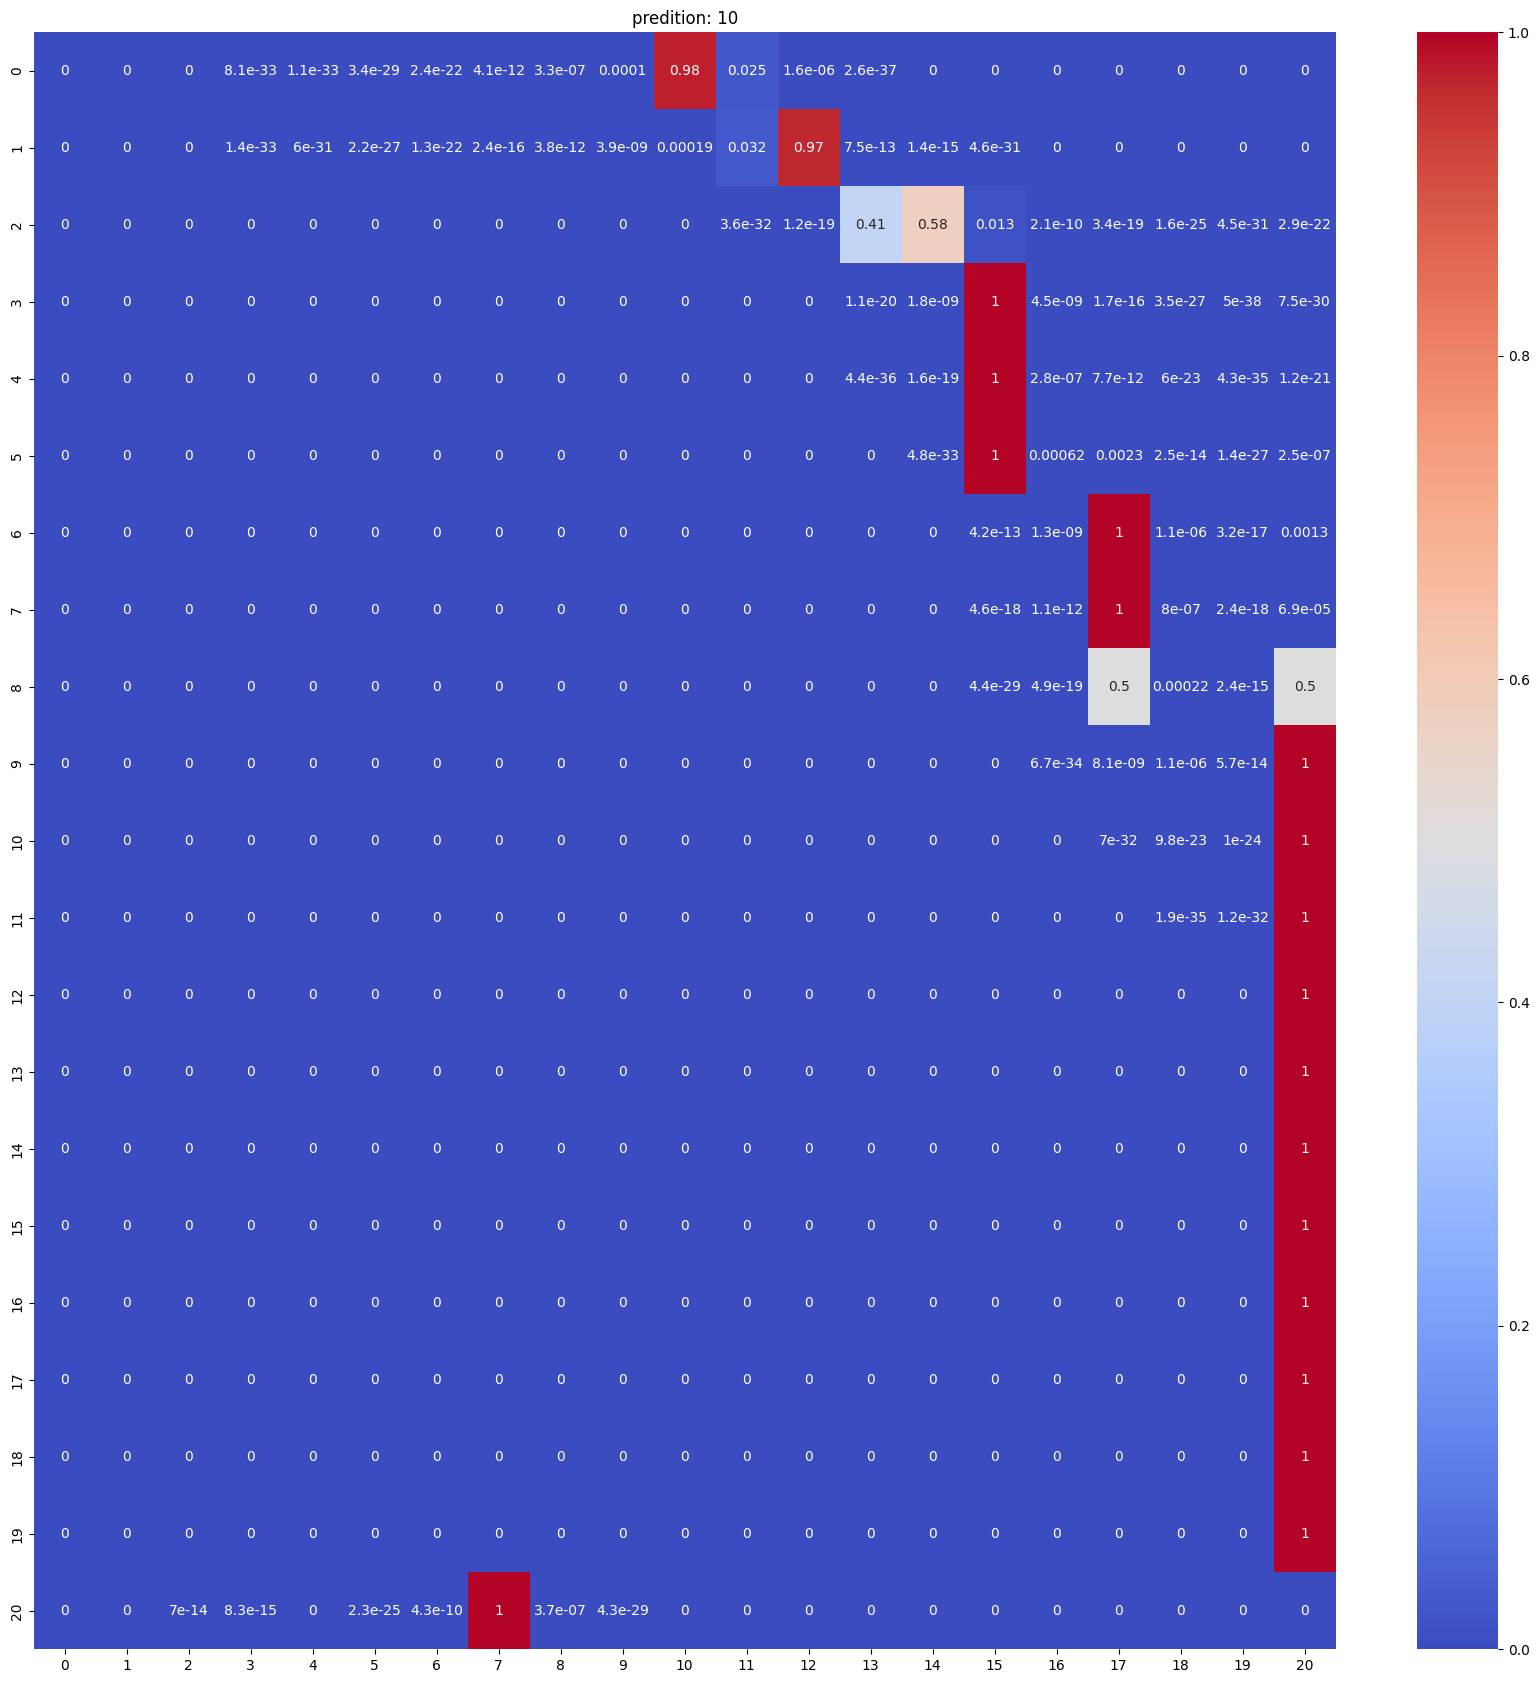

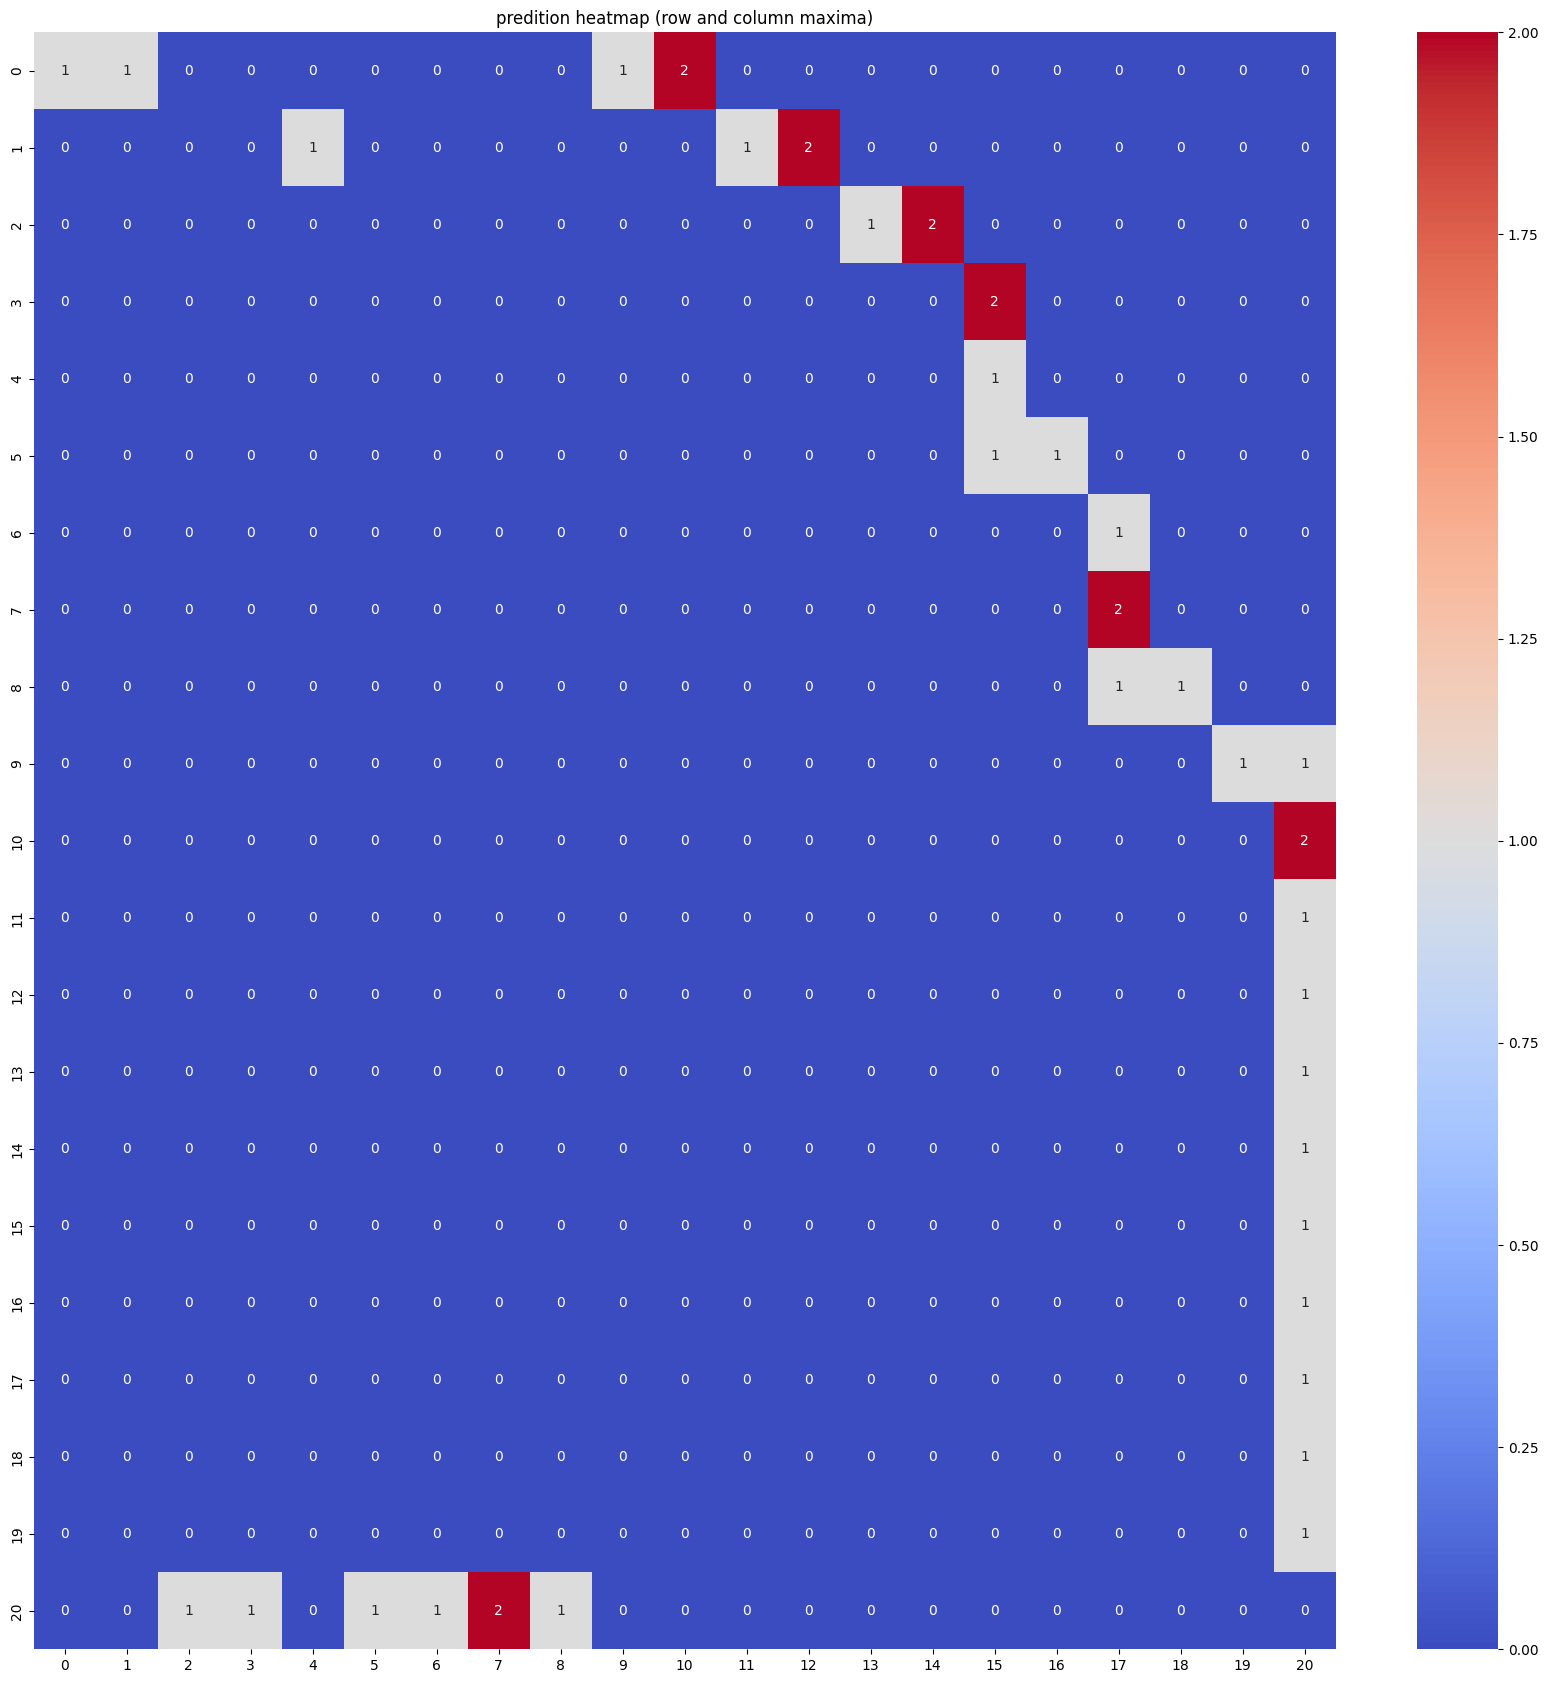

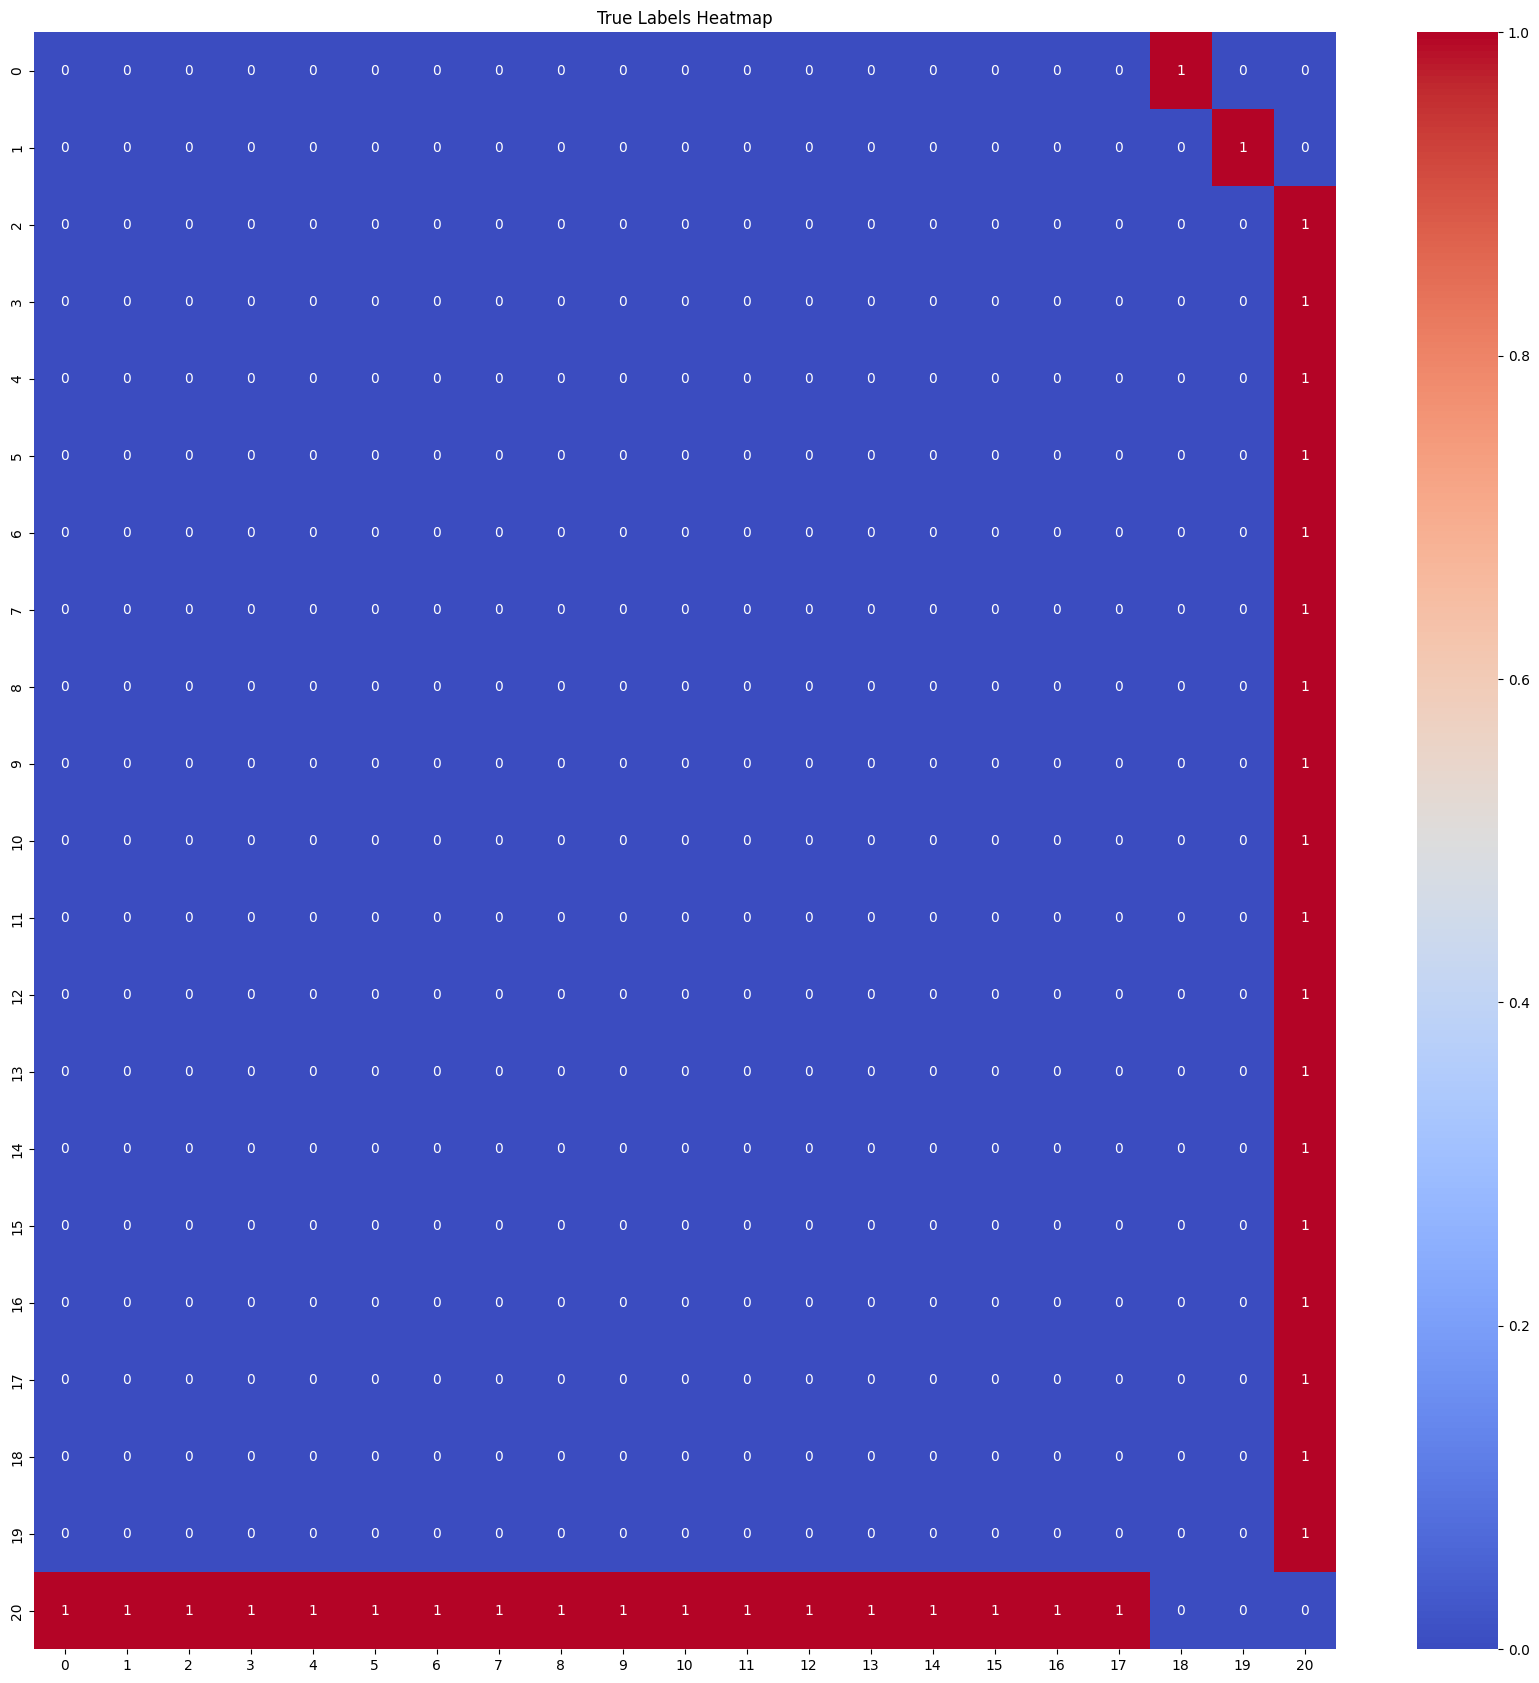

In [10]:
model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

# model.predict(
#     feature_loc,
#     weight_name= weight_name,
#     video_pair= "12_02, 12_03",
#     output_path= f"/home/jireh/MT/video_sync_v1/trash/output_{num_heads}_{num_layers}_tr20_te{len_video}"

# Train the model
model.train(
    feature_loc,
    batch_size=1024,
    epochs=700,
    learning_rate=lr,
    weight_name= weight_name
)

In [6]:
# Instantiate the modss
num_heads = 4 # 8,4,1
embed_dim = 48  # 768  48
num_layers = 1 # 4,2,1
lr = 1e-2
len_video = 10
# weight_name = f'weights_swin1_{num_heads}_{num_layers}.h5'
weight_name = f'weights_1_{num_heads}_{num_layers}.h5'

print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}", sep="\n")
print(f"Learning rate: {lr}", f"Weight name: {weight_name}", sep="\n")
print(f"Video length:{len_video}")

# extracted feature
feature_loc = f"/home/jireh/MT/video_sync_v1/trash/featureData_len{len_video}.npy"
trainDS = np.load(feature_loc,allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
df.head()

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 1
Learning rate: 0.01
Weight name: weights_1_4_1.h5
Video length:10
(10, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 1.8302742, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.030471, 0.0, 0.0, 0.0, 0.11...",3721,3720,-1
1,"[[0.0, 0.0, 0.0, 1.1439848, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.1778598, 0.0, 0.0, 0.0, 0.5...",5147,5154,7
2,"[[0.0, 0.0, 0.0, 1.8922992, 0.0, 0.0, 0.0, 0.2...","[[0.0, 0.0, 0.0, 1.4922466, 0.0, 0.0, 0.0, 0.0...",3507,3507,0
3,"[[0.0, 0.0, 0.0, 2.4569643, 0.0, 0.0, 0.0, 0.1...","[[0.0, 0.0, 0.0, 1.9808184, 0.0, 0.0, 0.0, 0.0...",8330,8327,-3
4,"[[0.0, 0.0, 0.0, 1.5164406, 0.0, 0.0, 0.0, 0.2...","[[0.0, 0.0, 0.0, 2.130628, 0.0, 0.0, 0.0, 0.08...",3871,3881,10


## test on different len


Final predictions after training:
Predicted: [-1, -2, 0, 1, -1, 2, 2, 1, 0, -1, 0, -2, -2, 0, 2, 1, 8, -4, -2, 2, -1, -6, 2, 1, 4, -2, -3, -1, -7, 0]
True: [-1, 7, 0, -3, 0, 0, 2, -5, 2, -6, -6, 9, 3, 0, 5, 6, -9, 5, 9, -8, -1, 0, -9, -4, -9, 6, -7, 8, 6, 5]
Accuracy in total: 0.20791088580576308
F1 score: 0.20791088580576308
Mean Absolute Error: 4.707310565635005

Heatmap visualization for first prediction:


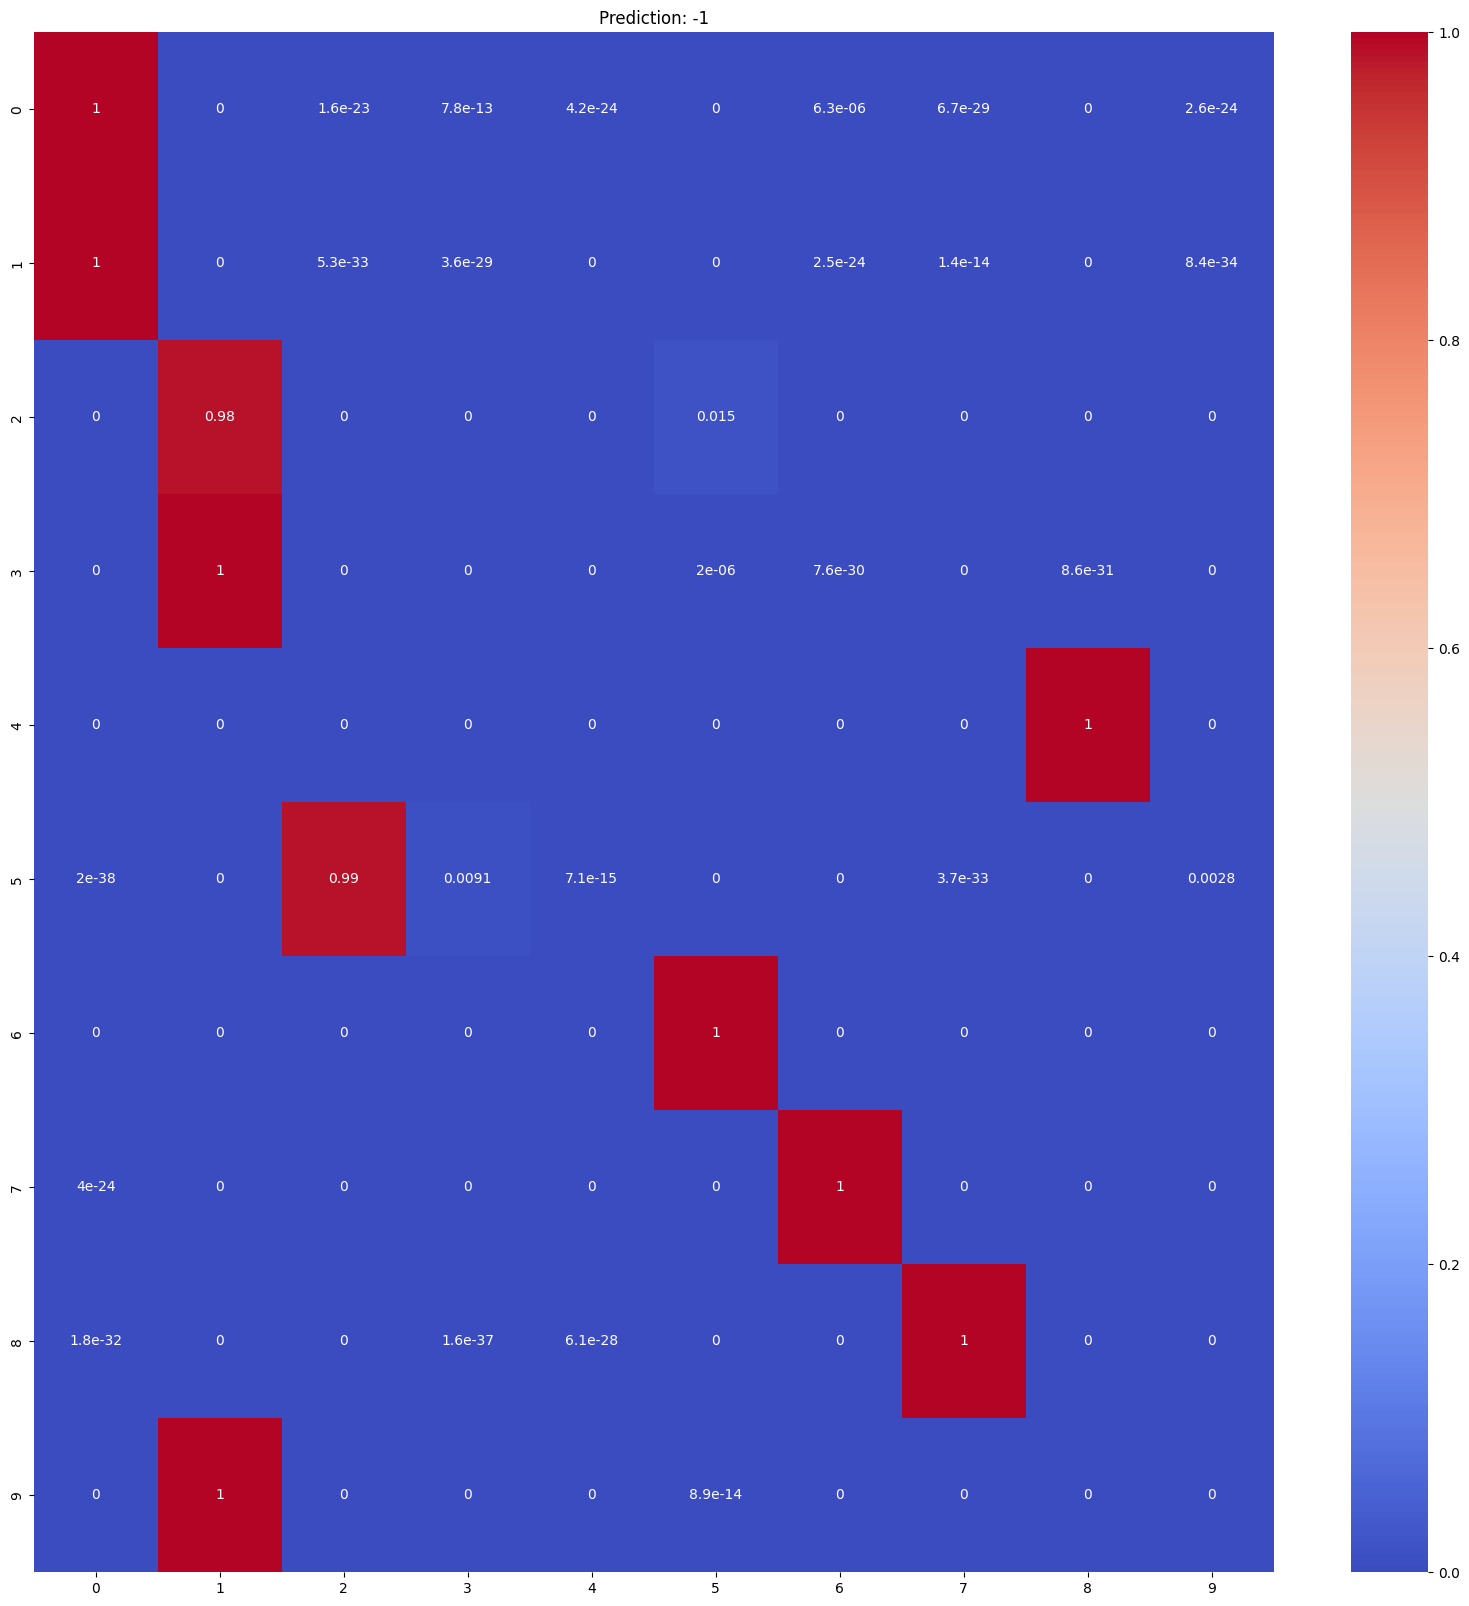

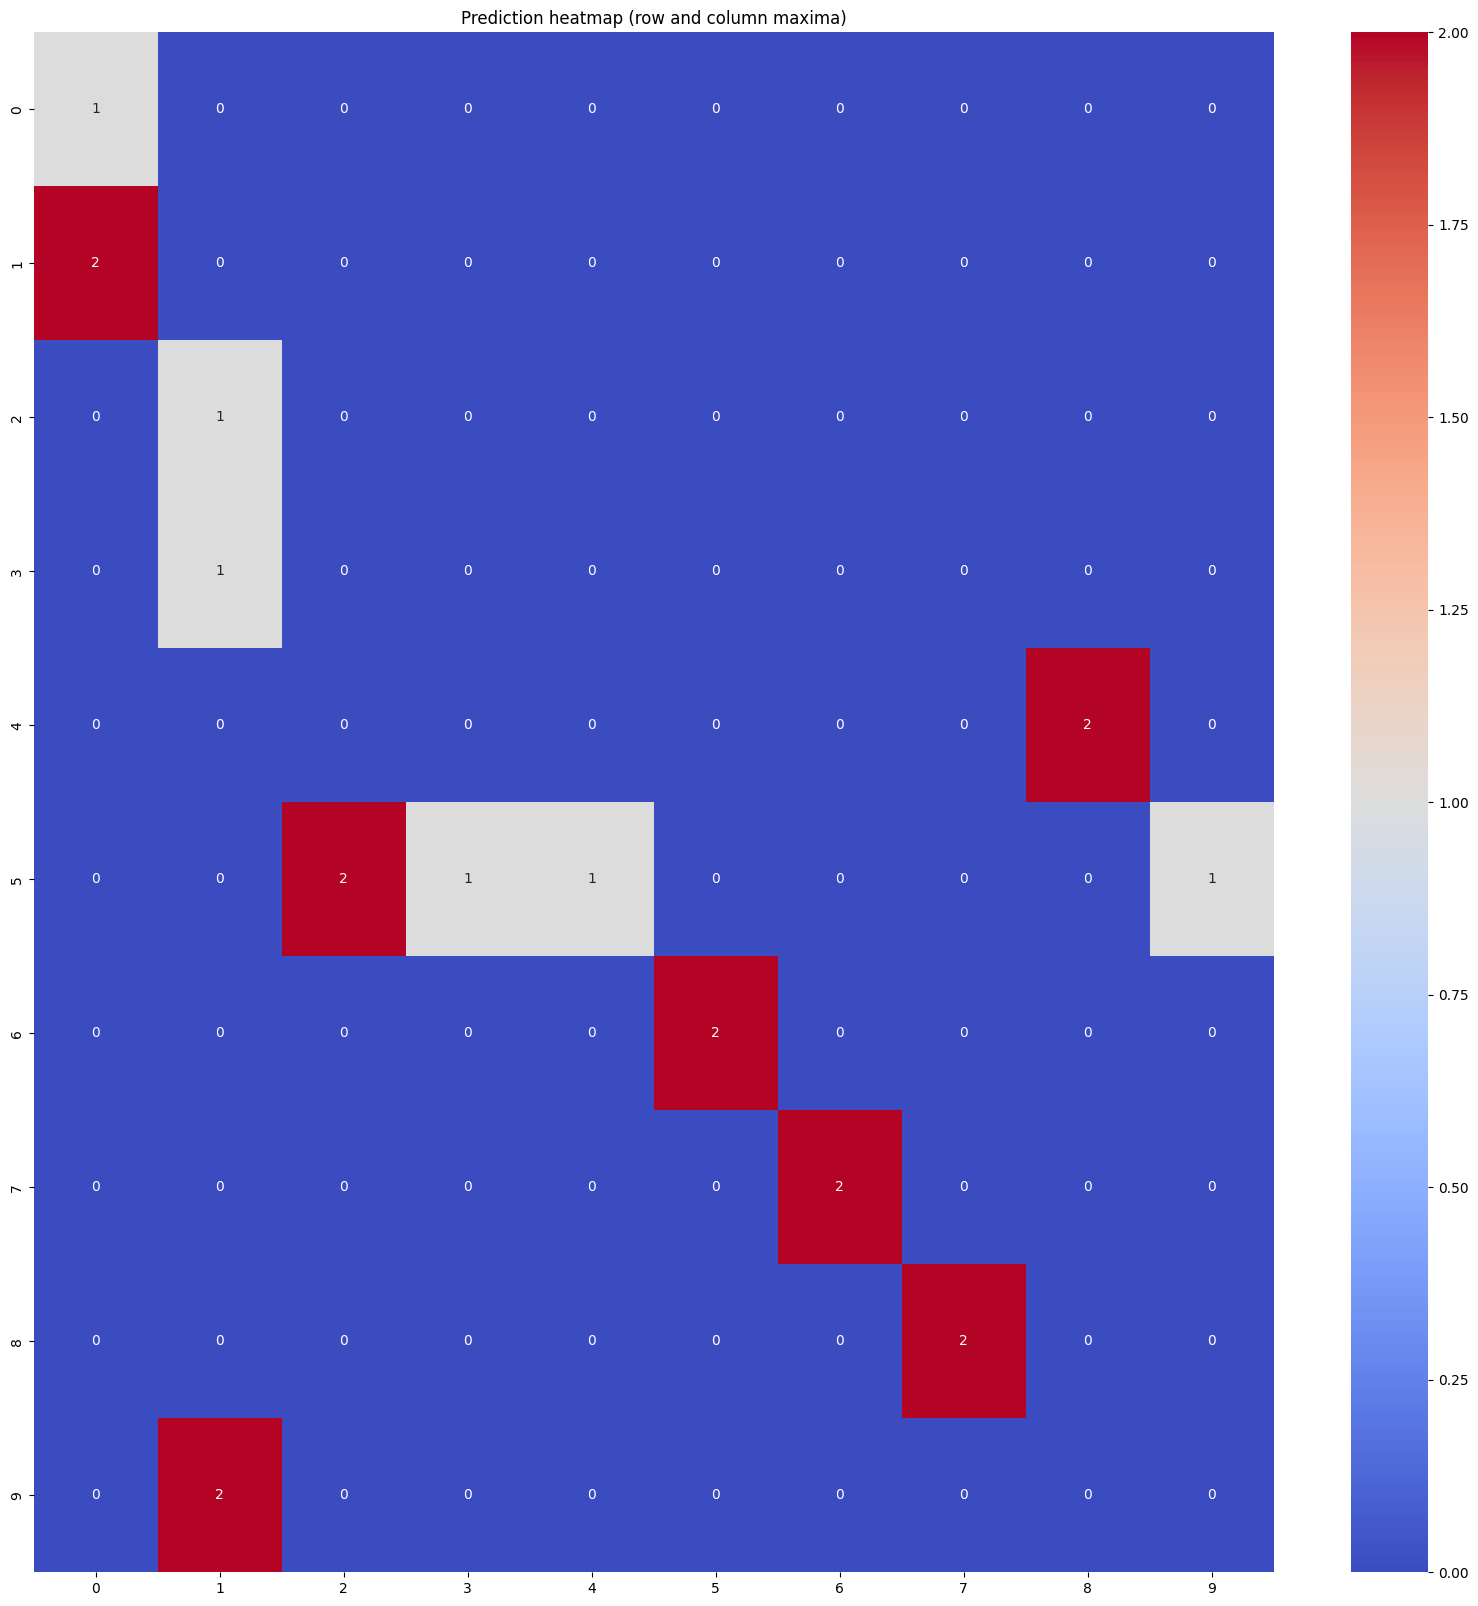

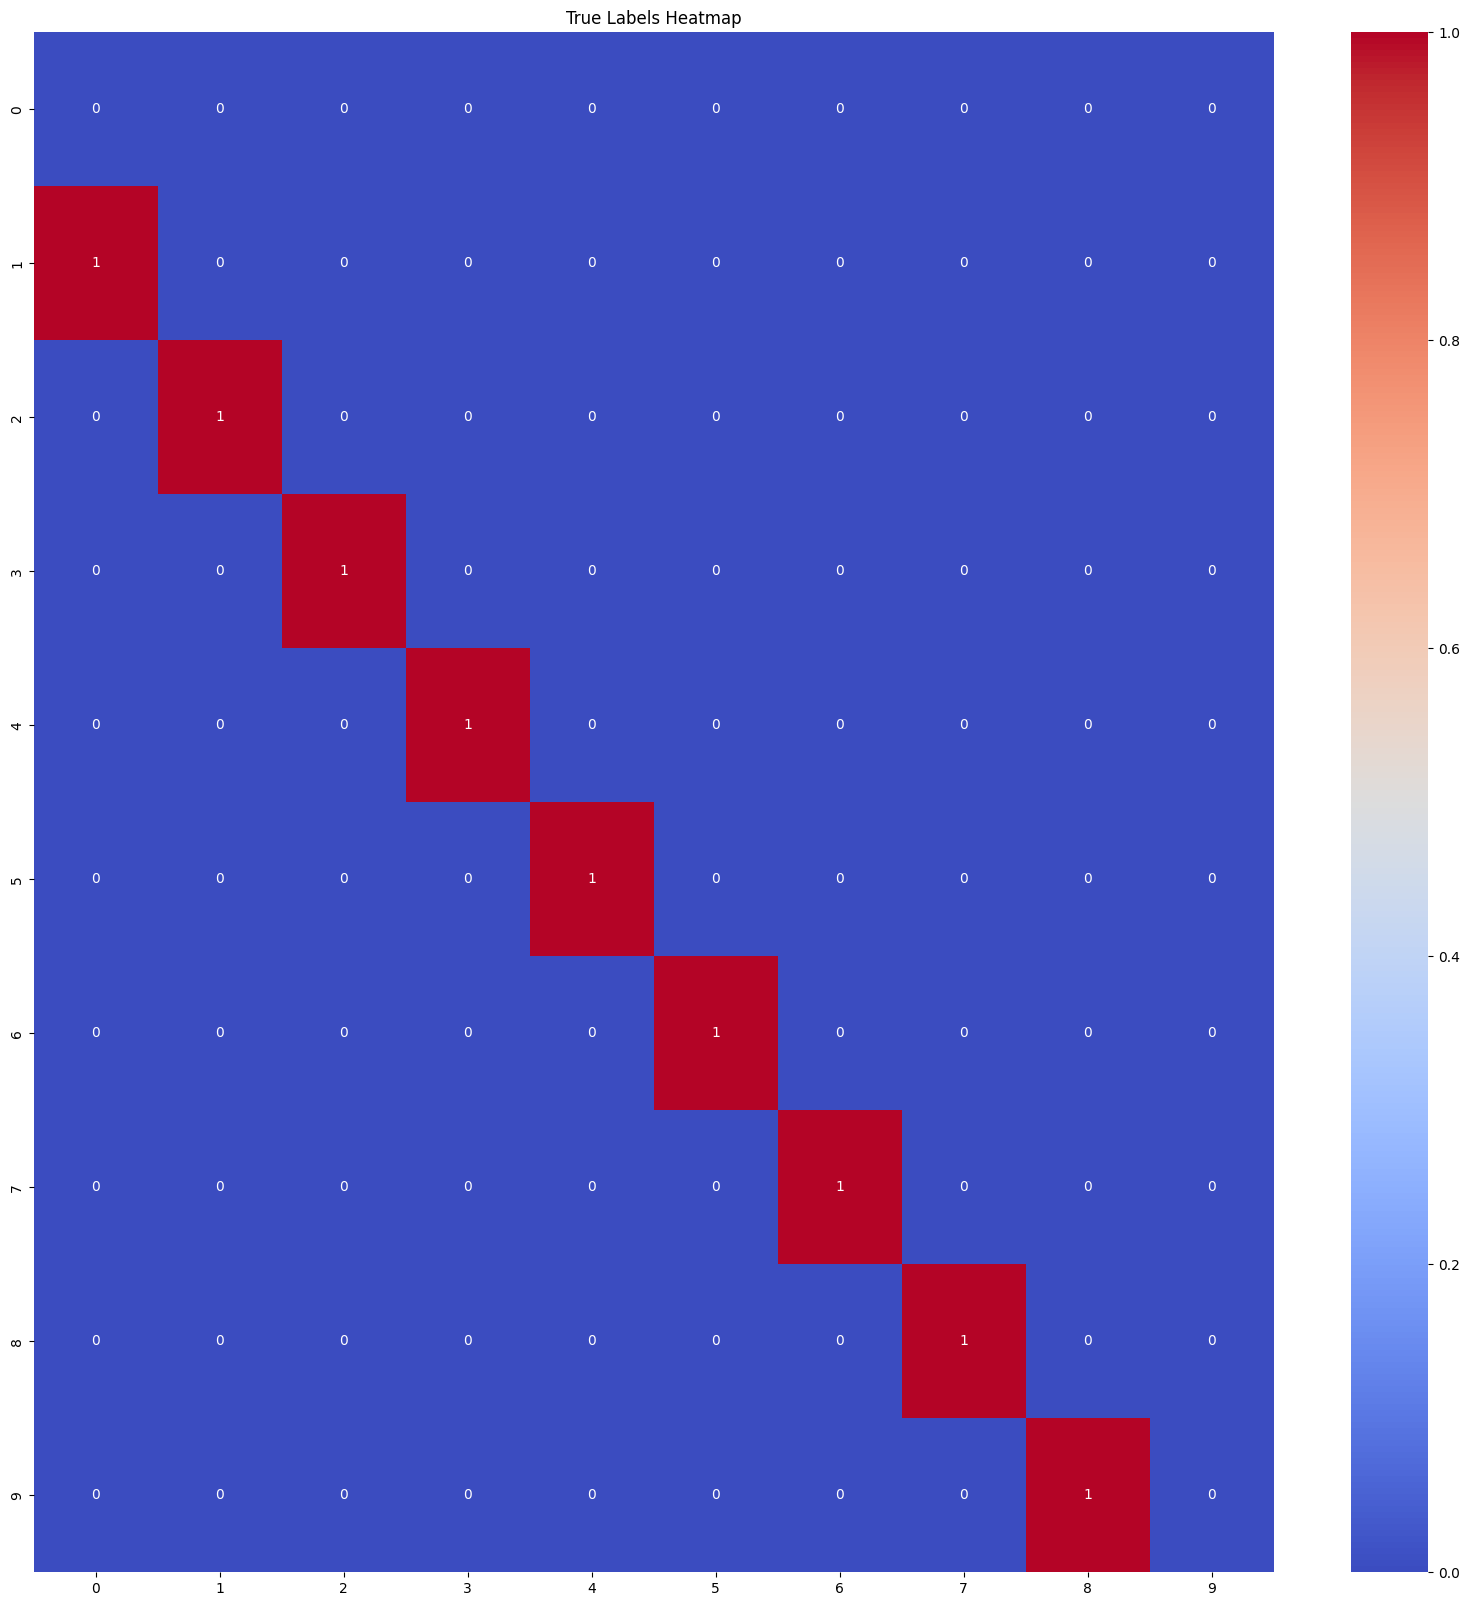

In [7]:
model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

model.predict(
    feature_loc,
    weight_name= weight_name,
    video_pair= "12_02, 12_03",
    output_path= f"/home/jireh/MT/video_sync_v1/trash/output_{num_heads}_{num_layers}_tr20_te{len_video}"
)

In [8]:
# Instantiate the model
num_heads = 4 # 8,4,1
embed_dim = 48  # 768  48
num_layers = 1 # 4,2,1
lr = 1e-2
len_video = 15
# weight_name = f'weights_swin1_{num_heads}_{num_layers}.h5'
weight_name = f'weights_1_{num_heads}_{num_layers}.h5'

print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}", sep="\n")
print(f"Learning rate: {lr}", f"Weight name: {weight_name}", sep="\n")
print(f"Video length:{len_video}")

# extracted feature
feature_loc = f"/home/jireh/MT/video_sync_v1/trash/featureData_len{len_video}.npy"
trainDS = np.load(feature_loc,allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
df.head()

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 1
Learning rate: 0.01
Weight name: weights_1_4_1.h5
Video length:15
(15, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 1.4587663, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.8276558, 0.0, 0.0, 0.0, 0.0...",8875,8864,-11
1,"[[0.0, 0.0, 0.0, 1.8599888, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.895601, 0.0, 0.0, 0.0, 0.83...",3398,3406,8
2,"[[0.0, 0.0, 0.0, 2.1654031, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.2067645, 0.0, 0.0, 0.0, 0.2...",5481,5490,9
3,"[[0.0, 0.0, 0.0, 2.8359895, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.2493637, 0.0, 0.0, 0.0, 0.0...",3528,3535,7
4,"[[0.0, 0.0, 0.0, 2.0219367, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.4300072, 0.0, 0.0, 0.0, 0.8...",5051,5041,-10



Final predictions after training:
Predicted: [0, -3, -4, -11, -8, -2, -13, -2, -10, -8, 10, -6, 4, 4, -2, 2, -11, -8, -4, -11, -6, -2, -11, 2, -1, -11, -10, 1, 0, -8]
True: [-11, 8, 9, 7, -10, -2, -7, -2, -4, 8, -13, -6, 6, -13, -2, 2, 11, 14, -4, -5, -6, 0, -10, 7, -1, 6, -4, -10, 0, 10]
Accuracy in total: 0.415454909284952
F1 score: 0.415454909284952
Mean Absolute Error: 5.912886872998933

Heatmap visualization for first prediction:


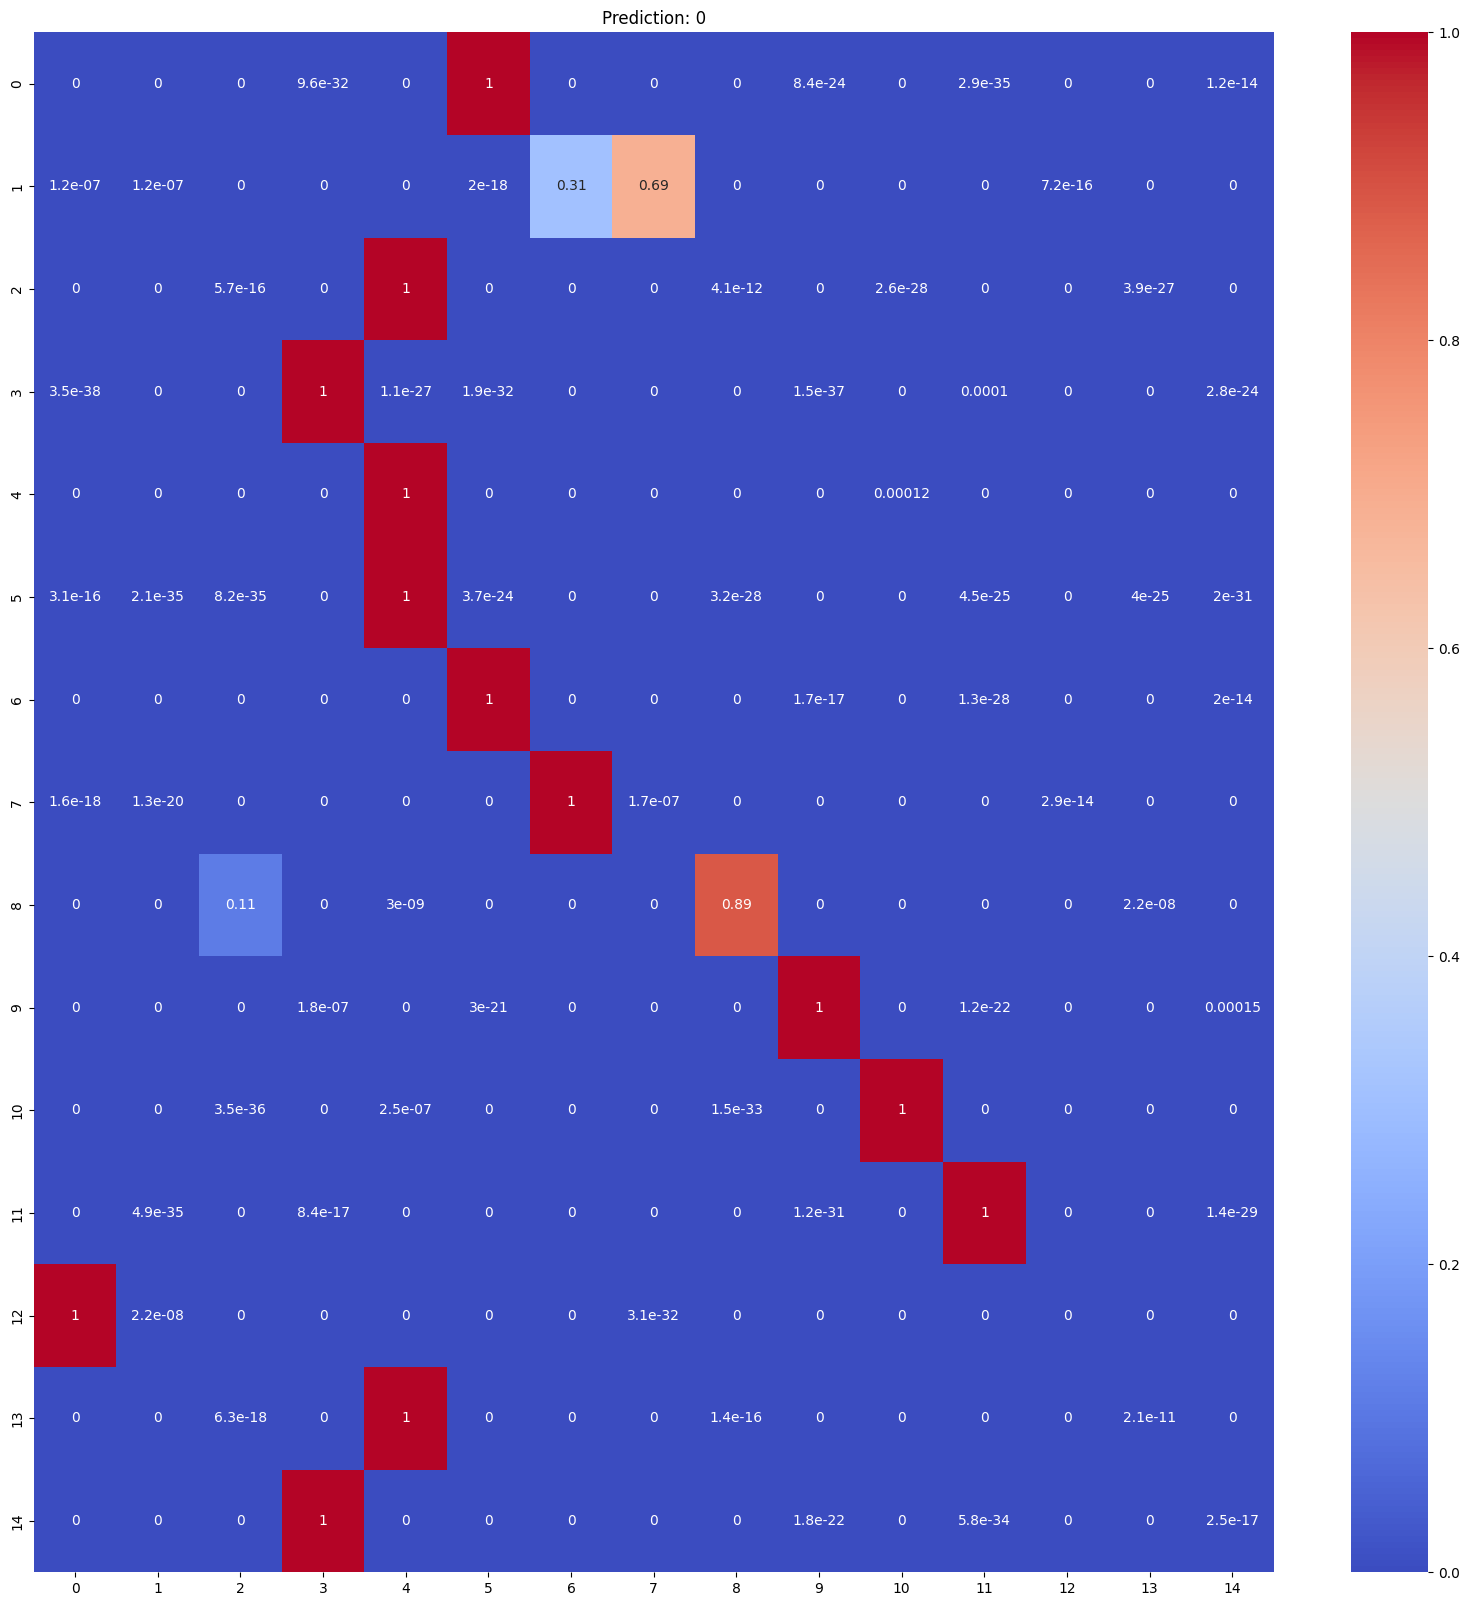

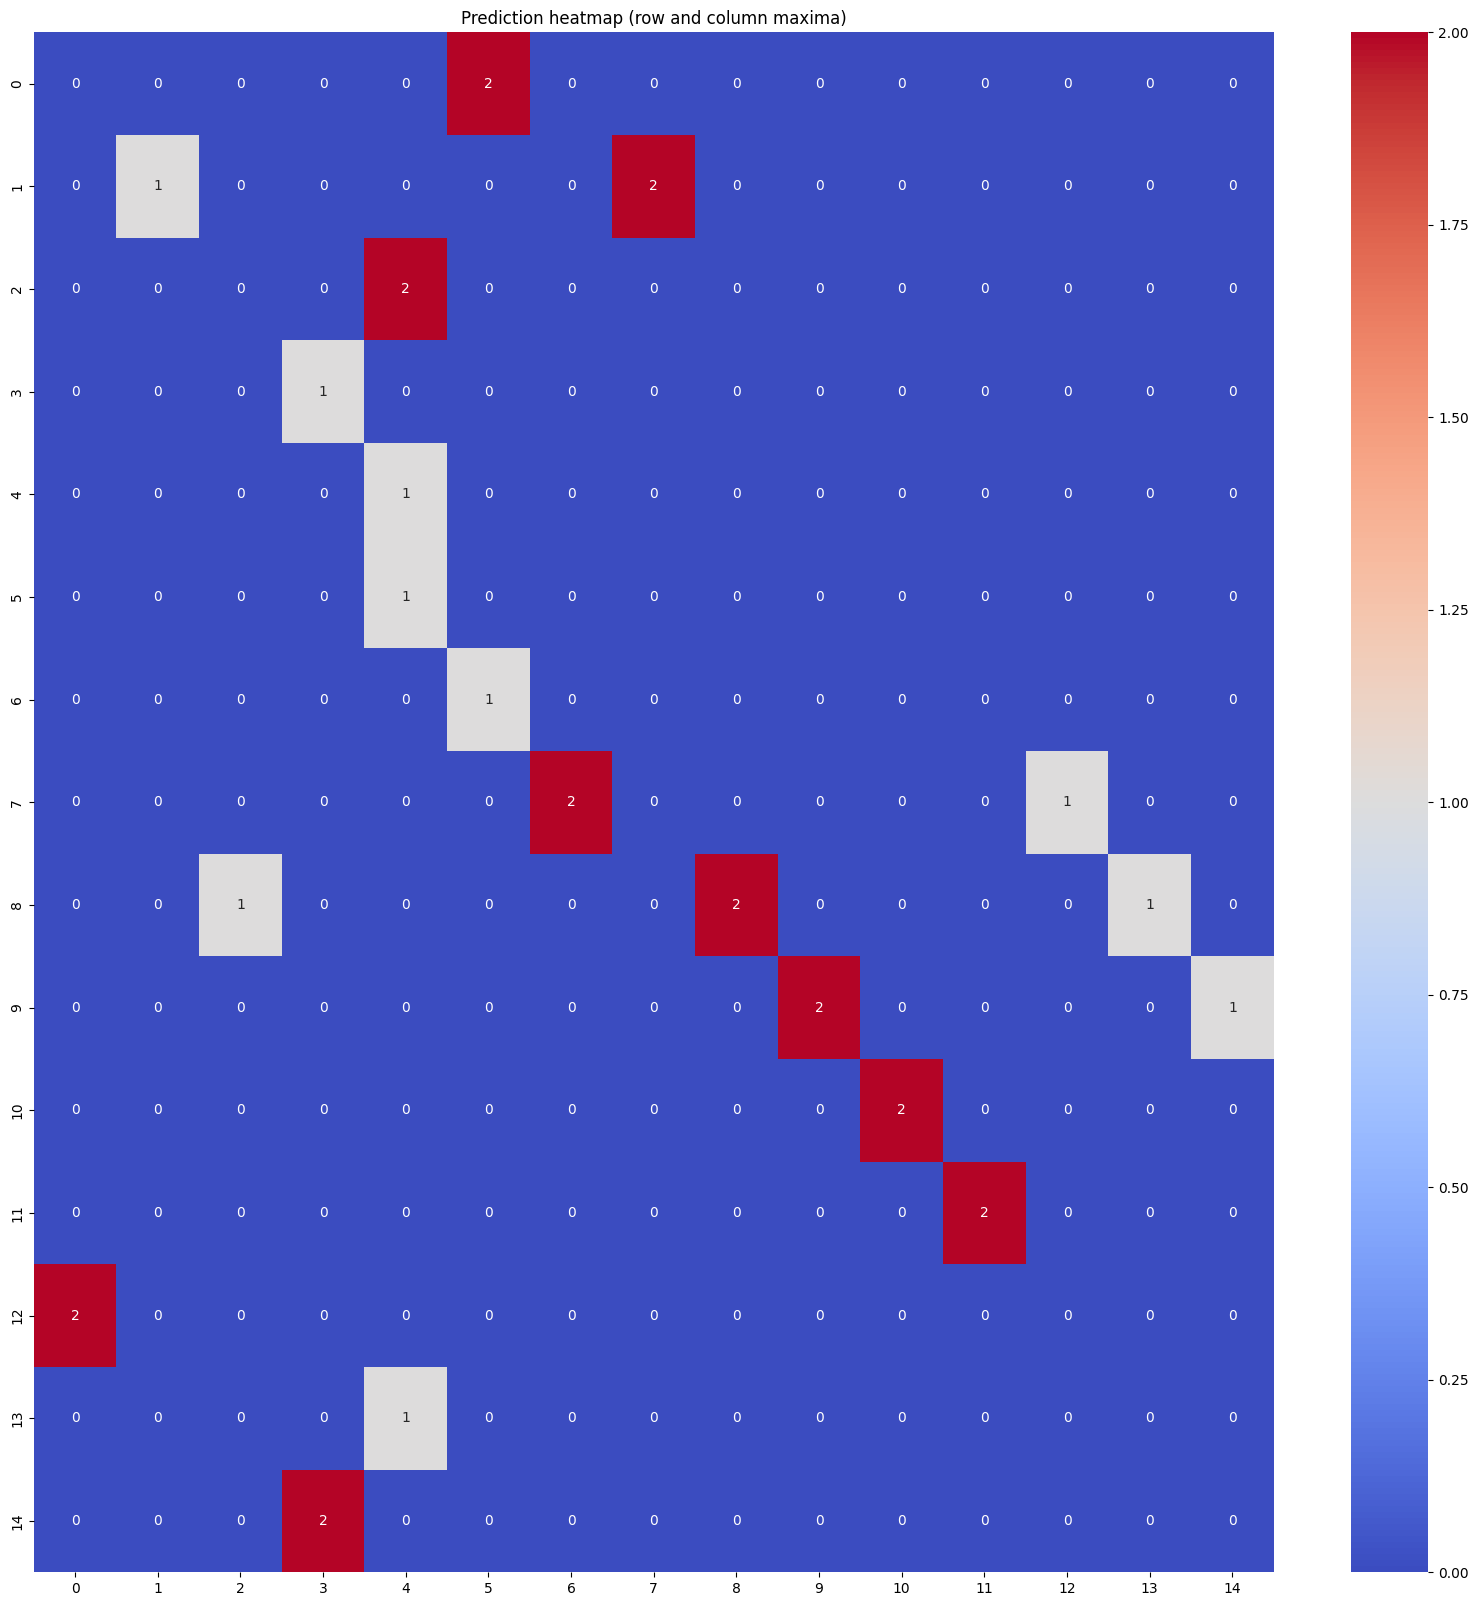

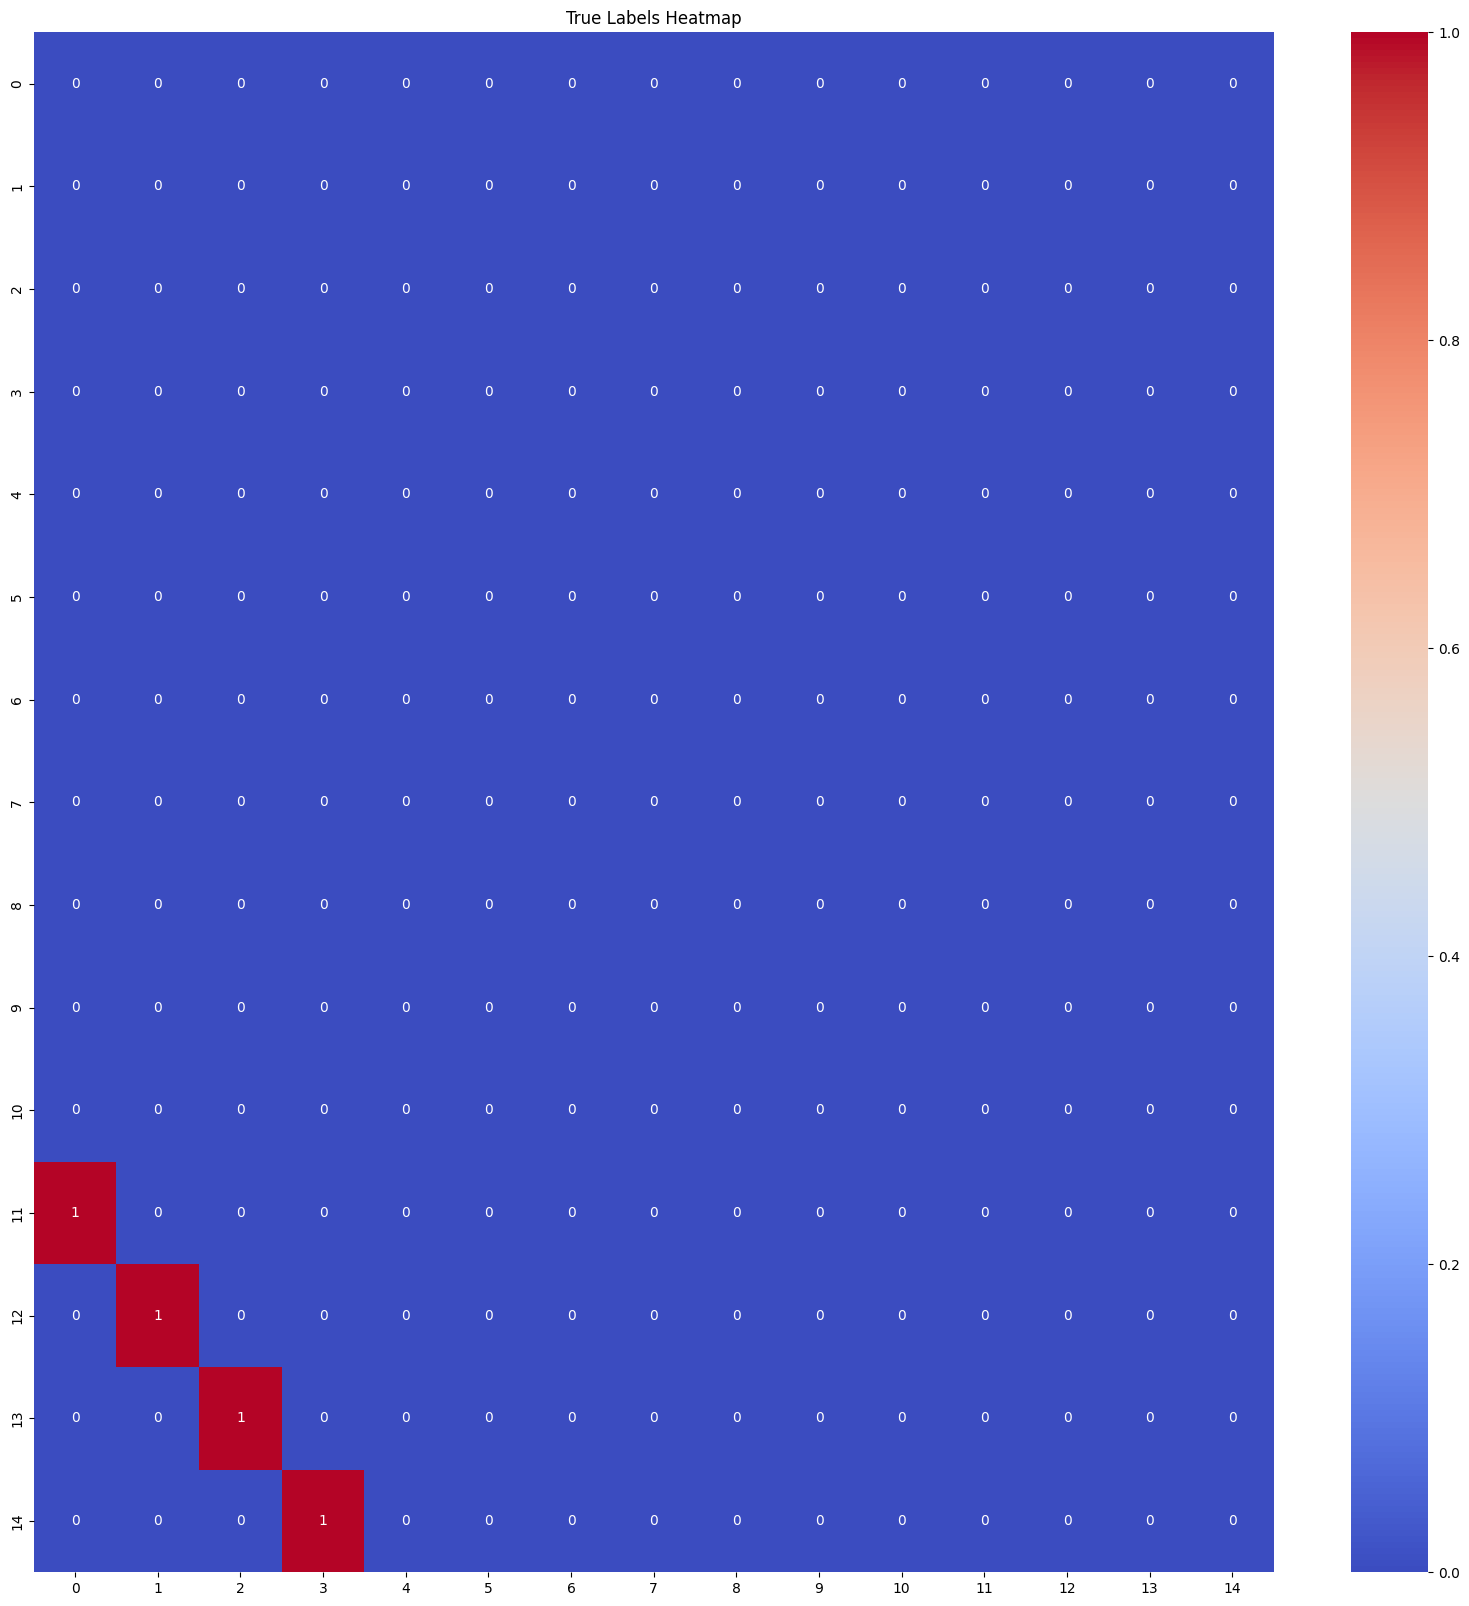

In [9]:
model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

model.predict(
    feature_loc,
    weight_name= weight_name,
    video_pair= "12_02, 12_03",
    output_path= f"/home/jireh/MT/video_sync_v1/trash/output_{num_heads}_{num_layers}_tr20_te{len_video}"
)

In [10]:
# Instantiate the model
num_heads = 4 # 8,4,1
embed_dim = 48  # 768  48
num_layers = 1 # 4,2,1
lr = 1e-2
len_video = 20
# weight_name = f'weights_swin1_{num_heads}_{num_layers}.h5'
weight_name = f'weights_1_{num_heads}_{num_layers}.h5'

print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}", sep="\n")
print(f"Learning rate: {lr}", f"Weight name: {weight_name}", sep="\n")
print(f"Video length:{len_video}")

# extracted feature
feature_loc = f"/home/jireh/MT/video_sync_v1/trash/featureData_len{len_video}.npy"
trainDS = np.load(feature_loc,allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
df.head()

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 1
Learning rate: 0.01
Weight name: weights_1_4_1.h5
Video length:20
(20, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 1.9752103, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.3730679, 0.0, 0.0, 0.0, 0.0...",8285,8301,16
1,"[[0.0, 0.0, 0.0, 2.2332666, 0.0, 0.0, 0.0, 0.3...","[[0.0, 0.0, 0.0, 2.090584, 0.0, 0.0, 0.0, 0.0,...",5390,5399,9
2,"[[0.0, 0.0, 0.0, 2.4449923, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.4967878, 0.0, 0.0, 0.0, 0.0...",3469,3474,5
3,"[[0.0, 0.0, 0.0, 2.7320762, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.917353, 0.0, 0.0, 0.0, 0.25...",8639,8627,-12
4,"[[0.0, 0.0, 0.0, 1.4948902, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.4113626, 0.0, 0.0, 0.0, 0.0...",8059,8061,2



Final predictions after training:
Predicted: [16, 9, 5, -12, 2, -8, 5, -9, -3, 1, 13, 11, 5, 6, 15, 4, -11, -10, -3, -7, 2, -14, 7, -13, -17, 5, 3, 17, -5, 1]
True: [16, 9, 5, -12, 2, -19, -18, -9, -3, 1, 13, 11, 16, 6, 15, 4, -11, -10, -14, -7, 18, 0, -15, -13, -17, 5, 3, 17, 16, 1]
Accuracy in total: 0.759104855923159
F1 score: 0.7591048559231591
Mean Absolute Error: 4.071371398078975

Heatmap visualization for first prediction:


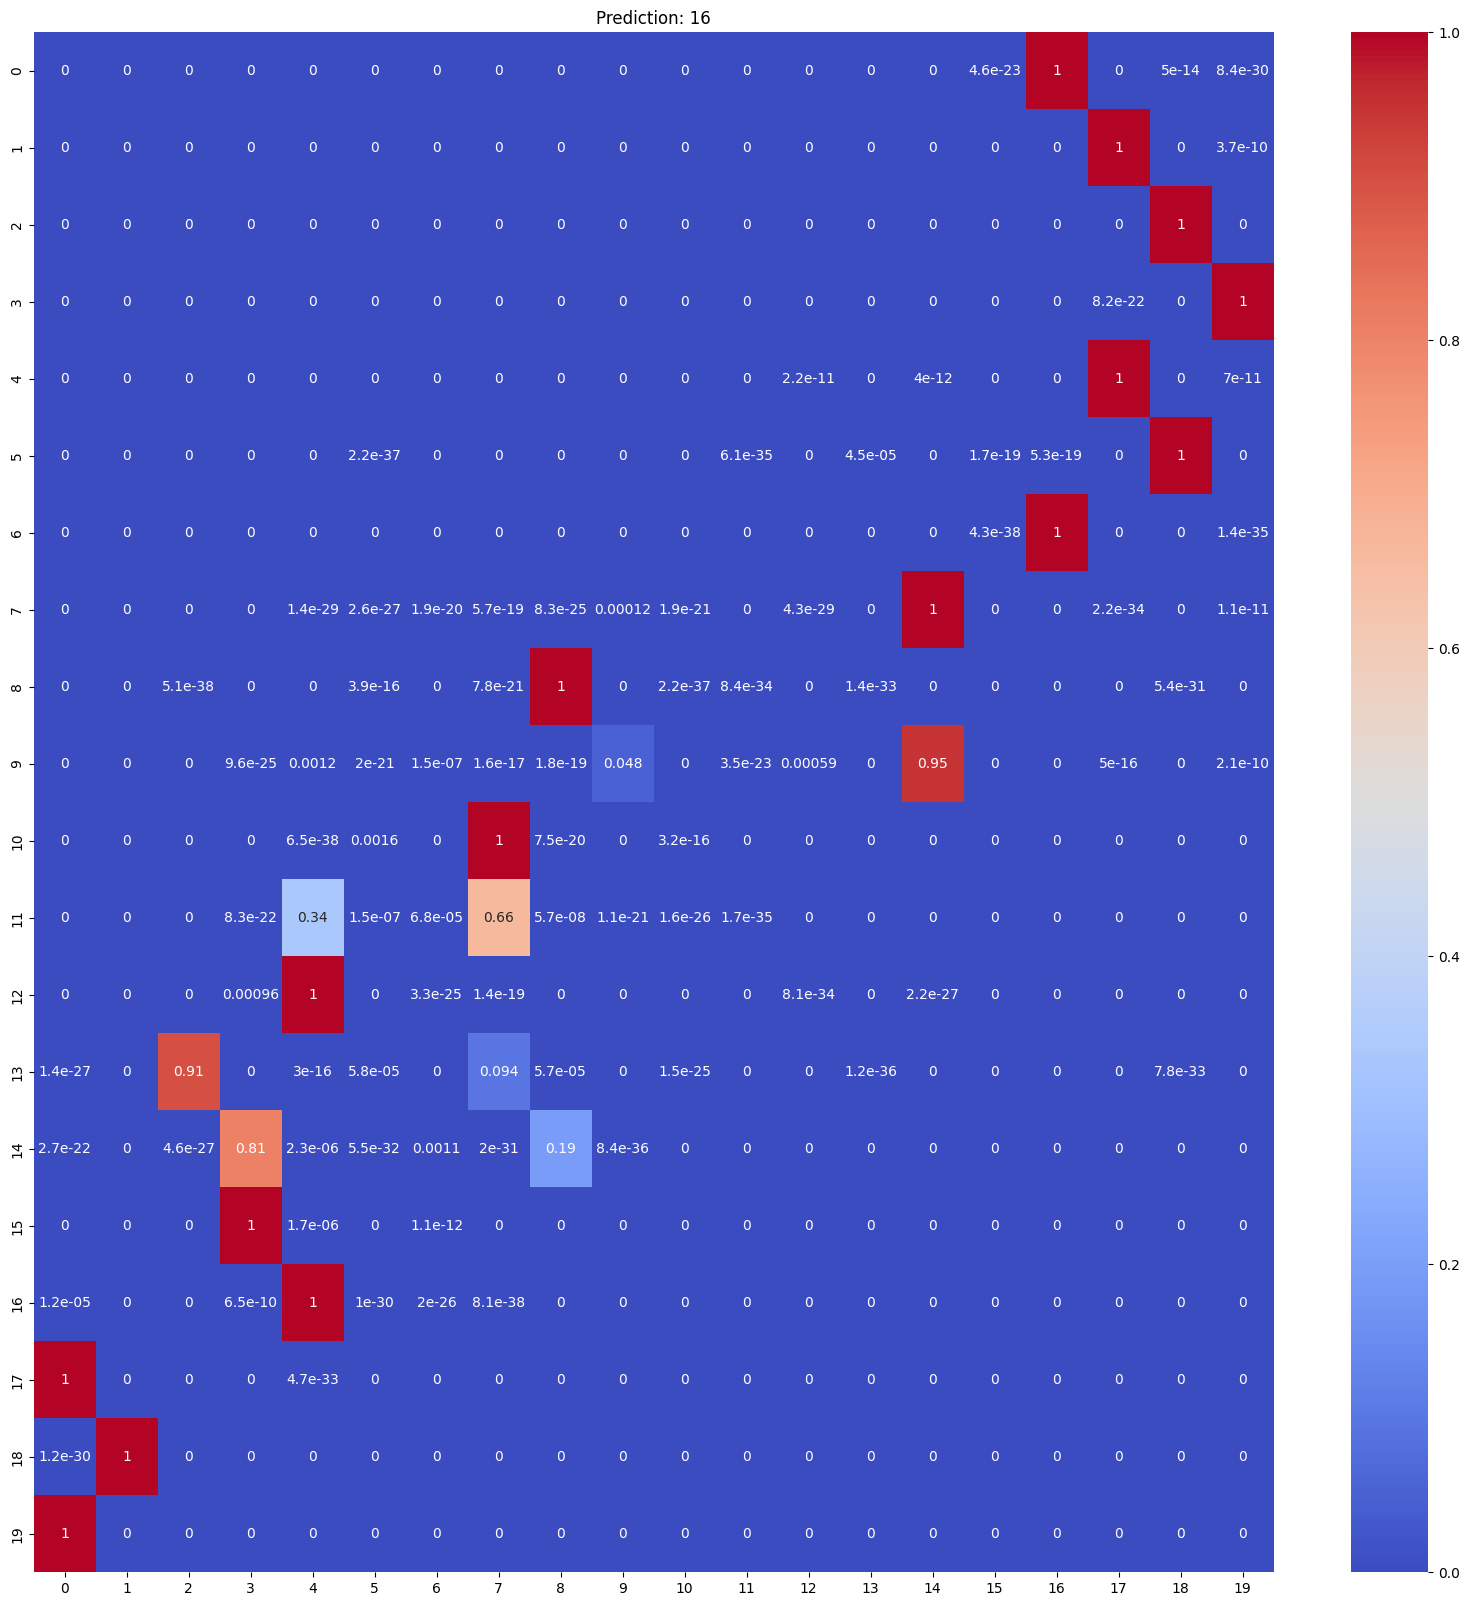

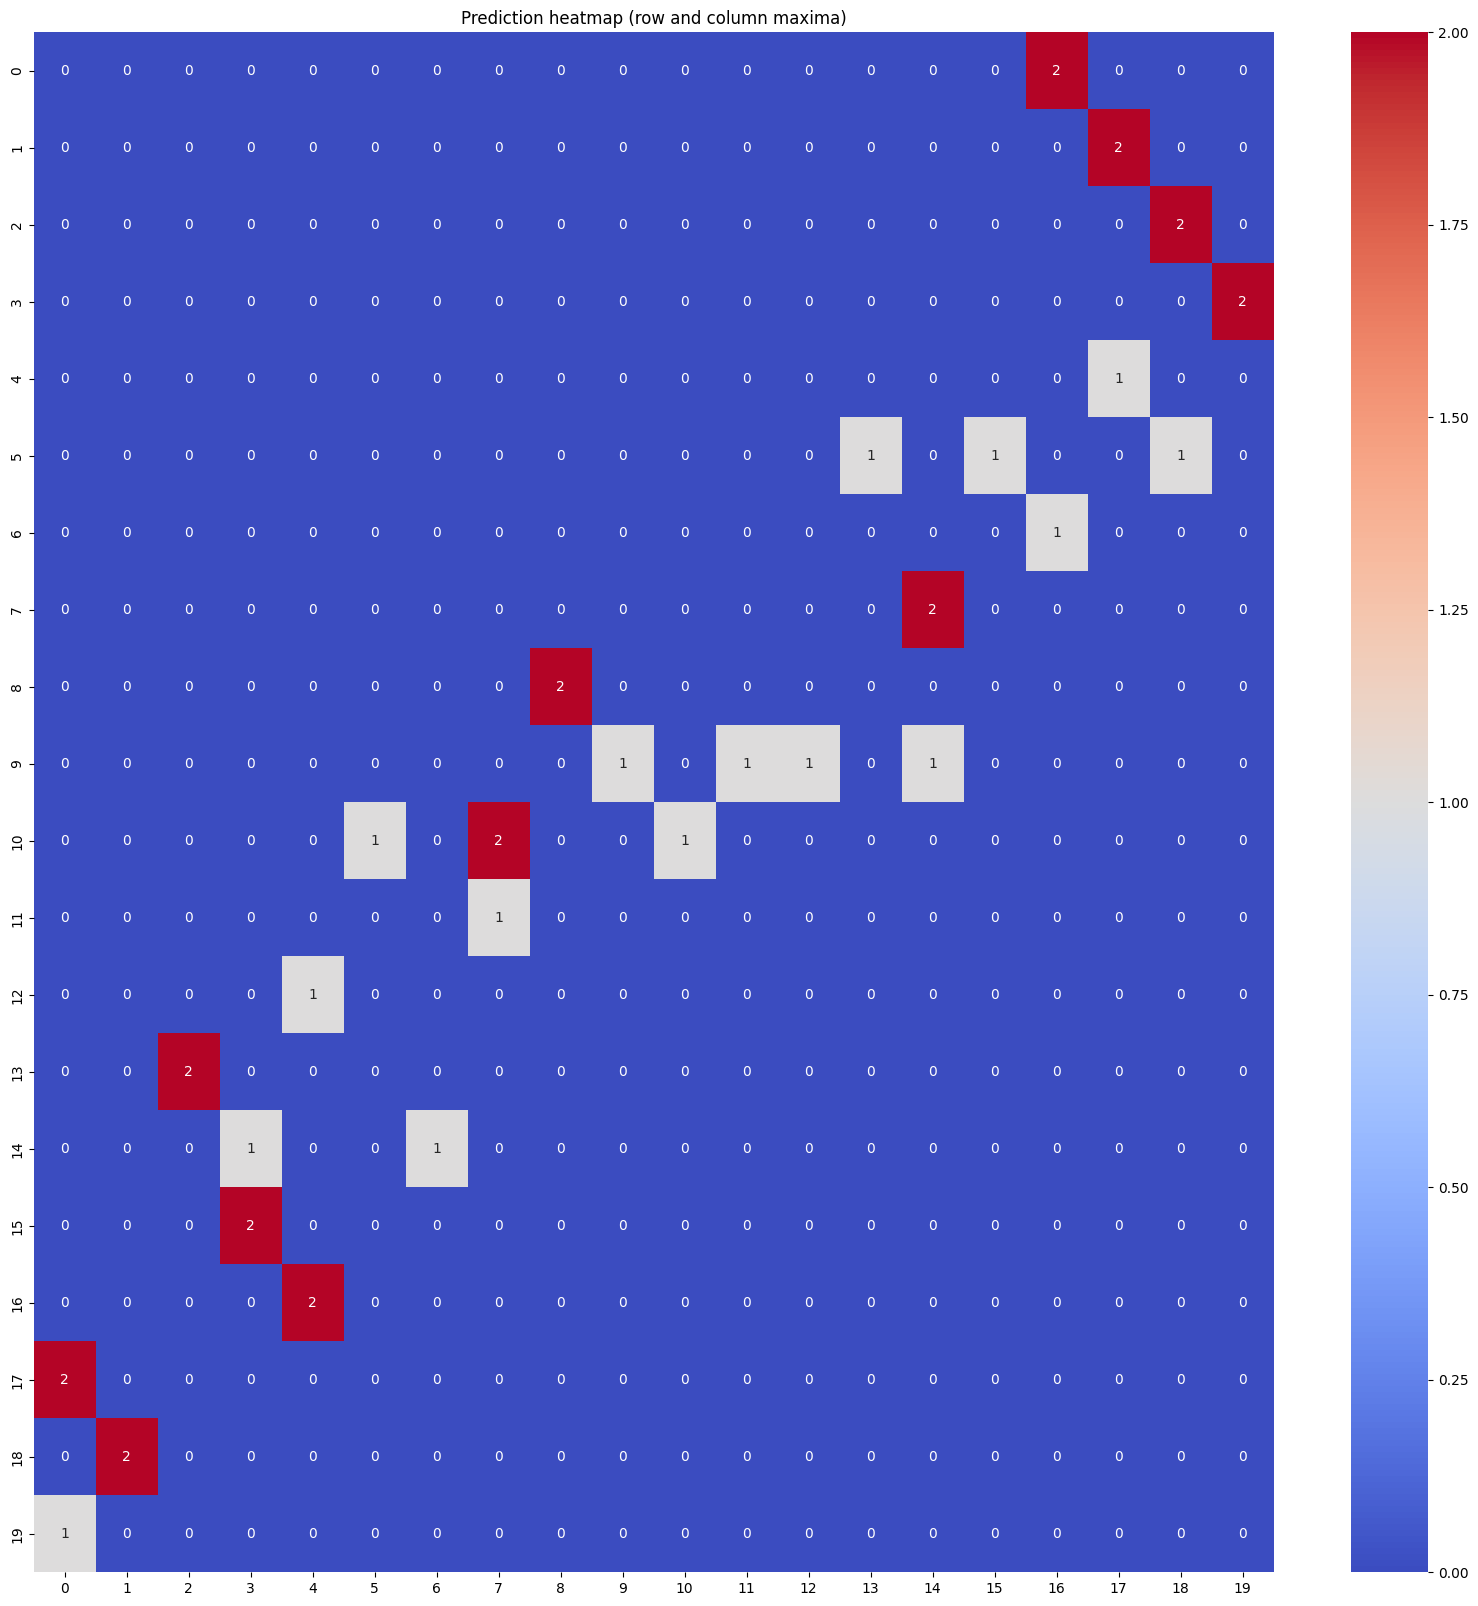

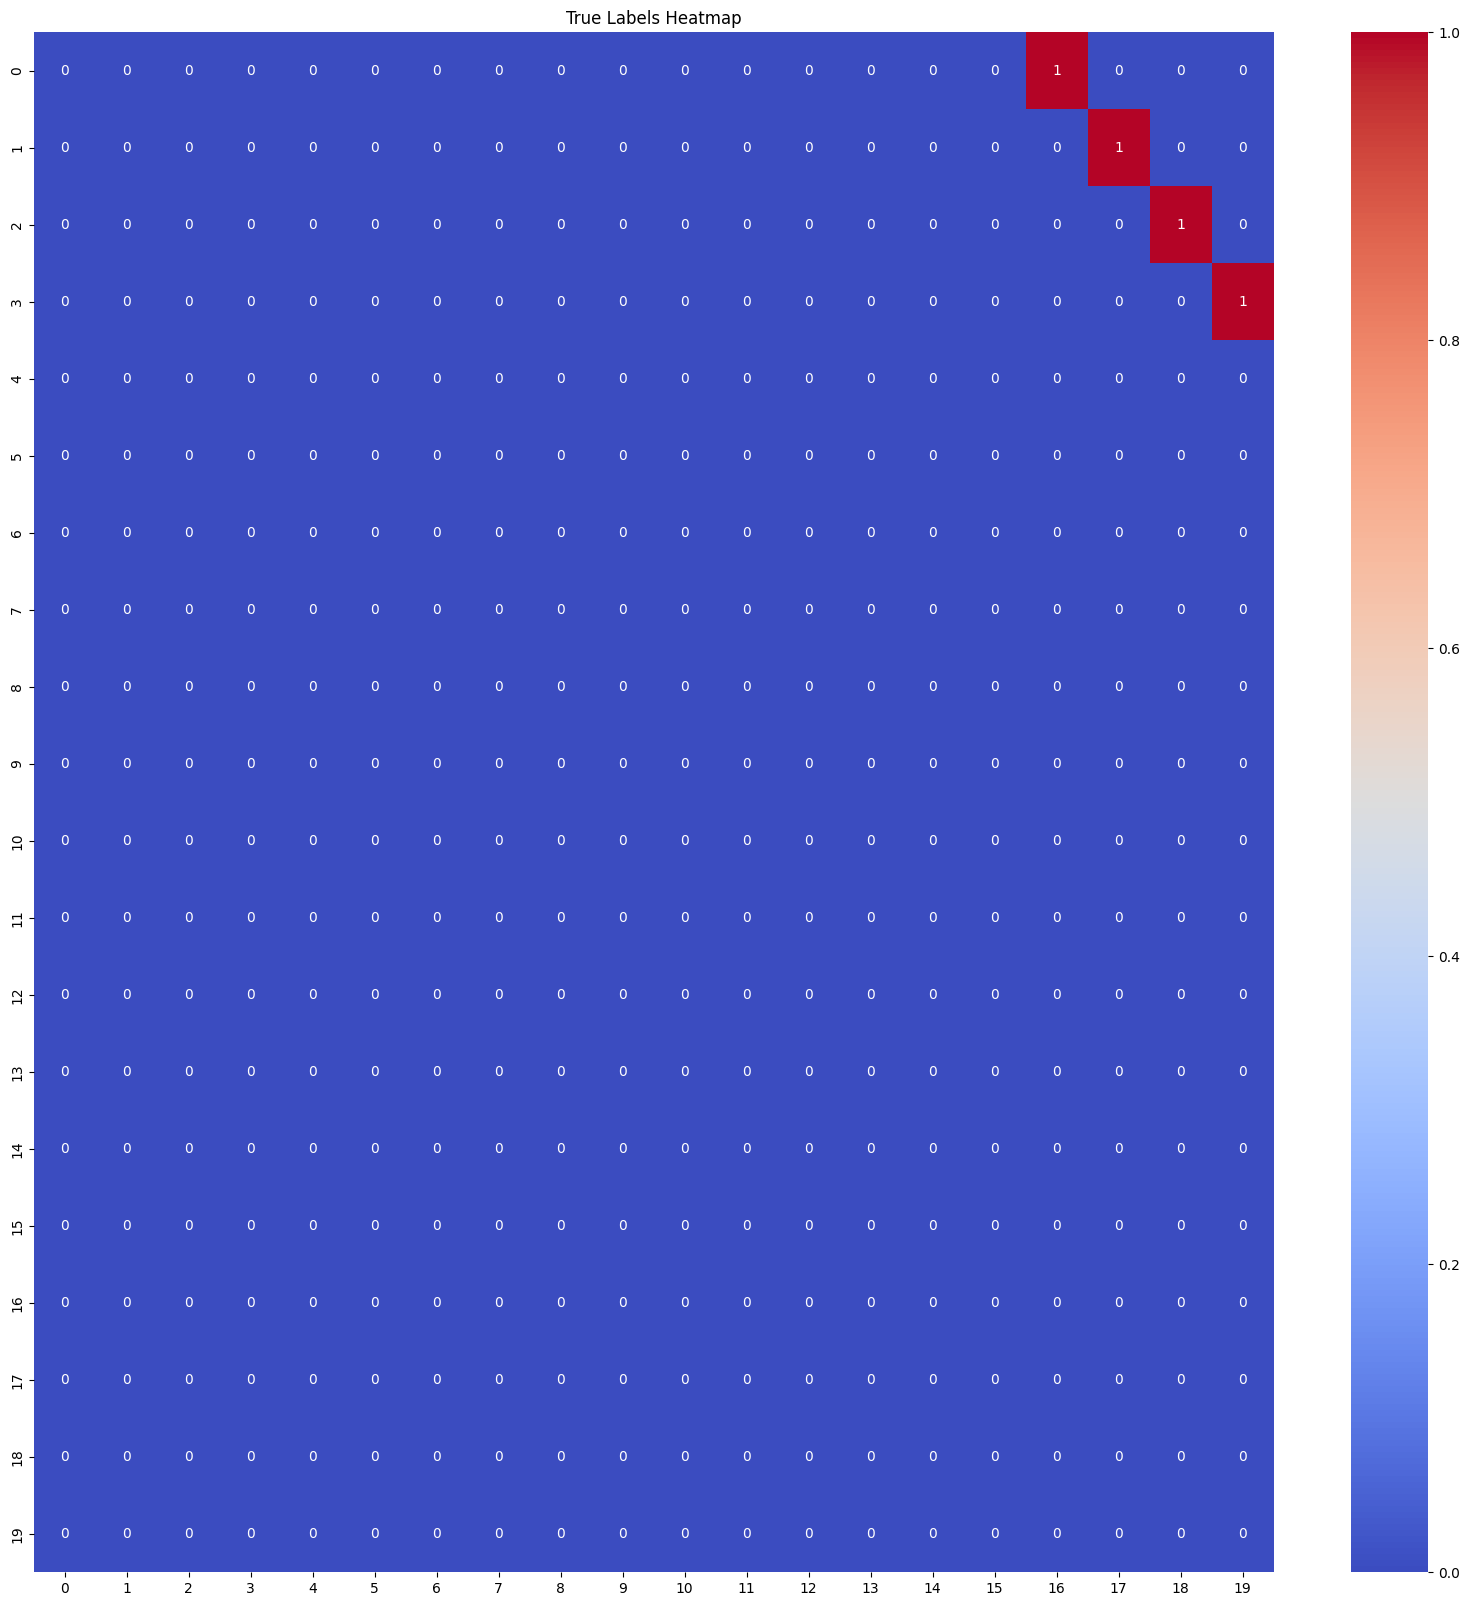

In [11]:
model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

model.predict(
    feature_loc,
    weight_name= weight_name,
    video_pair= "12_02, 12_03",
    output_path= f"/home/jireh/MT/video_sync_v1/trash/output_{num_heads}_{num_layers}_tr20_te{len_video}"
)

In [12]:
# Instantiate the model
num_heads = 4 # 8,4,1
embed_dim = 48  # 768  48
num_layers = 1 # 4,2,1
lr = 1e-2
len_video = 25
# weight_name = f'weights_swin1_{num_heads}_{num_layers}.h5'
weight_name = f'weights_1_{num_heads}_{num_layers}.h5'

print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}", sep="\n")
print(f"Learning rate: {lr}", f"Weight name: {weight_name}", sep="\n")
print(f"Video length:{len_video}")

# extracted feature
feature_loc = f"/home/jireh/MT/video_sync_v1/trash/featureData_len{len_video}.npy"
trainDS = np.load(feature_loc,allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
df.head()

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 1
Learning rate: 0.01
Weight name: weights_1_4_1.h5
Video length:25
(25, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 2.0916252, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.6164403, 0.0, 0.0, 0.0, 0.7...",2989,2985,-4
1,"[[0.0, 0.0, 0.0, 2.3302839, 0.0, 0.0, 0.0, 0.1...","[[0.0, 0.0, 0.0, 1.637668, 0.0, 0.0, 0.0, 1.21...",561,567,6
2,"[[0.0, 0.0, 0.0, 2.1109633, 0.0, 0.0, 0.0, 0.9...","[[0.0, 0.0, 0.0, 2.4085495, 0.0, 0.0, 0.0, 0.0...",2047,2027,-20
3,"[[0.0, 0.0, 0.0, 2.1803625, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.379746, 0.0, 0.0, 0.0, 0.0,...",6993,7006,13
4,"[[0.0, 0.0, 0.0, 2.187751, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.7227066, 0.0, 0.0, 0.0, 0.0...",1812,1808,-4


2024-10-18 06:34:33.918753: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 144000000 exceeds 10% of free system memory.
2024-10-18 06:34:34.039648: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 144000000 exceeds 10% of free system memory.
2024-10-18 06:34:34.163061: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 144000000 exceeds 10% of free system memory.
2024-10-18 06:34:34.246372: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 144000000 exceeds 10% of free system memory.
2024-10-18 06:34:34.344812: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 144000000 exceeds 10% of free system memory.



Final predictions after training:
Predicted: [-4, 6, -9, 13, -4, -7, -18, 10, -15, -7, 5, 2, -5, -2, 2, -13, -17, 0, -16, -1, 5, 8, -10, 17, 18, -17, -13, -12, 9, -7]
True: [-4, 6, -20, 13, -4, 19, -24, 10, -16, -7, 5, 24, -16, -2, 13, -13, 19, -22, 23, -1, 5, 8, -16, 21, 12, -16, -13, 17, -24, 15]
Accuracy in total: 0.5381203308431163
F1 score: 0.5381203308431163
Mean Absolute Error: 8.24559765208111

Heatmap visualization for first prediction:


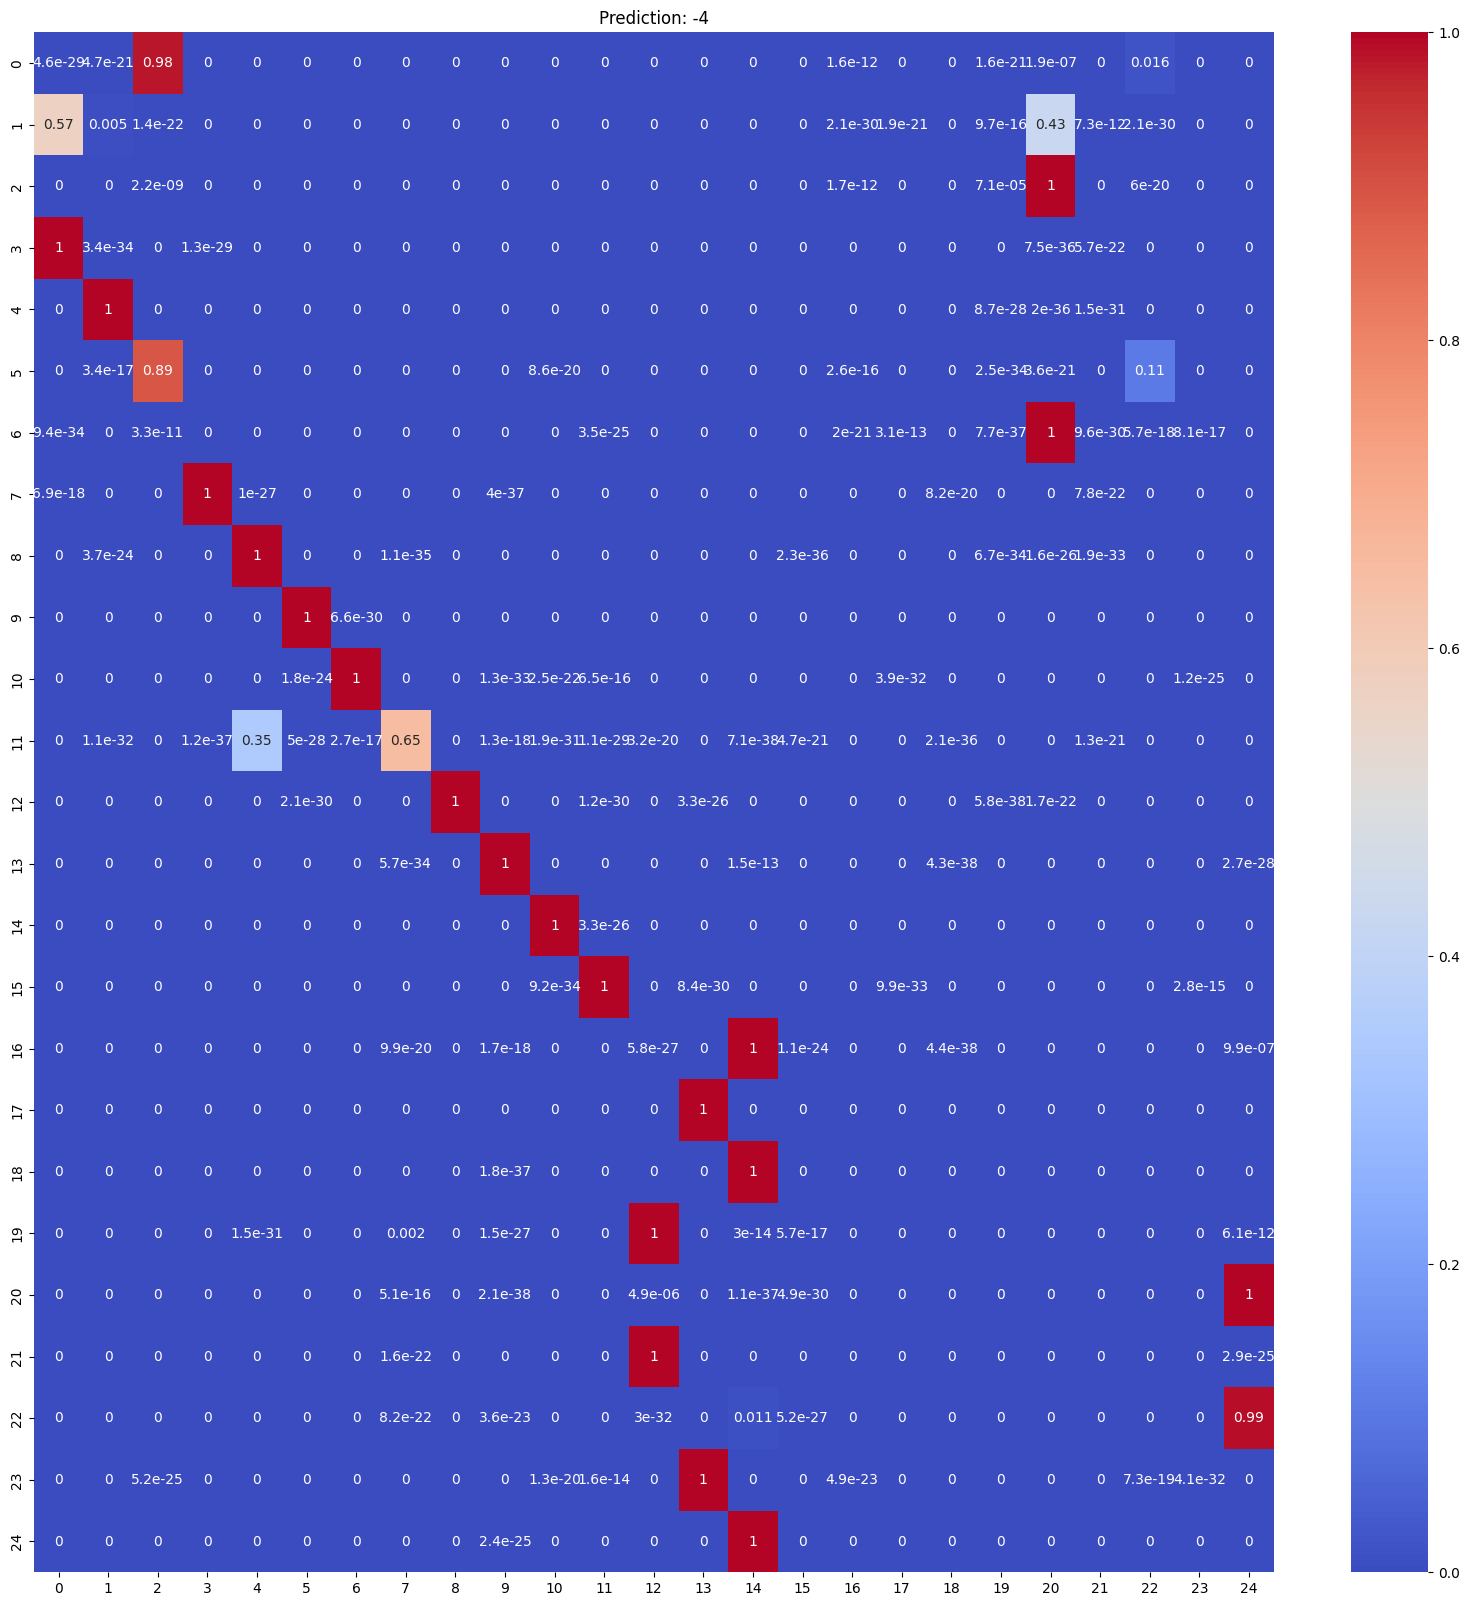

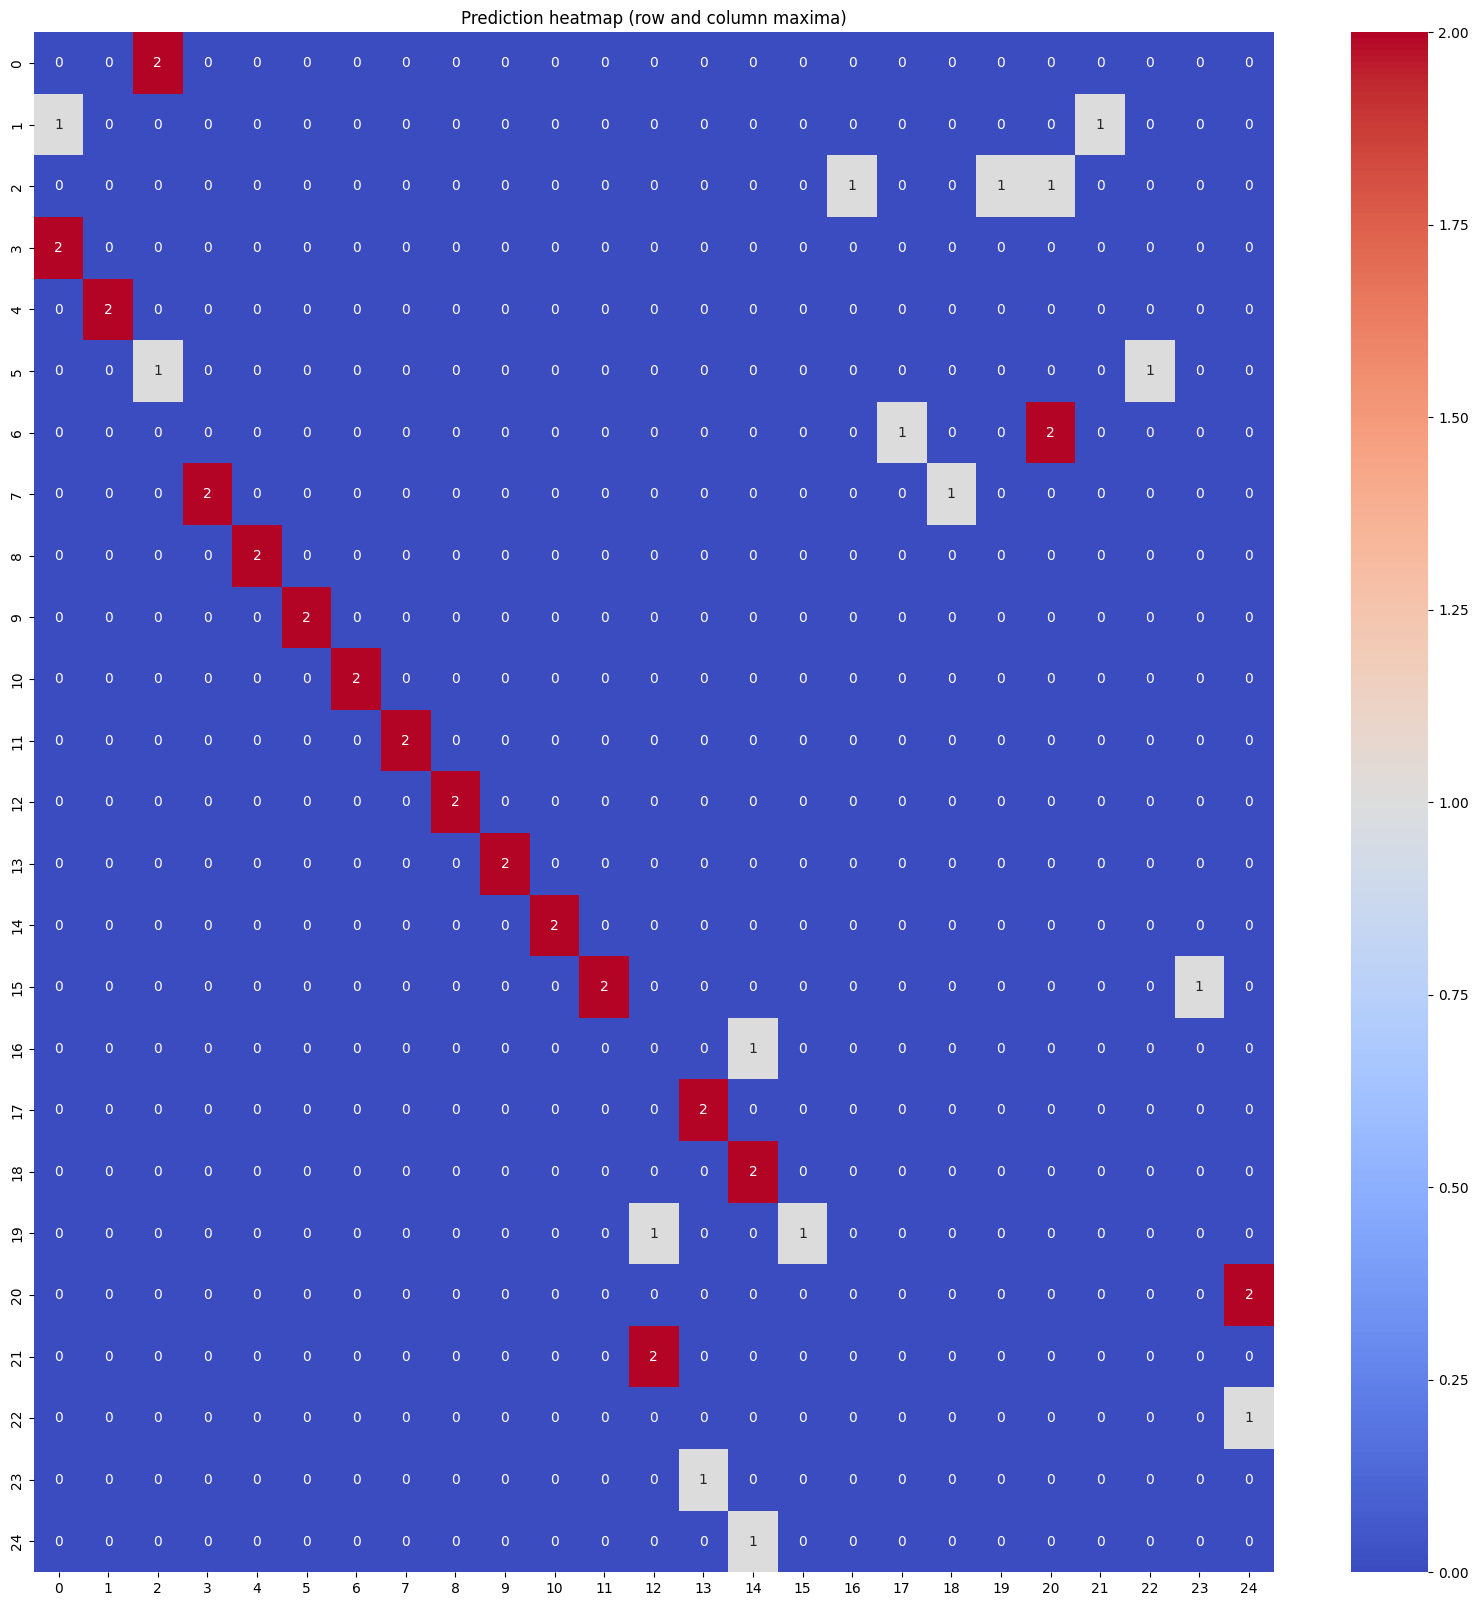

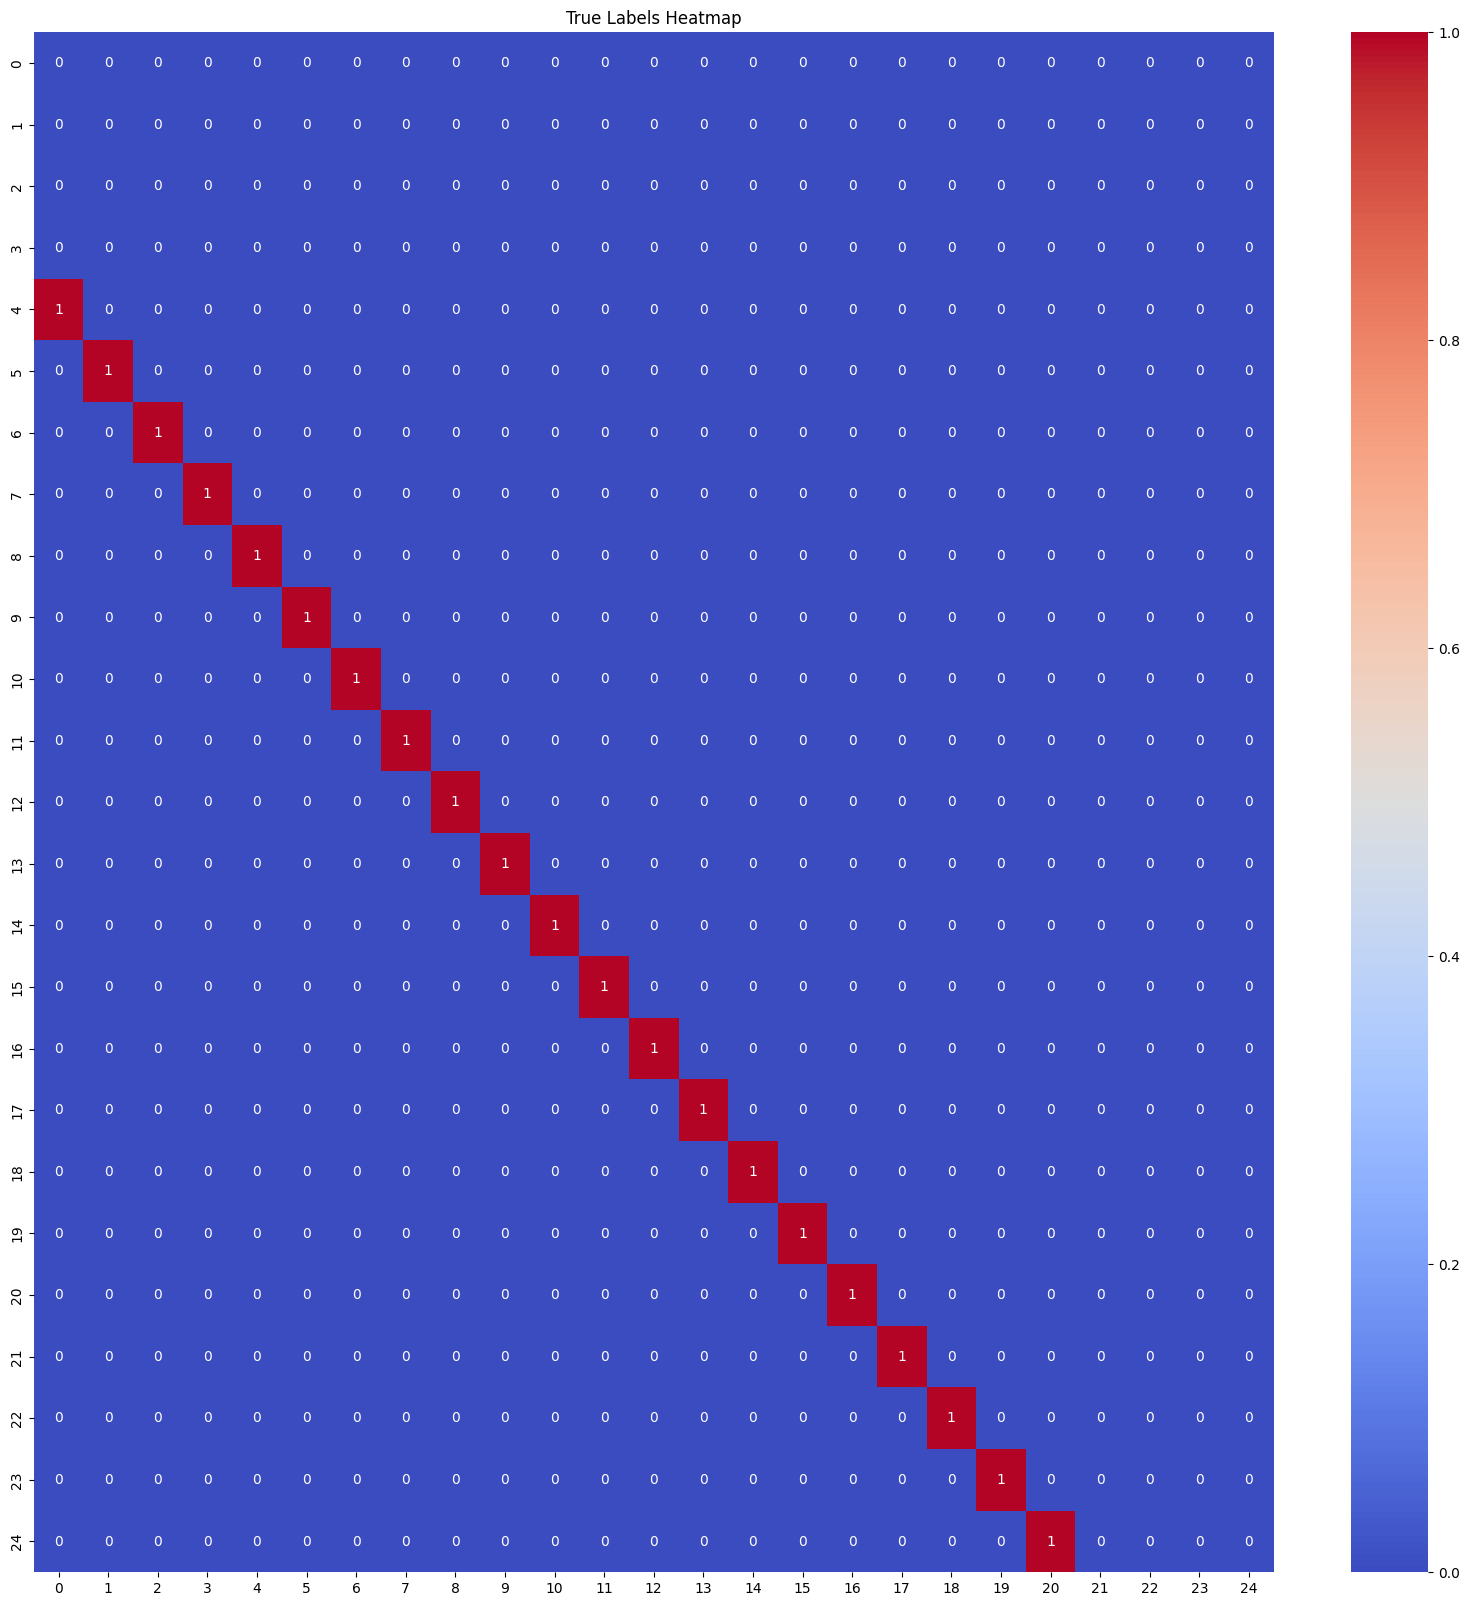

In [13]:
model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

model.predict(
    feature_loc,
    weight_name= weight_name,
    video_pair= "12_02, 12_03",
    output_path= f"/home/jireh/MT/video_sync_v1/trash/output_{num_heads}_{num_layers}_tr20_te{len_video}"
)

In [14]:
# Instantiate the model
num_heads = 4 # 8,4,1
embed_dim = 48  # 768  48
num_layers = 1 # 4,2,1
lr = 1e-2
len_video = 30
# weight_name = f'weights_swin1_{num_heads}_{num_layers}.h5'
weight_name = f'weights_1_{num_heads}_{num_layers}.h5'

print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}", sep="\n")
print(f"Learning rate: {lr}", f"Weight name: {weight_name}", sep="\n")
print(f"Video length:{len_video}")

# extracted feature
feature_loc = f"/home/jireh/MT/video_sync_v1/trash/featureData_len{len_video}.npy"
trainDS = np.load(feature_loc,allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
df.head()

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 1
Learning rate: 0.01
Weight name: weights_1_4_1.h5
Video length:30
(30, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 1.5914614, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.6673087, 0.0, 0.0, 0.0, 0.0...",6029,6017,-12
1,"[[0.0, 0.0, 0.0, 2.0211513, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 2.5224996, 0.0, 0.0, 0.0, 0.0...",4261,4258,-3
2,"[[0.0, 0.0, 0.0, 1.4987702, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.033362117, 0.0, 0.0, 0.0, 0...",1574,1555,-19
3,"[[0.0, 0.0, 0.0, 1.7975245, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.9894617, 0.0, 0.0, 0.0, 0.7...",8437,8423,-14
4,"[[0.0, 0.0, 0.0, 2.3316326, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.8649029, 0.0, 0.0, 0.0, 0.1...",3510,3501,-9



Final predictions after training:
Predicted: [-12, -3, 0, -14, -9, 13, 7, 0, -10, -5, -18, -15, -5, -4, 15, -9, -11, 4, -7, 18, -1, 2, 16, -7, 17, -3, -18, 17, 13, 3]
True: [-12, -3, -19, -14, -9, 25, -15, 15, -10, -5, 18, 23, -5, -4, 20, -9, -27, 4, -7, 18, 21, 2, 22, -7, 23, -19, 19, -21, -27, -8]
Accuracy in total: 0.44507070437566704
F1 score: 0.44507070437566704
Mean Absolute Error: 11.643443169690501

Heatmap visualization for first prediction:


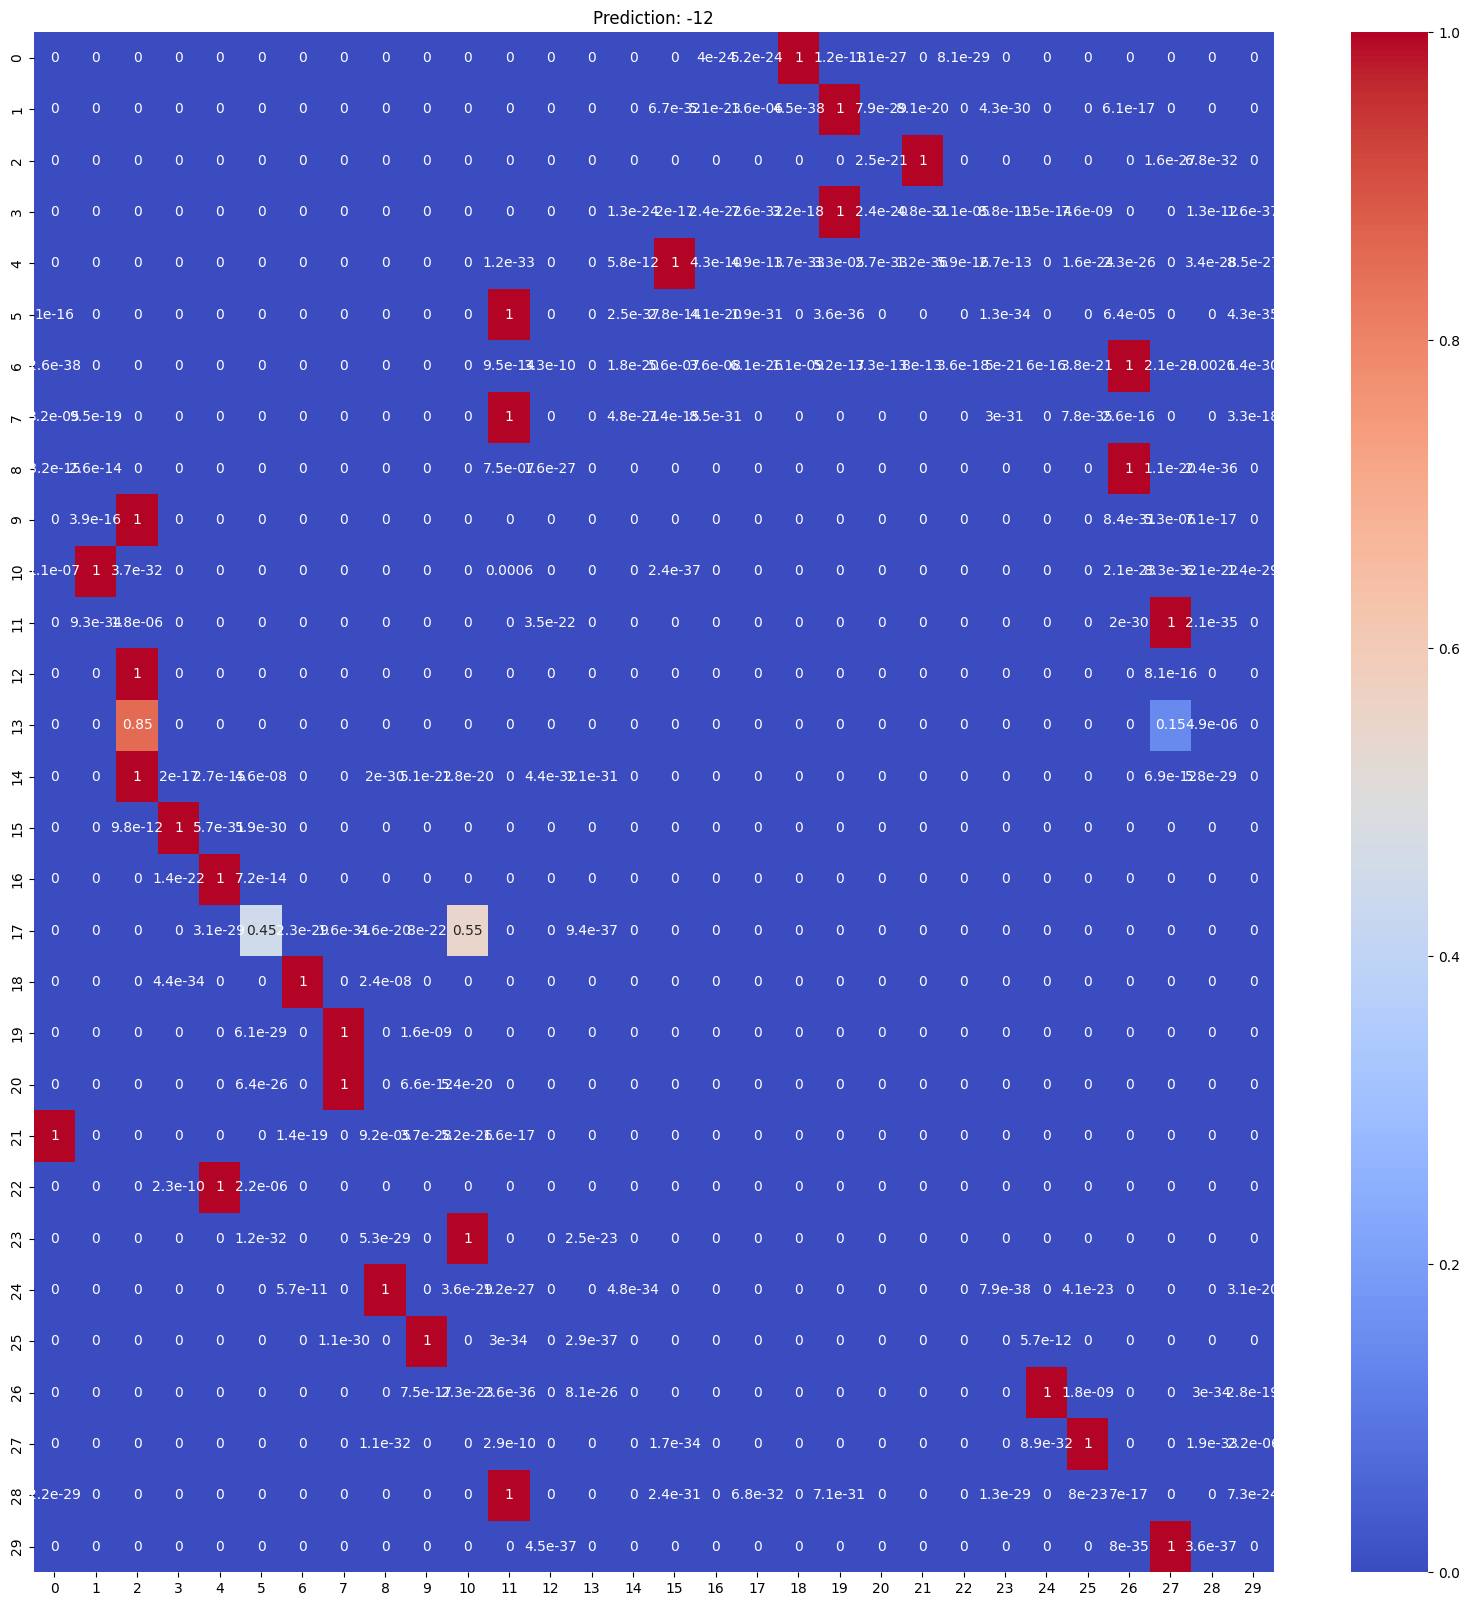

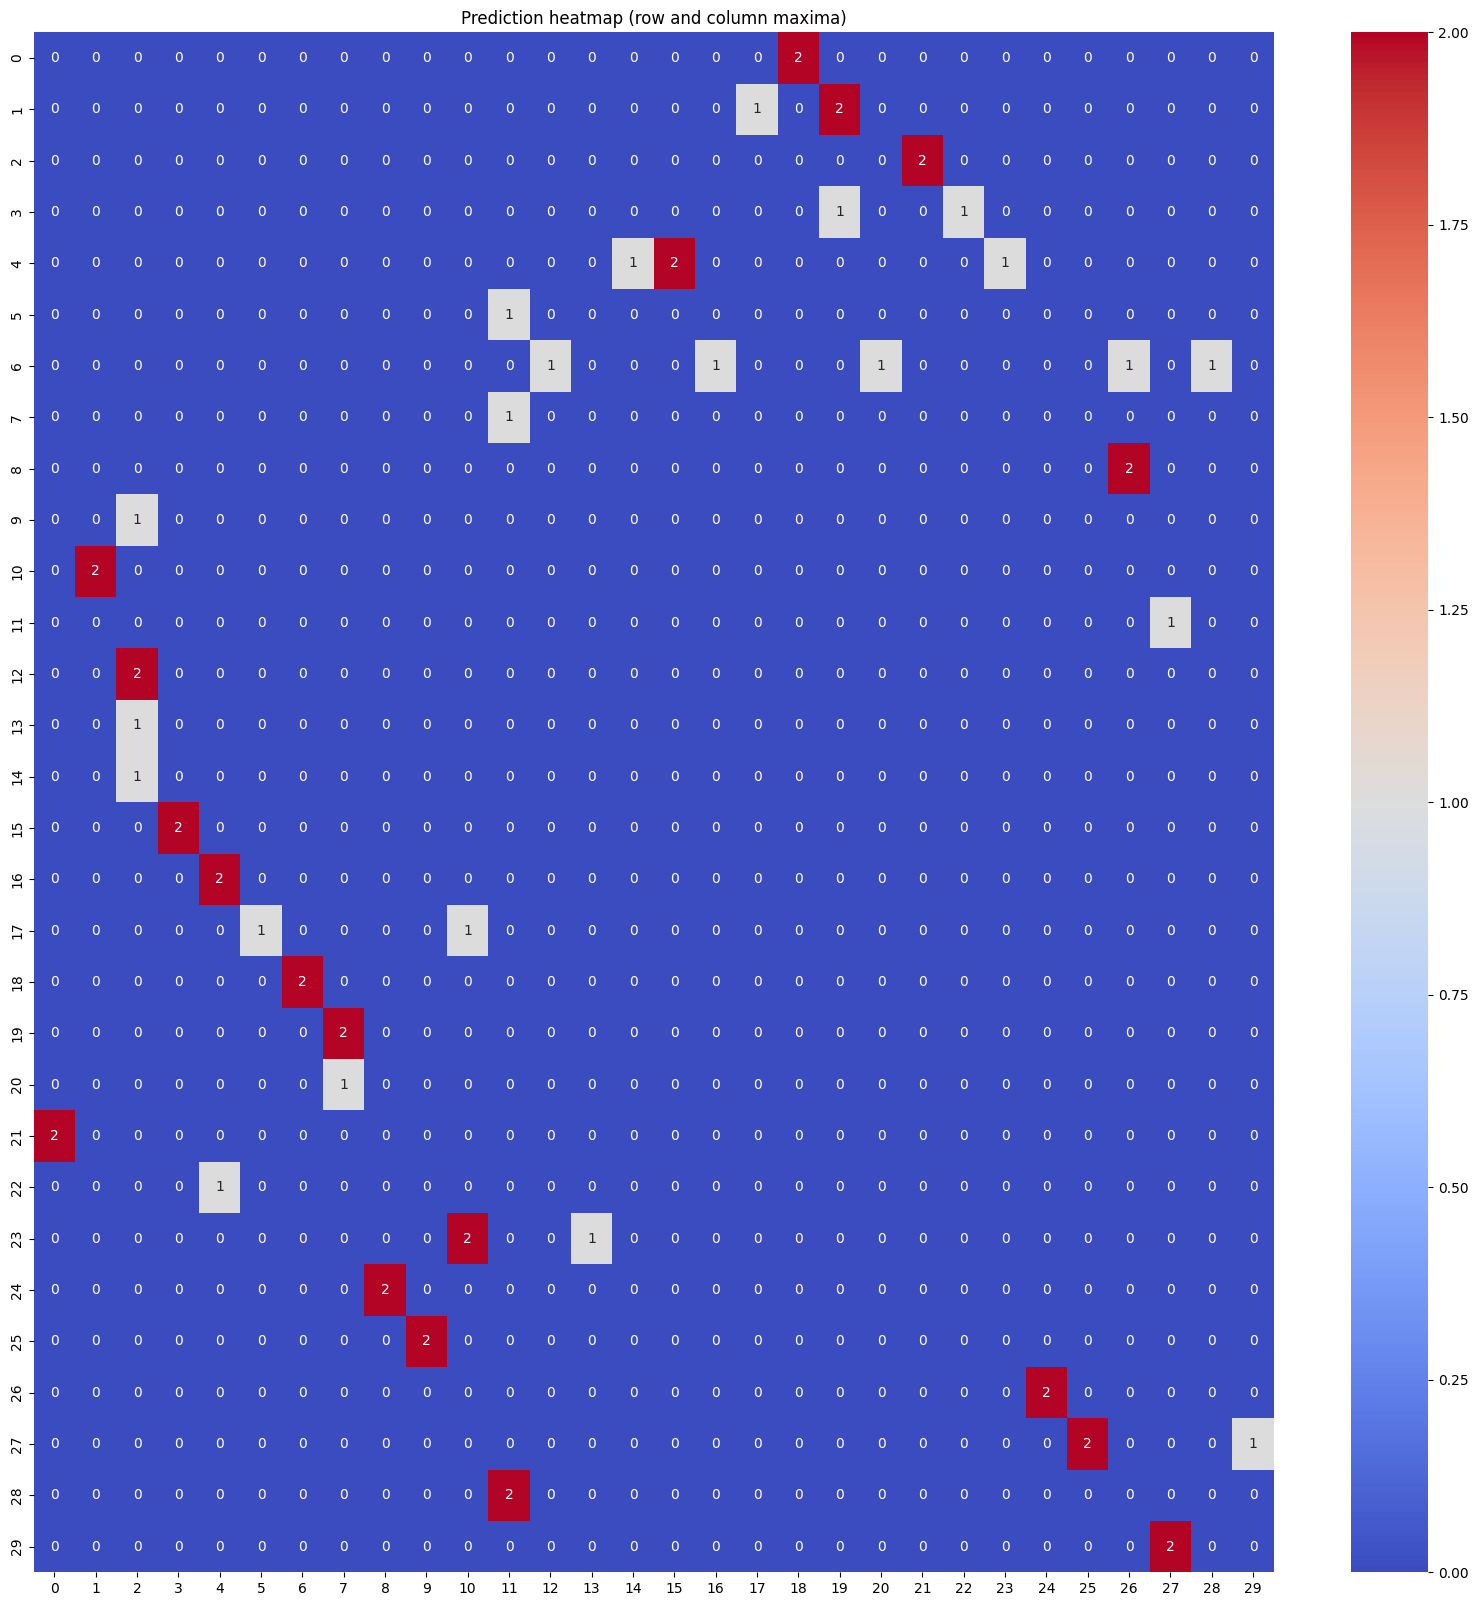

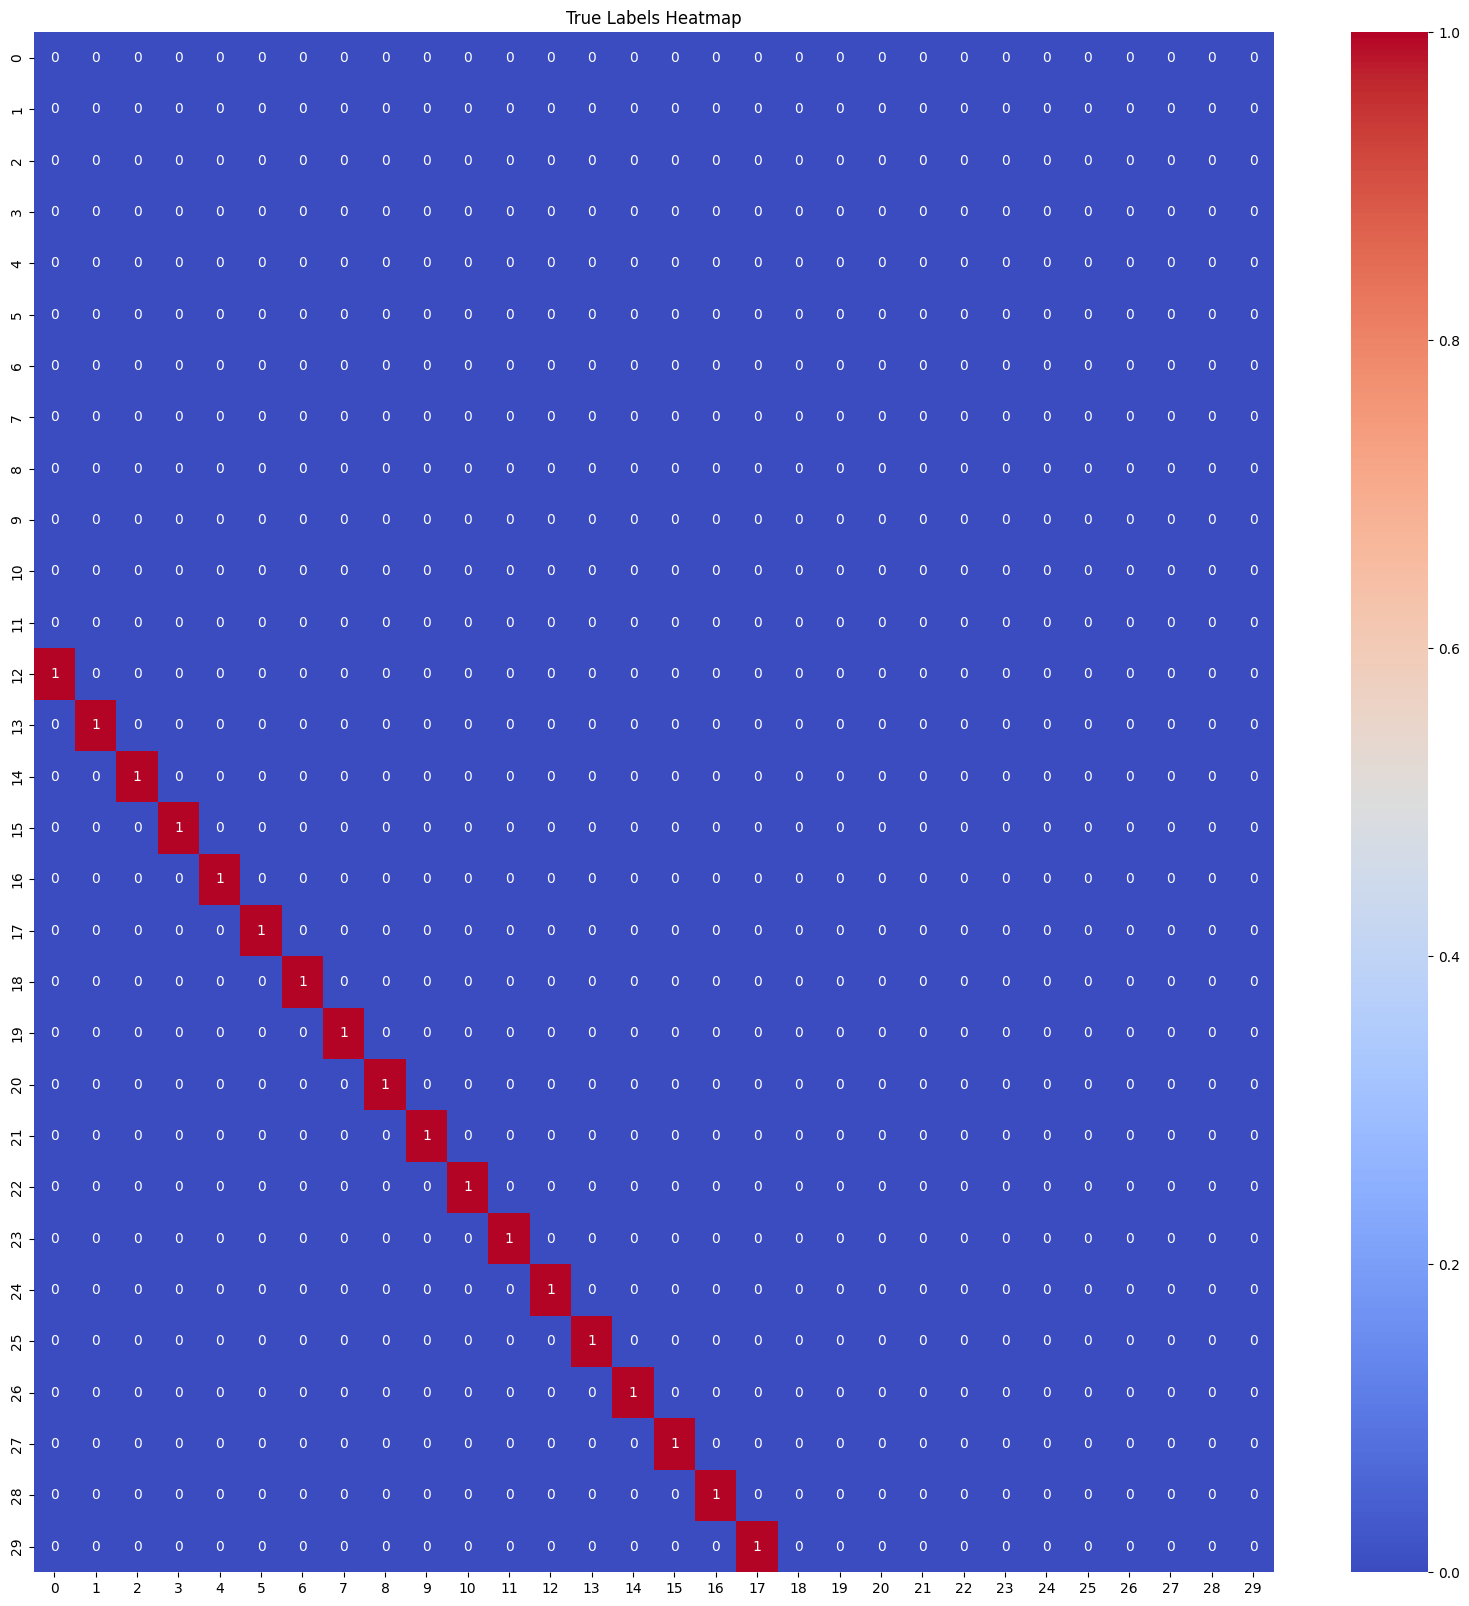

In [15]:
model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

model.predict(
    feature_loc,
    weight_name= weight_name,
    video_pair= "12_02, 12_03",
    output_path= f"/home/jireh/MT/video_sync_v1/trash/output_{num_heads}_{num_layers}_tr20_te{len_video}"
)